In [174]:
# Importation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")
from models import *


<div class="alert alert-success">
Creation of our dataframe
</div>

In [129]:
# Merge of the two datasets


tmdb = pd.read_csv("../Data/TMDB/tmdb_5000_movies.csv")
tmdb2 = pd.read_csv("../Data/TMDB/tmdb_5000_credits.csv")
tmdb2.rename(columns={'movie_id':'id'}, inplace=True)
data = pd.merge(tmdb,tmdb2, on='id')


In [130]:
# Print the columns
print(data.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')


In [131]:
### We need to be careful of the missing values
data.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

<div class="alert alert-success">
Deal with the Nan values and instances that have little meaning values
</div>

In [132]:
def drop_useless_data(ds) :
    # It drops instances where it misses some value
    # It drops also data where the time is lower than 1985

    # Drops vote count
    ds = ds.drop(ds.vote_count[ ds.vote_count < 10].index)
    # Drops overview
    index_overview_nan = ds.overview[ds.overview.isnull()].index
    ds = ds.drop(index_overview_nan)
    # Delete instances where the runtime is null
    ds = ds.drop(  ds.runtime[ds.runtime == 0].index)
    # Delete instances where the budget is null
    ds = ds.drop(  ds.budget[ds.budget == 0].index)
    # Delete instances where the revenue is null
    ds = ds.drop(  ds.revenue[ds.revenue == 0].index)
    # Reset the indexes
    ds = ds.reset_index()
    return ds


data = drop_useless_data(data)


In [133]:

# It seems that homepage and tagline have missing values
# Nevertheless, homepage is a string of the summary of the movie. We will take care of it only if we have time.
# Tagline gives kind of slogan of the movie. We don't take care of it now
# Then we convert the time

# Conversion of the time
def convert_date_time(ds,name) :
    # Returns new database where the string date time is converted to date type
    new_ds = ds.copy()
    new_ds[name] = pd.to_datetime(ds[name])
    return new_ds

data = convert_date_time(data,'release_date')

In [134]:
### Then we drop all the instances where the movies are inferior than 1985
### It seems obsolete for our criteria

def drop_time(ds) :
    new_ds = ds.copy()
    time = pd.to_datetime('1985-01-01')
    indexes = new_ds.release_date[new_ds.release_date < time].index
    new_ds = new_ds.drop(indexes)
    new_ds = new_ds.reset_index()
    return new_ds



data = drop_time(data)


In [135]:
### Create a feature for the year
### 1-of-K encoding for the months

def encode_year(ds) :
    # Creates a new column with the year
    X = ds.copy()
    X['year'] = ds.release_date.apply(lambda x : x.year)
    return X
def encode_month(ds) :
    # Creates new columns for months
    X = ds.copy()
    X['month'] = X.release_date.apply(lambda x : x.month)
    new_col = pd.get_dummies(X['month'])
    columns_name = {float(i) : 'month'+'_'+str(i) for i in range(1,13)}
    new_col.rename(columns = columns_name, inplace=True)
    ds_conc = pd.concat([X, new_col], axis=1)
    return ds_conc




data = encode_year(data)
data =encode_month(data)



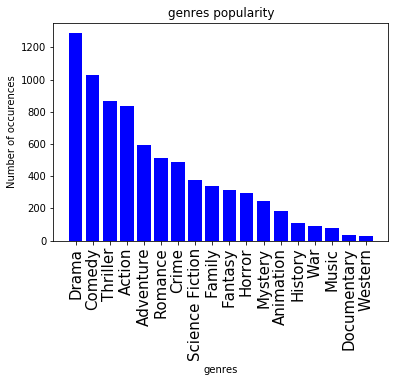

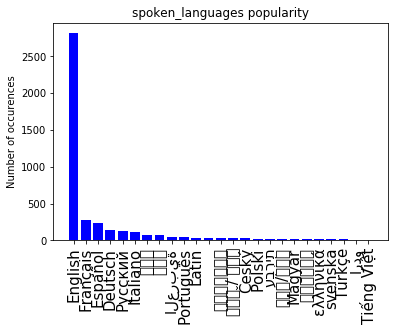

In [136]:
### Vizualisation of the data in order to convert it properly

import json
def get_json(ds,name) :
    # Return a list with the different json file in the column name and the count of it
    genres = []
    count = []
    for x in ds[name] :
        dictionnary = json.loads(x)
        for y in dictionnary :
            if not (y.get("name") in genres) :
                genres.append(y.get("name"))
                count.append(1)
            else :
                count[genres.index(y.get("name"))]+=1
    return genres,count

def plotJson(datas,name,sizeX) :
    # Vizualisation of the popularity of a given column
    # sizeX is the size of the x_axis plotted

    genres,count = get_json(datas,name)
    index_sort = np.argsort(count)

    genres = np.flip(np.array(genres)[index_sort],axis=0)
    count = np.flip(np.array(count)[index_sort],axis=0)
    y_axis = count
    x_axis = [i for i in range(len(count))]
    x_label = genres
    plt.xticks(rotation=90, fontsize = 15)

    plt.ylabel("Number of occurences")
    if ( len(x_axis) > 25 ) :
        # It doesn't look great if the len is > to 25
        plt.bar(x_axis[:25], y_axis[:25], align = 'center', color='b')
        plt.xticks(x_axis[:25], x_label[:25])
    else :
        plt.bar(x_axis, y_axis, align = 'center', color='b')
        plt.xticks(x_axis, x_label)
        plt.xlabel(name)
    plt.title(name + " popularity")
    plt.show()

plotJson(data,'genres',15)
plotJson(data,'spoken_languages',0.05)


In [137]:
### Dealing with the occurences for genres
### The aim here is to keep the N most relevant values and to make the other as a "garbage" value

def group_by_occurences(ds,name,n) :
    # It splits the column "name" in n different features
    # It keeps the n-1 most important ones, and makes the others as another feature
    # It does it only for the json files
    # It returns the n names of the columns

    # Gives the different types and the occurences of each
    genres,count = get_json(ds,name)
    # Gives the indexes sorted of the list
    indexes = np.argsort(count)
    # We want to have the maximum, not the minimum : so we inverse the result
    indexes = [indexes[len(indexes)-i-1] for i in range(len(indexes))    ]
    # We get the result of the sort
    sorted_genres = np.array(genres)[indexes]
    sorted_count = np.array(count)[indexes]
    # We take the n-1 column values
    result = sorted_genres[:n-1]
    result = np.append(result,name+"_others")
    return result


def return_indexes_json(ds,name,category) :
    # Gives the indexes of istances where the json category appears
    genres = []
    # It will give all the different category of the column name
    for index,x in enumerate(ds[name])  :
        # Convert json file into dictionnary
        dictionnary = json.loads(x)
        for y in dictionnary :
            if(y.get("name") == category ) :
                genres.append(index)
    return genres



def create_columns_by_occurences(ds,name,n) :
    # It adds n columns to ds
    # It converts the n columns by adding 1-of-K encoding

    X = ds.copy()
    column_usable = group_by_occurences(ds,name,n)
    new_vals = np.zeros( (len(column_usable),), dtype=int )
    new_cols = np.append(X.columns.tolist(), column_usable)

    for x in column_usable :
        (n,p) = X.shape
        initial = [0 for i in range(n)]
        X.insert(p,x,initial,True)

    X[column_usable] = new_vals
    indexes_fullfill = []
    for i in range(len(column_usable)-1) :
        # Makes 1 where the values should be
        x = column_usable[i]
        indexes = return_indexes_json(ds,name,x)
        indexes_fullfill = indexes_fullfill + indexes
        X[x][indexes] = 1

    col = X[column_usable[len(column_usable)-1]]

    X[column_usable[len(column_usable)-1]] =  1
    X[column_usable[len(column_usable)-1]][indexes_fullfill] = 0
    X =X.drop(name,axis=1)

    return X

# 1-of-K encoding for the genres. 50 is a value superior to take into account all the values of genre
data = create_columns_by_occurences(data,"genres",50)
#data = create_columns_by_occurences(data,"spoken_languages",5)

In [138]:

# We first added spoken_languages by keeping the 5 most occured languages
# Then we realised that this feature isn't so relevant (few words in a given movie will be taken into account
# in spoken_languages). Indeed, it doesn't seem important
# We need to take into account the fact that a vote with a lot of vote_count is more accurate
# Thus, we need to find a way to create a new column to take this into account

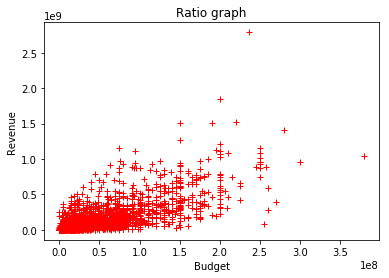

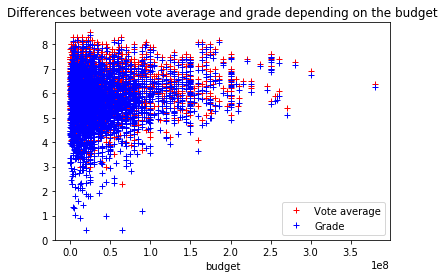

In [139]:
# By using the Chebyshev's inequality, we can get that the probability of the expected vote of a film to be greater than
# vote_average - 10/sqrt(vote_count) is 0,99 (if we consider that the variance of vote is equal to 1)

data['grade'] = data.vote_average - 10/np.sqrt(data.vote_count)

# Plots the ratio rate
plt.plot(data['budget'], data['revenue'], '+',color='r')
plt.ylabel('Revenue')
plt.xlabel('Budget')
plt.title('Ratio graph')
plt.show()

# Plots grande and vote_average depending on budget
plt.plot(data.budget, data.vote_average,color='r', marker='+',linestyle='None',label='Vote average')
plt.plot(data.budget, data.grade,color='b', marker='+',linestyle='None',label='Grade')
plt.xlabel('budget')
plt.legend()
plt.title("Differences between vote average and grade depending on the budget")
plt.show()


In [140]:
### Create a new column ratio to take into account both budget and revenue

data['ratio'] = data.budget / data.revenue
data.ratio[:5]


0    0.085008
1    0.312175
2    0.278196
3    0.230428
4    0.915045
Name: ratio, dtype: float64

In [141]:
### We sort columns by grade and we drop vote, vote_count and popularity because they are no longer relevant
data.sort_values(by=['grade'],ascending = False)
data = data.drop(['vote_average','vote_count','popularity'],axis = 1)



In [142]:
# We use data about oscar nominees to give an "oscar_score" to each film,
# depending on the number of people in the cast that have already been nominee for an oscar.

oscars = pd.read_csv("../Data/Oscar/the_oscar_award.csv")
oscars = oscars[oscars['year_film'] > 1970]
oscarCount = oscars.groupby("name").agg("count").reset_index()[['name', 'film']].rename(columns={'film': 'count'}).sort_values(by = 'count', ascending = False)
oscar_name_string = oscarCount.name.to_string(index=False).lower()

for index, row in data.iterrows():
    oscar_nominee = 0
    oscar_score = 0

    nominations=[]
    dic = json.loads(row.cast)
    for ele in dic:
        nom = ele.get('name').lower()
        if (oscar_name_string.find(nom) > -1):
            oscar_nominee += 1
    if (oscar_nominee > 0):
        for s in range(1,oscar_nominee+1):
            oscar_score = oscar_score + (1/2)**s
        oscar_score = oscar_score*100
    data.loc[index, 'oscar_score'] = oscar_score


In [143]:
def sort_by_column(ds,columns) :
    # Returns a dataset sorted by the following column
    db = ds.copy().sort_values(by=columns)
    return db

# We need to take into account the time when the movies were released
data = sort_by_column(data, ['year', 'month'])


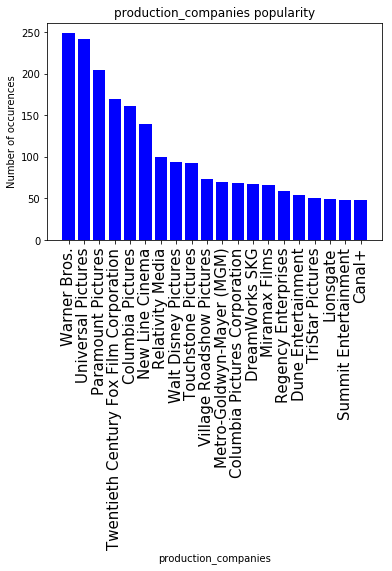

In [144]:
### First of all, we will convert the string into dictonnary
### Then, we count the occurences in order to know what is most used
### Afterthat, we will only keep the first N ones which are most used


### Convert the column into dictionnary and count the occurences
def get_json(ds,name) :
    # Return a list with the different json file in the column name and the count of it
    genres = []
    count = []
    for x in ds[name] :
        dictionnary = json.loads(x)
        for y in dictionnary :
            if not (y.get("name") in genres) :
                genres.append(y.get("name"))
                count.append(1)
            else :
                count[genres.index(y.get("name"))]+=1
    return genres,count

def sup_to_value(liste1,liste2,value) :
    # Returns two lists where every elements of the second list is higher than "value"
    liste_result1,liste_result2 = [],[]
    for index,x in enumerate(liste1) :
        if liste2[index] >= value :
            liste_result1.append(x)
            liste_result2.append(liste2[index])
    return liste_result1,liste_result2

def plotJsonLimited(ds,name,sizeX,value_min) :
    # Vizualisation of the popularity of a given column
    # sizeX is the size of the x_axis plotted

    genres,count = get_json(ds,name)
    x_axis,y_axis = sup_to_value(genres,count, value_min)
    plt.xticks(rotation=90, fontsize = 15)
    plt.ylabel("Number of occurences")
    plt.xlabel(name)
    plt.bar(x_axis, y_axis, align = 'center', color='b')
    plt.title(name + " popularity")
    plt.show()


def get_N_first(ds,name,N) :
    # Gives the N first name and occurences of a given category coded in json
    genres,count = get_json(ds,name)
    value_min = np.flip(np.sort(count),axis=0)[N]
    types, count = sup_to_value(genres,count, value_min)
    count_indexes = np.argsort(count)
    types = np.flip(np.array(types)[count_indexes],axis=0)
    count = np.flip(np.array(count)[count_indexes],axis=0)
    return types,count

def get_N_first_all(ds,name) :
    # Gives the occurences of a given category coded in json
    genres,count = get_json(ds,name)
    value_min = np.flip(np.sort(count),axis=0)[-1]
    types, count = sup_to_value(genres,count, value_min)
    count_indexes = np.argsort(count)
    types = np.flip(np.array(types)[count_indexes],axis=0)
    count = np.flip(np.array(count)[count_indexes],axis=0)
    return types,count

def plot_N_first(ds,name,N) :
    # Plots the N first name and occurences of a given category coded in json
    # Nevertheless, it returns all the occurences (not the N first)
    types,count = get_N_first_all(ds,name)
    plt.xticks(rotation=90, fontsize = 15)
    plt.ylabel("Number of occurences")
    plt.xlabel(name)
    plt.bar(types[:N],count[:N],  align = 'center', color='b')
    plt.title(name + " popularity")
    #plt.show()
    return types,count

#plot_N_first(data, "production_countries",20)
types_p_companies, count_t_companies = plot_N_first(data, "production_companies",20)


In [145]:
#types_cast, count_cast = plot_N_first(data, "cast",20)
#types_crew, count_crew = plot_N_first(data, "crew",20)
### Here we do the 1-of-K encoding for the 5 most important production_countries
data = create_columns_by_occurences(data,"production_countries",5)


Text(0.5, 1.0, 'Occurences of original languages')

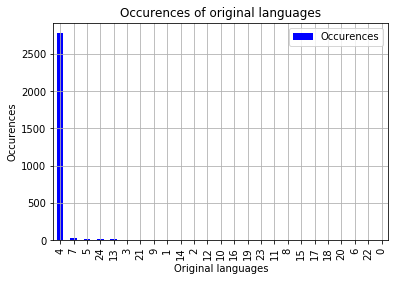

In [146]:
### We want to compute 1-of-K encoding for the production_companies
### Nevertheless, we will before categorize it in 3 categories
### To do that, we take into account the previous plot and we split by 3
### In this effect, when the occurences are > 85 or between 85 and 20 and <20


def get_index_json(x,liste_companies) :
    # Gives the instance indexes where the companies are
    print(x)
    dictionnary = json.loads(x)
    liste_index = []
    for y in dictionnary :
        name = y.get("name")
        for i,x in enumerate(liste_companies) :
            if name in x :
                liste_index.append(i)
                break
    if liste_index == [] :
        return 0
    return np.amax(liste_index)

def split_name_prod_comp(ds) :
    # Splits data into categories for the production companies
    high_comp_indexes = np.where(count_t_companies > 85)[0]
    high_comp = types_p_companies[high_comp_indexes]
    medium_comp_indexes = np.where( (count_t_companies <= 85) & (count_t_companies > 45) )[0]
    medium_comp = types_p_companies[medium_comp_indexes]
    low_comp_indexes = np.where(count_t_companies <= 45)[0]
    low_comp = types_p_companies[low_comp_indexes]
    all_companies = [low_comp,medium_comp,high_comp]
    print(ds.production_companies)
    ds.production_companies = ds.production_companies.apply(get_index_json, liste_companies = all_companies)
    ds = encode_language(ds.copy(),"production_companies",'prod_company')
    return ds

#data = split_name_prod_comp(data)
#print(data.head(2))

data_lang = data.groupby(['original_language']).size().reset_index(name='Occurences')
data_lang.sort_values(by='Occurences',ascending=False).plot(kind='bar',\
                                                      color='b', label='Revenue', grid=True, linestyle='-' )
plt.ylabel("Occurences")
plt.xlabel("Original languages")
plt.title('Occurences of original languages')


In [147]:
def update_original_language(ds) :
    # Keeps the most important language
    # Fills the others with the value "others"
    ds.original_language = ds.original_language.map({'en' : 'en', 'fr' : 'fr', 'es' : 'es', 'de' :'de' ,'zh' : 'zh'})
    ds.original_language = ds.original_language.fillna('others')
    return ds

def encode_language(ds,name,prefix_name) :
    # 1-of-K encoding for name
    new_col = pd.get_dummies(ds[name],prefix = prefix_name)
    ds_conc = pd.concat([ds, new_col], axis=1)
    return ds_conc


data = update_original_language(data)
data = encode_language(data,'original_language','language')


In [148]:
### We will encode the runtime into different categories

def encode_runtime(ds,name) :

    ds[name].loc[ ds[name] < 60 ] = 1
    ds[name].loc[ (ds[name] >= 60) & (ds[name] < 90) ] = 2
    ds[name].loc[ (ds[name] >= 90) & (ds[name] < 120) ] = 3
    ds[name].loc[ ds[name] >= 120 ] = 4
    liste_time = ["less than 60 minutes","between 60 minutes and 90 minutes", \
                 "between 90 minutes and 120 minutes", "more than 120 minutes"]
    number_time = "Number of time of movies that last : "
    #for i in range(4) :
        #print(number_time + liste_time[i])
        #print(len(ds[name][ds[name] == i+1]))
    return ds

data = encode_runtime(data,"runtime")


In [149]:
### 1-of-K encoding for the runtime

def encoding(ds,name) :

    new_col = pd.get_dummies(ds[name])
    new_col.rename(columns = {1.0 : 'short_time',2.0:'medium_time',3.0:'quite_long_time',\
                             4.0:'long_time'}, inplace=True)
    ds_conc = pd.concat([ds, new_col], axis=1)
    return ds_conc

data = encoding(data,"runtime")


In [150]:
def remove_unused_data(ds,liste_columns) :
    # Removes all the features unused
    for x in liste_columns :
        ds = ds.drop(x, axis=1)
    return ds

unused = ['homepage','original_title','overview','runtime','status','tagline','title_x' ,\
          'title_y','original_language','production_companies',\
         'level_0','index','id','release_date','spoken_languages','month']
data = remove_unused_data(data,unused)

<div class="alert alert-success">
Models
</div>

In [151]:
def get_data_from_db_by_gender(ds) :
    # We suppose that ds is already ordered by the year
    # It will return all the database split by genres
    
    db = ds.copy()
    i_first = np.where(db.columns == "Drama")[0][0]
    i_last = np.where(db.columns == 'genres_others')[0][0]   
    liste_genre = [ db.columns[i] for i in range(i_first, i_last + 1)]
    data_genres = []
    
    for i,name in enumerate(liste_genre) :
        current_db =  db[db[name] == 1]
        current_db = current_db.drop(liste_genre,1)
        data_genres.append(current_db)
    return data_genres,liste_genre    

def get_data_from_db_by_gender_n(ds,n) :
    # It will return all the n first databases split by genres
    data_genres,liste_genre = get_data_from_db_by_gender(ds)
    print(liste_genre[:n])
    return data_genres[:n],liste_genre[:n]
    

# Creation of our database for each genre
# We only use it now for the vizualisation
data_genres,liste_genre = get_data_from_db_by_gender(data)


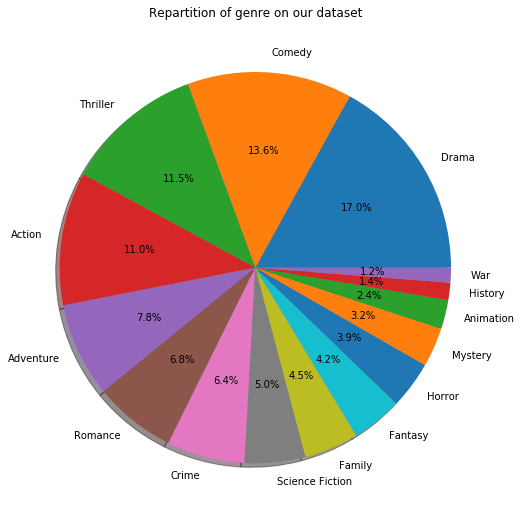

In [152]:
def plot_gender(data_genres,liste_genre) :
    # Plot the gender repartition through our dataset
    # We plot only the 15 first ones because otherwise we don't see everything in the plot
    sizes = []
    for x in data_genres[:15] :
        current_size = x.shape[0]
        sizes.append(current_size)
    fig = plt.figure(figsize=(9,9))
    plt.pie(sizes, labels=liste_genre[:15],autopct='%1.1f%%',shadow=True)
    plt.title("Repartition of genre on our dataset")
    plt.show()
    
# Vizualisation of the proportion of the genre
plot_gender(data_genres,liste_genre)

In [153]:
# Keywords : gets the average note of a given keyword
# Then : we make the average of each keyword for a given movie
# As we have a grade for each keyword, we will take the average for a given movie of all keywords



### Convert the column into dictionnary and get all the popularity_rate for each 
def get_popularity_by_name(ds,name) :
    # Return a list with the different json file in the column name and the count of it
    genres = []
    popularities = []
    for index,x in enumerate(ds[name]) :
        dictionnary = json.loads(x)
        current_grade = np.array(ds["grade"])[index]
        for y in dictionnary :
            if not (y.get("name") in genres) :
                genres.append(y.get("name"))
                partial_pop = [current_grade]
                popularities.append(partial_pop)
            else :
                popularities[genres.index(y.get("name"))].append(current_grade)
    
    average_pop = []
    for x in popularities :
        average_pop.append(np.mean(x))
    return genres,average_pop



def sort_two_lists(liste1,liste2) :
    # Sort the two lists with liste2 to be ordered
    indexes = np.argsort(liste2)
    liste_res_1 = np.flip(np.array(liste1)[indexes],axis=0)
    liste_res_2 = np.flip(np.array(liste2)[indexes],axis=0)
    return liste_res_1,liste_res_2


def plot_bar(x,y,x_name,y_name,title) :
    # Plots as a bar
    plt.xticks(rotation=90, fontsize = 15)
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.bar(x,y,  align = 'center', color='b')
    plt.title(title)
    plt.show()


def plot_popularity_keyword(N) :
    # Plot the N first keywords
    
    keyword,popularity = get_popularity_by_name(data,"keywords")
    keyword,popularity = sort_two_lists(keyword,popularity)
    keyword ,popularity = keyword[:N],popularity[:N]
    plot_bar(keyword,popularity,"Keywords","Popularity","Popularity of keywords")

    
def convert_keyword_grade(x,K,P) :
    # Applies P[index] with index indicating where is K in the instance x
    dictionnary = json.loads(x)
    liste_grade = []
    for y in dictionnary :
        index = np.where(K == y.get("name"))[0][0]
        liste_grade.append(P[index])
    return np.mean(liste_grade)
    
    
def process_by_grade(ds,name) :
    # Grades the given name by taking the average 
    X = ds.copy()
    keyword,popularity = get_popularity_by_name(X,name)
    keyword,popularity = sort_two_lists(keyword,popularity)
    new_name =  name+'_grade'
    X[new_name] = X[name]
    X[new_name]= X[new_name].apply(convert_keyword_grade, K = keyword, P = popularity)
    X = X.drop(name, axis=1)
    return X
    
    
def process_grade_genre(liste_genres) :
    # Returns two dataframe with the train and test
    # It adds the grade for the features keywords, cast and crew
    liste_to_process = ['keywords','cast','crew']
    liste_train, liste_test = [],[]
    for df in liste_genres : 
        train, test = train_test_split(df, test_size=0.2, shuffle = False)
        for x in liste_to_process :
            train = process_by_grade(train,x)
            test = process_by_grade(test,x)
        liste_train.append(train)
        liste_test.append(test)    
    return liste_train, liste_test




In [154]:
### We need to drop the instances where the keywords_grade is null
def drop_nan_grade(ds) :
    X = ds.copy()
    indexes = X.keywords_grade[X.keywords_grade.isnull()].index
    X = X.drop(indexes)
    X = X.reset_index(drop=True)
    return X

def get_clean_value(train, test) :
    # Return the train and dataset where we drawback the nan values for the grade
    new_train, new_test = [],[]
    for index, x in enumerate(train) :
        new_train.append(drop_nan_grade(x))
        new_test.append(drop_nan_grade(test[index]))
    return new_train,new_test


In [155]:
from sklearn.model_selection import train_test_split
def split_data(df,df1, label) :
    # Splits the inputs into training data and test data according to the label

    X_train = df.drop(label, 1).values
    y_train = df[label].values
    X_test = df1.drop(label, 1).values
    y_test = df1[label].values
    
    
    return X_train, X_test, y_train, y_test


In [156]:
# Class that will allow us to facilitate the use of parameters 
class SKlearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        # Trains the classifier
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        # Predicts the output given a dataset
        return self.clf.predict(x)
    
    def fit(self,x,y):
        # Fits the given data and the output
        return self.clf.fit(x,y)


Here we'll define the coefficient of determination, which we're going to call it the Score for a Regressor : 

$$ R^{2} = 1 - \frac{ \sum_{i} y_{i} - \hat y_{i} }{\sum_{i} y_{i} - \bar y_{i}}$$
where $y_{i}$ is the true output, $\hat y_{i}$ is the predicted one and $\bar y_{i}$ is the mean of the real output

In [157]:
# Validation step : we do this only to get the best parameters from our models
# Then, we'll keep the best classifier / regressor for testing it with the test set
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

# Number of folds for the validation step
NFOLDS = 5
# We use a time separation : our data is time-dependent
tscv = TimeSeriesSplit(n_splits=NFOLDS)

def get_oof(clf, x_train, y_train) :
    # Out of fold : returns the average score after doing TimeSeriesSplit
    # This is only made for regressors (we'll use another criteria for the classifiers)
    oof_score = np.zeros( (NFOLDS))
    for i,(train_index, test_index) in enumerate(tscv.split(x_train)) :
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]
        clf.fit(x_tr,y_tr)        
        oof_y_predict = clf.predict(x_te)
        # Coefficient of determination defined above 
        oof_score[i] = r2_score(y_te,oof_y_predict)        

    return np.mean(oof_score)

def get_score(model, x_train, y_train, x_test, y_test) :
    # Get the final score after getting the best parameters
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return r2_score(y_test, y_pred)



In [158]:
data.columns

Index(['budget', 'keywords', 'revenue', 'cast', 'crew', 'year', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Drama',
       'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime',
       'Science Fiction', 'Family', 'Fantasy', 'Horror', 'Mystery',
       'Animation', 'History', 'War', 'Music', 'Documentary', 'Western',
       'genres_others', 'grade', 'ratio', 'oscar_score',
       'United States of America', 'United Kingdom', 'Germany', 'France',
       'production_countries_others', 'language_de', 'language_en',
       'language_es', 'language_fr', 'language_others', 'language_zh',
       'short_time', 'medium_time', 'quite_long_time', 'long_time'],
      dtype='object')

In [159]:
# Compute the grade for keywords, crew and cast for all the data
# As we don't want to cheat, we can't compute the grade for all the data and make it in both the train and 
# the test. 
# We compute here the grade for each of these categories for all the data
# Then, we'll compute it for only the train set
# For the test set, it will have access to the all data. So we'll keep all the dataset to give the grade 

liste_all_grade = []
for x in ['keywords','cast','crew'] :
        liste_all_grade.append(process_by_grade(data,x))

In [160]:
# Class to get the split of our data depending on genre, removing some features, etc
# It will focus on the computation of the keyword_grade, cast_grade and crew_grade
from sklearn.model_selection import train_test_split
import copy


class Preprocess:
    def __init__(self, dataset) :
        # We initialize our preprocess with a dataset
        # It will have a train and test part after spliting the dataset into these two subsets
        self.ds = sort_by_column(dataset, ['year']) 
        self.data_genre = None
        self.train, self.test = [],[]
        
    def split_by_genre(self,n):
        # We return only the n first genre
        # It splits the data by genre
        self.data_genre , _ = get_data_from_db_by_gender_n(self.ds,n)
    
    def split_train_test(self) :
        # It will split the data into train and test sets
        # It has 20% of test and 80% of the data for the train
        if self.data_genre is None :
            train, test = train_test_split(self.ds, test_size=0.2)
            self.train, self.test = [train], [test]
        else :
            train_g, test_g = [],[]
            for df in self.data_genre :
                train, test = train_test_split(df, test_size=0.2)
                train_g.append(train)
                test_g.append(test)
            self.train, self.test = train_g, test_g

    def compute_grade(self,liste_all) :
        # Compute grade for the keywords, cast and crew for the train and the test
        # It will only compute the following grade from the train set to give a grade 
        # For the test set, it will keep all the dataset to give the grade
        liste_to_process = ['keywords','cast','crew']
        liste_train, liste_test = [],[]
        for index,data in enumerate(self.train) :
            for i,x in enumerate(liste_to_process) :            
                if i == 0 :
                    train = data.copy()
                    test = self.test[index].copy()
                train = process_by_grade(train,x)
                test[x+'_grade'] = liste_all[i][x+'_grade'][test.index]
                test.drop(x,axis=1, inplace = True)
            liste_train.append(train)
            liste_test.append(test)
        liste_train, liste_test = get_clean_value(liste_train, liste_test)
        self.train, self.test = liste_train, liste_test
                

In [161]:
# We get our work from our previous work for preprocessing the data
pre_process = Preprocess(data)
# We split it into train and test
pre_process.split_train_test()
# Then we compute the grade for the 3 categories keywords, crew and cast
pre_process.compute_grade(liste_all_grade)


In [162]:
# Prints the values of revenue in order to use it after for discretization
print(pre_process.ds.revenue.describe())

count    2.895000e+03
mean     1.289517e+08
std      1.923806e+08
min      5.000000e+00
25%      1.928311e+07
50%      6.127945e+07
75%      1.556332e+08
max      2.787965e+09
Name: revenue, dtype: float64


* Discretization functions

In [163]:

def discretize_grade_100(liste_ds) :
    # It will create 100 label for the grade
    # Multiplie by 10 and then take the int of the grade
    new_ds = []
    for df in liste_ds :
        new_df = df.copy()
        new_df.grade = df.grade * 10
        new_df.grade = new_df.grade.apply(lambda x : int(x))
        new_ds.append(new_df)
    return new_ds

def labelize(x) :
    # It will create labels between 1 and 19
    if x<1 :
        return 1
    elif x>=1 and x<1.5 :
        return 2
    elif x>=1.5 and x<2 :
        return 3
    elif x>=2 and x<2.5 :
        return 4
    elif x>=2.5 and x<3 :
        return 5
    elif x>=3 and x<3.5 :
        return 6
    elif x>=3.5 and x<4 :
        return 7
    elif x>=4 and x<4.5 :
        return 8
    elif x>=4.5 and x<5 :
        return 9
    elif x>=5  and x<5.5 :
        return 10
    elif x>=5.5 and x<6 :
        return 11
    elif x>=6 and x<6.5 :
        return 12
    elif x>=6.5 and x<7 :
        return 13
    elif x>=7 and x<7.5 :
        return 14
    elif x>=7.5 and x<8 :
        return 15
    elif x>=8 and x<8.5 :
        return 16
    elif x>=8.5 and x<9 :
        return 17
    elif x>=9 and x<9.5 :
        return 18
    elif x>=9.5 :
        return 19

def labelize_revenue(x): 
    # It splits the revenue into 3 categories : low revenue, middle revenue and high revenue
    # We took 25% and 75% of the revenue (as shown in the previous cell)
    if x <= 19283110 :
        return 1
    elif x> 19283110 and x<=155633200 :
        return 2
    else :
        return 3
    
    
def discretize_grade_20(liste_ds) :
    # Discretize the grade into 20 categories
    new_ds = []
    for df in liste_ds :
        new_df = df.copy()
        new_df.grade = new_df.grade.apply(labelize)
        new_ds.append(new_df)
    return new_ds


def discretize_revenue(liste_ds) :
    # Discretization of the revenue into 3 classes : low, medium and high
    new_ds = []
    for df in liste_ds :
        new_df = df.copy()
        new_df.revenue = new_df.revenue.apply(labelize_revenue)
        new_ds.append(new_df)
    return new_ds

    



In [164]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# Creation of an other class in order to print the features, change the label, delete some features, ...

class Dataset :
    # Initialization with a Preprocess object
    def __init__(self, pre_process) :
        self.pre_process = copy.deepcopy(pre_process)
        # Data where grade is the label
        self.grade_set = []
        # Data where ratio is the label
        self.ratio_set = []
        # Data where revenue is the label
        self.revenue_set = []
        self.scaler = StandardScaler() 
        
    def remove_feature(self,name_begin, name_end) :
        # It will remove features from name_begin until name_en
        for n,ds in enumerate(self.pre_process.train) :
            i_min = ds.columns.get_loc(name_begin) 
            i_max = ds.columns.get_loc(name_end)
            index = [i for i in range(i_min, i_max+1)]
            ds.drop(ds.columns[index], axis=1, inplace=True)
            self.pre_process.test[n].drop(ds.columns[index], axis=1, inplace=True)
            
    def print_features(self) :
        # Prints the features
        print(self.pre_process.train[0].columns)
    
    def set_sets(self):
        # It will split the data according to the 3 differents labels
        # It corresponds to self.grade_set, self.ratio_set and self.revenue_set
        for index,x in enumerate(self.pre_process.train) :
            # Returns X_train, X_test, y_train, y_test
            data_t_g , data_te_g = x.copy(), self.pre_process.test[index].copy()
            data_t_g.drop(['ratio', 'revenue'], axis = 1, inplace = True)
            data_te_g.drop(['ratio', 'revenue'], axis = 1, inplace = True)
            self.grade_set.append(split_data(data_t_g,data_te_g, 'grade'))
            data_t_r , data_te_r = x.copy(), self.pre_process.test[index].copy()
            data_t_r.drop(['grade', 'revenue'], axis = 1, inplace = True)
            data_te_r.drop(['grade', 'revenue'], axis = 1, inplace = True)
            self.ratio_set.append(split_data(data_t_r,data_te_r, 'ratio'))
            data_t_re , data_te_re = x.copy(), self.pre_process.test[index].copy()
            data_t_re.drop(['grade', 'ratio'], axis = 1, inplace = True)
            data_te_re.drop(['grade', 'ratio'], axis = 1, inplace = True)
            self.revenue_set.append(split_data(data_t_re,data_te_re, 'revenue'))     
        
    def discretize(self, n) :
    # It will discretize the grade.
    # If n == 0, it will create 100 labels otherwise 20 labels
        if n == 0 :
            for index, x in enumerate(self.pre_process.train) :
                x.grade = discretize_grade_100(self.pre_process.train)[0].grade
                self.pre_process.test[index].grade = discretize_grade_100(self.pre_process.test)[0].grade
        else :
            for index, x in enumerate(self.pre_process.train) :
                x.grade = discretize_grade_20(self.pre_process.train)[0].grade
                self.pre_process.test[index].grade = discretize_grade_20(self.pre_process.test)[0].grade
    def discretize_revenue(self) :
        for index, x in enumerate(self.pre_process.train) :
            x.revenue = discretize_revenue(self.pre_process.train)[0].revenue
            self.pre_process.test[index].revenue = discretize_revenue(self.pre_process.test)[0].revenue
            
            
    def inter_scalar(self, n) :
        # If n == 0, it will normalize
        # Else, it will denormalize
        liste_data = [self.grade_set ,self.ratio_set ,self.revenue_set] 
        new_liste = []
        for data in liste_data :
            new_data = []
            for x_train, x_test, y_train, y_test in data :
                if n == 0 :
                    self.scaler.fit(np.concatenate((x_train,x_test)))
                    new_data.append([self.scaler.transform(x_train),\
                                     self.scaler.transform(x_test), y_train,y_test])
                else :
                    new_data.append([self.scaler.inverse_transform(x_train),\
                                     self.scaler.inverse_transform(x_test), y_train,y_test])
            new_liste.append(new_data)
        self.grade_set = new_liste[0]
        self.ratio_set = new_liste[1]
        self.revenue_set = new_liste[2]
    
    def normalize(self ):
        # Normalization of the data 
        self.inter_scalar(0)
        
    def denormalize(self) :
        # Denormalization of the data
        self.inter_scalar(1)
        
        
    def get_grade_data(self,index) :
        # Returns the data where grade is the label
        return self.grade_set[index]
    
    def get_ratio_data(self, index) :
        # Returns the data where ratio is the label
        return self.ratio_set[index]
    
    def get_revenue_data(self, index) :
        # Returns the data where revenue is the label
        return self.revenue_set[index]
        
    def plot_correl_matrix(self,index) :
        # Plots the correlation matrix
        # Index will tell which of the train set it will print
        # Useful when there are a split by genre
        # If there are no split by genre, takes 0 will work 
        f, ax = plt.subplots(figsize=(9, 9))
        sns.heatmap(self.pre_process.train[index].corr(), vmax=1, square=True)
    def plot_par_correl_matrix(self, index) :
        # Does the same as the previous function but will only keep the label columns
        f, ax = plt.subplots(figsize=(25, 15))
        sns.heatmap(self.pre_process.train[index].corr()[['grade','revenue','ratio']], vmax=1, square=True)
                        

In [165]:
# Creation of the data 
dataset_all = Dataset(pre_process)
dataset_all.set_sets()
dataset_all.normalize()


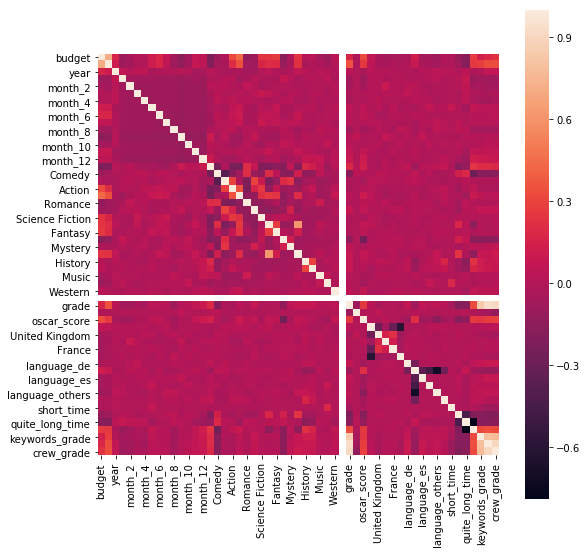

In [166]:
# Prints the correlation matrix
dataset_all.plot_correl_matrix(0)


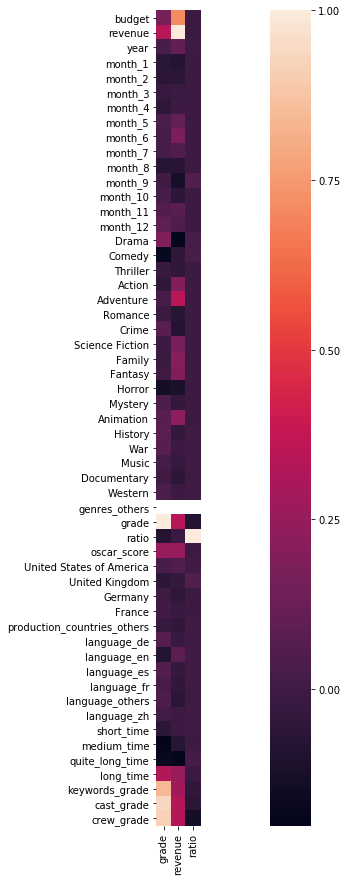

In [167]:
# Prints only the revelant columns
dataset_all.plot_par_correl_matrix(0)


In [168]:
# Prints the revelant features that we'll keep for the moment
dataset_all.print_features()


Index(['budget', 'revenue', 'year', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'Drama', 'Comedy', 'Thriller', 'Action',
       'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Family', 'Fantasy',
       'Horror', 'Mystery', 'Animation', 'History', 'War', 'Music',
       'Documentary', 'Western', 'genres_others', 'grade', 'ratio',
       'oscar_score', 'United States of America', 'United Kingdom', 'Germany',
       'France', 'production_countries_others', 'language_de', 'language_en',
       'language_es', 'language_fr', 'language_others', 'language_zh',
       'short_time', 'medium_time', 'quite_long_time', 'long_time',
       'keywords_grade', 'cast_grade', 'crew_grade'],
      dtype='object')


In [169]:
# We split our dataset into training set and testing set
# We create it for each different label
# Here there's no split of genre

X_train_r, X_test_r , y_train_r , y_test_r = dataset_all.get_ratio_data(0)
X_train_re, X_test_re , y_train_re , y_test_re = dataset_all.get_revenue_data(0)
X_train_g, X_test_g , y_train_g , y_test_g = dataset_all.get_grade_data(0)

In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor



# Class to do regression and to vizualise it easily
class Regressors :
    def __init__(self,X_train, y_train, X_test, y_test ) :
        # We'll mention in this class the regressior as an index to simplify
        # All the function will use "index" that corresponds to the respective regressor in this list
        self.regressors_name = ['Linear Regression', 'KNeighborsRegressor' ,\
                   'Stochastic Gradient Descent Regressor ' ,\
                   'Descision Tree Regression',\
                  'Random Forest Regressor',\
                  'Support Vector Regressor ']
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # List with all the different parameters of the regressors
        self.list_param = [0 for i in range (len(self.regressors_name)) ]
        # List with all the score on the testing set
        self.list_score = np.zeros((1,len(self.regressors_name)))[0]
        # List with all the score on the training set after cross validation
        self.liste_oof_score = np.zeros((1,len(self.regressors_name)))[0]
        # List of all the regressors
        self.classifiers = [0 for i in range (len(self.regressors_name)) ]
        # List of all the functions that give the classifier with the good parameters
        # We need to take into account that, as we compute the best parameters through the training set,
        # it could lead to overfitting
        # We take the risk for when we'll deal with the genre 
        self.functions = [None for i in range(len(self.regressors_name))]
        
    def get_oof_score(self,index) :
        # Returns the score after cross validation on the training set
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        oof_score = get_oof(clfr, self.X_train,self.y_train)
        self.liste_oof_score[index] = oof_score
        return oof_score
    
    def get_score(self, index) :
        # Returns the real score on the testing set
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        score = get_score(clfr,self.X_train,self.y_train,self.X_test,self.y_test) 
        self.list_score[index] = score
        return score
    
    def set_classifier(self, index, clf) :
        # Sets the classifier
        self.classifiers[index] = clf
    
    def set_param(self, index, param) :
        # Sets the parameter at a specific classifier
        
        self.list_param[index] = param
        if (self.classifiers[index] is not None ):
            self.get_oof_score(index)
            self.get_score(index)
    
    def print_classifier_scores(self, index) :
        # Prints both the score after cross validation on the training set and the score on the testing set
        if (self.list_score[index] == 0 or self.liste_oof_score[index] == 0) :
            self.get_oof_score(index)
            self.get_score(index)    
        print("Score cross validation with " + self.regressors_name[index], self.liste_oof_score[index])
        print("Score for generalization with "+ self.regressors_name[index], self.list_score[index])
        
    def set_function(self, index, func) :
        # Sets the function that will return a regressor with good parameters
        self.functions[index] = func
    
    def function(self,index) :
        # It will create the regressor with the good parameters according to some criteria 
        if self.functions[index] is not None :
            param,clf = self.functions[index](self.X_train, self.y_train, True)
            self.set_param(index,param)
            self.set_classifier(index, clf)
            print("Parameters : ",param)
            
    def set_regressors(self, liste_regressor) :
        # Sets all the regressors
        for index, x in enumerate(liste_regressor) :
            self.set_classifier(index, x)
        
    def set_functions(self,liste_function):
        # Sets all the function of the regressors
        for index, x in enumerate(liste_function) :
            self.set_function(index, x)
    
    def print_best_regressor(self) :
        # It will prints the best regressors (for the training set) and returns its score with the testing set
        index = np.argmax(self.liste_oof_score)
        answer = "Best regressor : " + str(self.regressors_name[index]) +\
        " for a score : " + str(self.list_score[index])
        return answer
    
    
    def print_all_score(self) :
        # Prints all the score on the testing set for all the regressors
        print("Score for the different regressors ")
        score_regressors = {}
        score_regressors['Score'] = self.list_score
        score_class_df = pd.DataFrame(score_regressors, index =self.regressors_name)        
        print(score_class_df)        
        sns.set_color_codes("muted")
        score_class_df['Regressors'] = self.regressors_name
        sns.barplot(x='Score', y='Regressors', data=score_class_df, color="b")
        plt.xlabel('Score')
        plt.title('Regression Score')
        plt.show()

    def plot_prediction(self,name) :
        # It takes the model that maximizes the scores
        # Then, it will plot a graph with the real values and the predicted ones 
        # On the x axis, it will be the ith instance
        index = np.argmax(self.liste_oof_score)
        clf = self.classifiers[index]
        print("Regressor chosen :",self.regressors_name[index])
        params = self.list_param[index]
        classifier = SKlearnHelper(clf=clf, params = params)
        classifier.fit(self.X_train, self.y_train)
        y_predict = classifier.predict(self.X_test)
        f, ax = plt.subplots(figsize=(8, 8))
        plt.scatter([i for i in range(len(y_predict))] ,y_predict, color='b', label="Prediction",\
                   marker='+')
        plt.scatter([i for i in range(len(y_predict))],self.y_test,color='r',label="Real Value",\
                    marker='+')
        plt.xlabel("Number of instance")
        plt.ylabel(name)
        plt.title("Comparaison of the model with the real values")
        plt.legend()
        plt.show()


<div class="alert alert-success">
Use of ratio as label for regression
</div>



In [172]:
# Creation of our Regressor class
regressors = Regressors(X_train_r, y_train_r, X_test_r, y_test_r,)

In [176]:
# List of all the regressors that we're going to use
liste_regressor =  [LinearRegression,KNeighborsRegressor,SGDRegressor,DecisionTreeRegressor,\
                   RandomForestRegressor,SVR]
# List of all the functions that return the best regressor 
liste_function = [0,get_knn, get_sgdr,get_dtr, get_rfr, 0 ]

In [177]:
# We set the previous information
regressors.set_regressors(liste_regressor)
regressors.set_functions(liste_function)

* Linear Regression

In [178]:
param_lr = {
    'normalize':False
}
regressors.set_param(0, param_lr)
# Prints the score for cross validation and for generalization
regressors.print_classifier_scores(0)

Score cross validation with Linear Regression -3.38436141637e+31
Score for generalization with Linear Regression -0.00584969506501


* KNeighborsRegressor

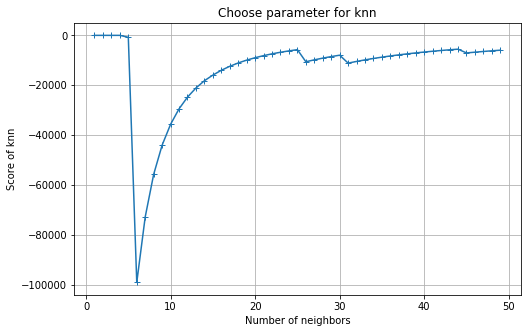

Parameters :  {'n_neighbors': 2, 'algorithm': 'auto'}


In [179]:
# Fits the best parameters for the model
regressors.function(1)


In [180]:
# We choose the best parameters in order not to overfit
param_knn = {
    'algorithm':'auto',
    'n_neighbors':50
}
regressors.set_param(1, param_knn)
regressors.print_classifier_scores(1)

Score cross validation with KNeighborsRegressor -5705.56003941
Score for generalization with KNeighborsRegressor -0.00378470911094


* Stochastic Gradient Descent Regressor 

In [181]:
# Fits the best parameters for the model
regressors.function(2)



Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -45328.828684 -45367.743915 -45321.956876
huber                           -0.009832     -0.009846     -0.009828
epsilon_insensitive             -0.007302     -0.007365     -0.007326
squared_epsilon_insensitive -50350.347984 -50368.569685 -50347.118398
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet'}


In [182]:
# Prints the results
regressors.print_classifier_scores(2)

Score cross validation with Stochastic Gradient Descent Regressor  -0.00730207625638
Score for generalization with Stochastic Gradient Descent Regressor  -0.00307202399894


* Descision Tree Regression 

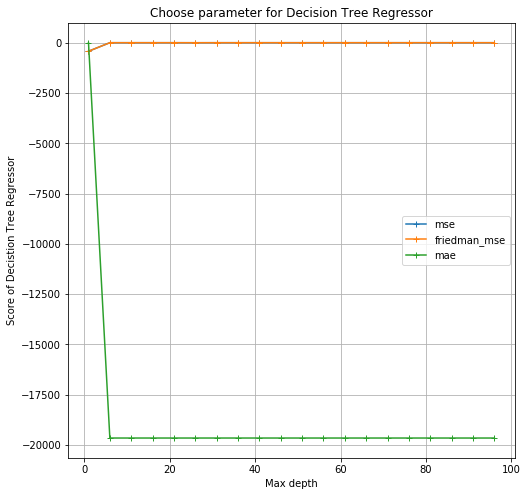

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}


In [183]:
# Fits the best parameters for the model
regressors.function(3)  

In [185]:
# Prints the results
regressors.print_classifier_scores(3)

Score cross validation with Descision Tree Regression -0.0126314462969
Score for generalization with Descision Tree Regression -0.00307214811206


* RandomForestRegressor

Max depth : 5
Number of estimators : 2


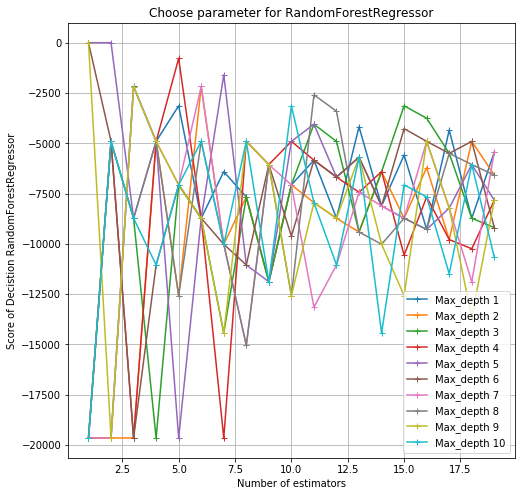

Parameters :  {'max_depth': 5, 'n_estimators': 2, 'max_features': 'auto'}


In [186]:
# Fits the best parameters for the model
regressors.function(4)

In [187]:
param_rfr = {
    'n_estimators': 7, 'max_features': 'auto', 'random_state': 1, 'max_depth': 1
}
regressors.set_param(4, param_rfr)

In [188]:
# Prints the results
regressors.print_classifier_scores(4)

Score cross validation with Random Forest Regressor -10022.5762306
Score for generalization with Random Forest Regressor -0.0030683895803


* Support Vector Regression

In [189]:
# Use of a linear SVR 
param_svr = {
    'kernel':'linear'
}
regressors.set_param(5,param_svr)



In [190]:
# Prints the results
regressors.print_classifier_scores(5)

Score cross validation with Support Vector Regressor  -0.00756573072369
Score for generalization with Support Vector Regressor  -0.00307214957988


Score for the different regressors 
                                           Score
Linear Regression                      -0.005850
KNeighborsRegressor                    -0.003785
Stochastic Gradient Descent Regressor  -0.003072
Descision Tree Regression              -0.003072
Random Forest Regressor                -0.003068
Support Vector Regressor               -0.003072


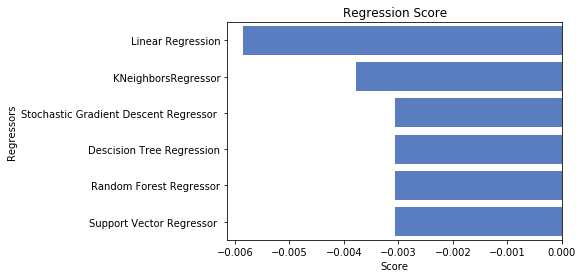

In [191]:
# Prints all the results together
regressors.print_all_score()

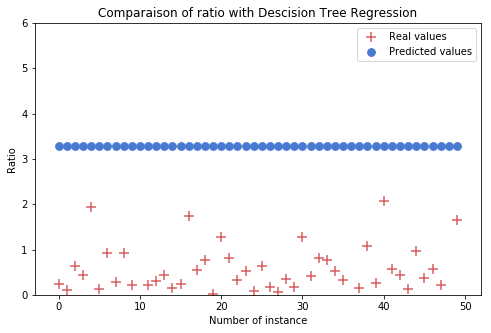

In [193]:
# A simple plot of the predicted outputs and the real ones to see the differences
# We use the best regressor to plot the predicted outputs
plot_predict_real(regressors, 50, "Ratio", "Descision Tree Regression", [0,6],4)

<div class="alert alert-success">
Use of revenue as label for regression
</div>


In [194]:
# Creates a Regressor instance to to regression with the revenue
regressor_revenue = Regressors(X_train_re, y_train_re, X_test_re, y_test_re,)

In [195]:
# Set the regressors and the functions that compute the best parameters for each regressor
regressor_revenue.set_regressors(liste_regressor)
regressor_revenue.set_functions(liste_function)

* Linear Regression


In [196]:

param_lr = {
    'normalize':False
}
regressor_revenue.set_param(0, param_lr)
regressor_revenue.print_classifier_scores(0)


Score cross validation with Linear Regression -4.65053647201e+25
Score for generalization with Linear Regression 0.596142016054


* KNeighborsRegressor


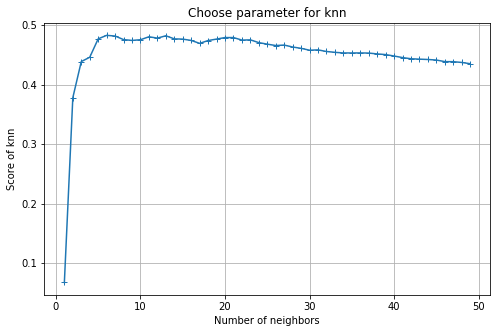

Parameters :  {'n_neighbors': 6, 'algorithm': 'auto'}


In [197]:
# Computes the best k parameter
regressor_revenue.function(1)


In [198]:
# We choose the best parameters in order to not overfit

regressor_revenue.set_param(1, param_knn)
regressor_revenue.print_classifier_scores(1)


Score cross validation with KNeighborsRegressor 0.434837403905
Score for generalization with KNeighborsRegressor 0.480567396662


* Stochastic Gradient Descent Regressor 


In [200]:
# Computes the best loss and penalty functions
regressor_revenue.function(2)
regressor_revenue.print_classifier_scores(2)


Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.540965  0.540892  0.540978
huber                         -0.487583 -0.487583 -0.487583
epsilon_insensitive           -0.487580 -0.487580 -0.487580
squared_epsilon_insensitive    0.540631  0.540570  0.540642
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.540977967586
Score for generalization with Stochastic Gradient Descent Regressor  -0.204884468699



* Descision Tree Regression 


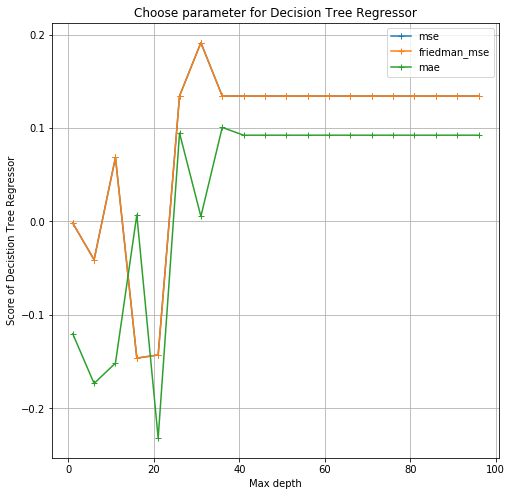

Parameters :  {'max_depth': 31, 'max_features': 'log2', 'criterion': 'mse', 'random_state': 1}


In [201]:
# Computes the best number of max depth
regressor_revenue.function(3)

In [202]:
regressor_revenue.print_classifier_scores(3)

Score cross validation with Descision Tree Regression 0.191362092428
Score for generalization with Descision Tree Regression 0.20408109929



* RandomForestRegressor

Max depth : 7
Number of estimators : 19


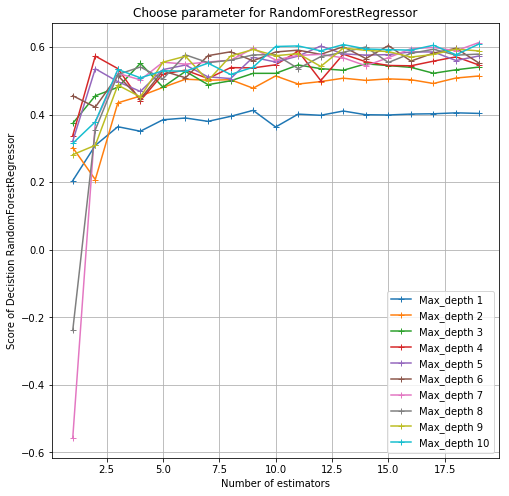

Parameters :  {'max_depth': 7, 'n_estimators': 19, 'max_features': 'auto'}


In [203]:
# Computes the best number of max depth and the number of estimators
regressor_revenue.function(4)


In [204]:
param_rfr_re = {
    'max_depth':6,
    'random_state':1,
    'max_features':'auto',
    'n_estimators':10
    
}
regressor_revenue.set_param(4,param_rfr_re)

In [205]:

regressor_revenue.print_classifier_scores(4)


Score cross validation with Random Forest Regressor 0.539407451719
Score for generalization with Random Forest Regressor 0.579135254123


* Support Vector Regression


In [206]:

param_svr = {
    'kernel':'linear'
}
regressor_revenue.set_param(5,param_svr)
regressor_revenue.print_classifier_scores(5)


Score cross validation with Support Vector Regressor  -0.129109917106
Score for generalization with Support Vector Regressor  -0.141215460365


Score for the different regressors 
                                           Score
Linear Regression                       0.596142
KNeighborsRegressor                     0.480567
Stochastic Gradient Descent Regressor  -0.204884
Descision Tree Regression               0.204081
Random Forest Regressor                 0.579135
Support Vector Regressor               -0.141215


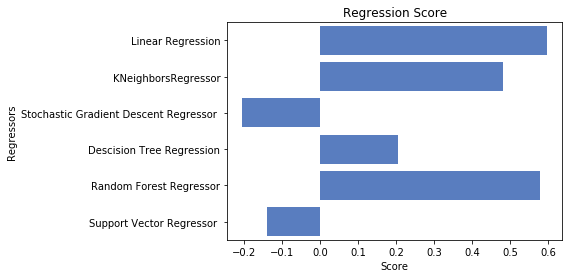

In [207]:
regressor_revenue.print_all_score()

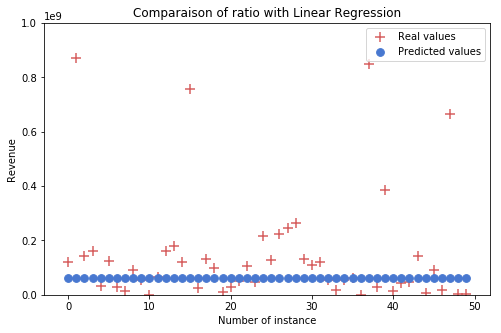

In [209]:
# Plots the predicted versus the real values for the 50 first ones


plot_predict_real(regressor_revenue, 50, "Revenue","Linear Regression",\
                  [0,10**9],5)




<div class="alert alert-success">
Use of grade as label for regression
</div>


In [210]:
# Initialization
regressor_grade = Regressors(X_train_g, y_train_g, X_test_g, y_test_g)

In [211]:
# Makes the function and the parameters initialisation
regressor_grade.set_regressors(liste_regressor)
regressor_grade.set_functions(liste_function)

* Linear Regression


In [230]:

param_lr = {
    'normalize':False
}
regressor_grade.set_param(0, param_lr)
regressor_grade.print_classifier_scores(0)


Score cross validation with Linear Regression -4.73292486421e+25
Score for generalization with Linear Regression 0.897937082503



* KNeighborsRegressor

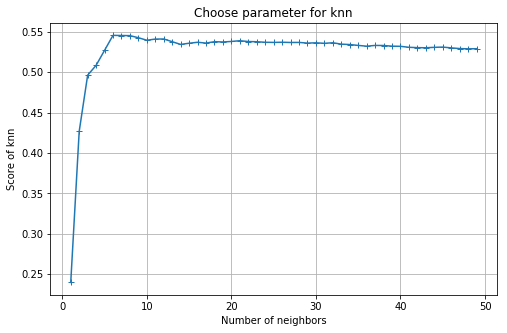

Parameters :  {'n_neighbors': 6, 'algorithm': 'auto'}


In [213]:

regressor_grade.function(1)


In [214]:

regressor_grade.print_classifier_scores(1)


Score cross validation with KNeighborsRegressor 0.545644058078
Score for generalization with KNeighborsRegressor 0.517789940942


* Stochastic Gradient Descent Regressor 



In [215]:

regressor_grade.function(2)



Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.891992  0.892649  0.891872
huber                          0.653761  0.663404  0.656123
epsilon_insensitive            0.891009  0.892263  0.891262
squared_epsilon_insensitive    0.890102  0.890818  0.889967
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l1'}


In [216]:
regressor_grade.print_classifier_scores(2)



Score cross validation with Stochastic Gradient Descent Regressor  0.892649152183
Score for generalization with Stochastic Gradient Descent Regressor  -18.3352222661




* Descision Tree Regression 


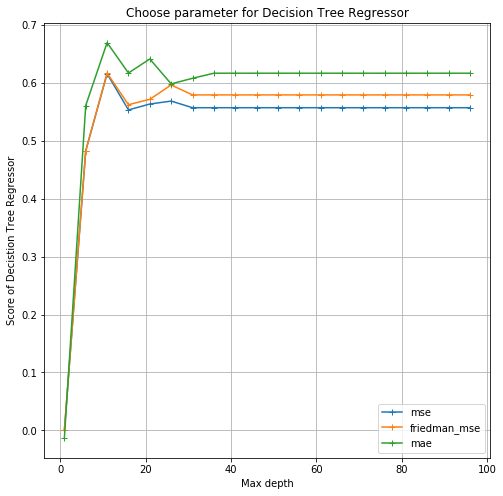

Parameters :  {'max_depth': 11, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}


In [217]:
regressor_grade.function(3)       


In [218]:
regressor_grade.print_classifier_scores(3)


Score cross validation with Descision Tree Regression 0.669250877947
Score for generalization with Descision Tree Regression 0.727510823359



* RandomForestRegressor


Max depth : 10
Number of estimators : 12


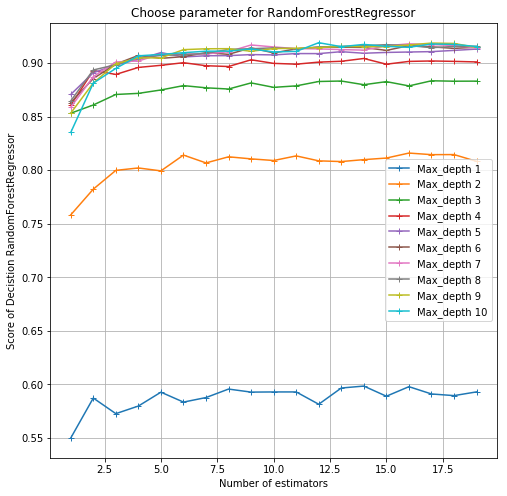

Parameters :  {'max_depth': 10, 'n_estimators': 12, 'max_features': 'auto'}


In [219]:

regressor_grade.function(4)


In [220]:

param_rfr_re = {
    'max_depth':5,
    'random_state':1,
    'max_features':'auto',
    'n_estimators':5
    
}
regressor_grade.set_param(4,param_rfr_re)


regressor_grade.print_classifier_scores(4)


Score cross validation with Random Forest Regressor 0.905975541996
Score for generalization with Random Forest Regressor 0.884096884098



* Support Vector Regression


In [221]:

param_svr = {
    'kernel':'linear'
}
regressor_grade.set_param(5,param_svr)
regressor_grade.print_classifier_scores(5)


Score cross validation with Support Vector Regressor  0.917734579327
Score for generalization with Support Vector Regressor  0.89619045


Score for the different regressors 
                                            Score
Linear Regression                        0.897937
KNeighborsRegressor                      0.517790
Stochastic Gradient Descent Regressor  -18.335222
Descision Tree Regression                0.727511
Random Forest Regressor                  0.884097
Support Vector Regressor                 0.896190


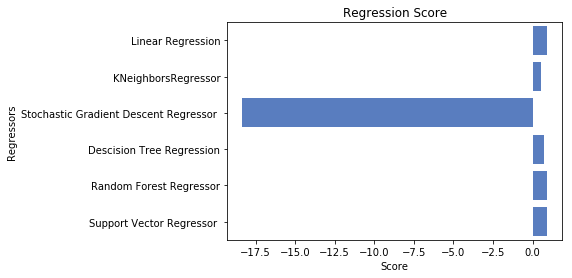

In [227]:
# Prints all the previous results 
regressor_grade.print_all_score()


Regressor chosen : Support Vector Regressor 


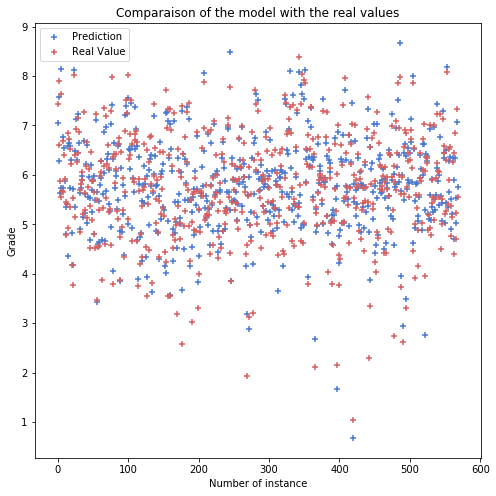

In [228]:
regressor_grade.plot_prediction("Grade")

<div class="alert alert-success">
We'll then split our data into genre sets
</div>


In [232]:
# Creates a new preprocess in order to create the split by genre
pre_process_genre = Preprocess(data)
# Splits by genre : we only keep the 8 first genres
pre_process_genre.split_by_genre(8)
# We split it into train and test
pre_process_genre.split_train_test()

['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction']


In [233]:
# Computes the keywords_grade, cast_grade and crew_grade
pre_process_genre.compute_grade(liste_all_grade)

In [234]:
# Creates the dataset to remove some features and normalize
dataset_genre = Dataset(pre_process_genre)
# Creates the three labels : ratio, revenue and grade
dataset_genre.set_sets()
# Normalization
dataset_genre.normalize()


Genre :  Drama


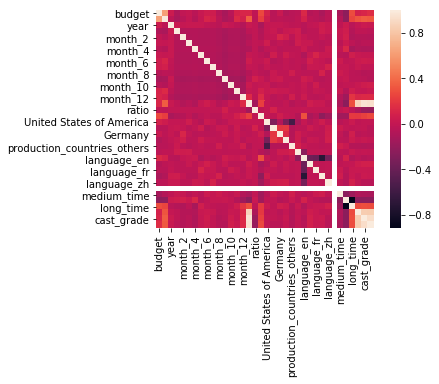

Genre :  Comedy


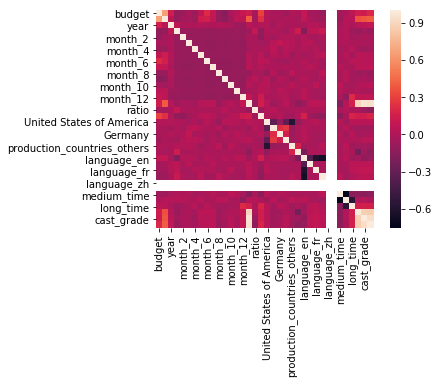

Genre :  Thriller


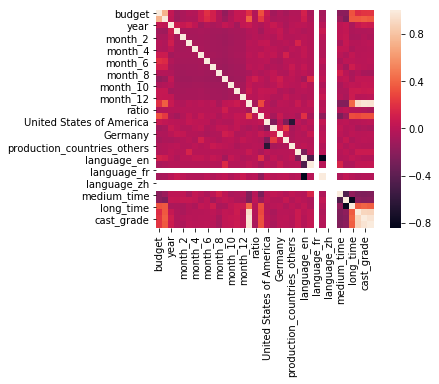

Genre :  Action


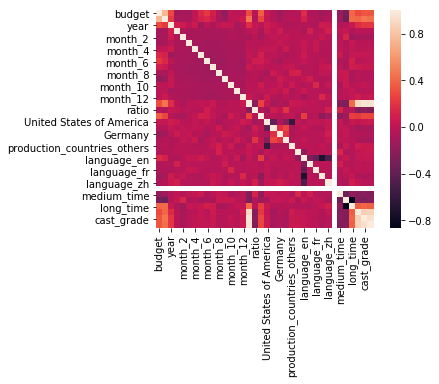

Genre :  Adventure


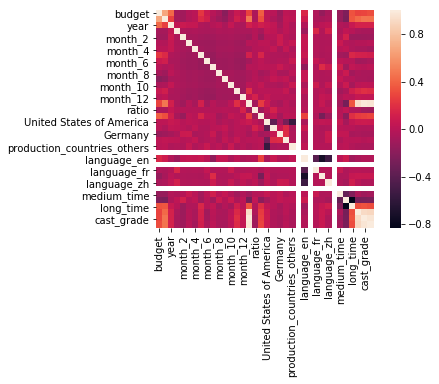

Genre :  Romance


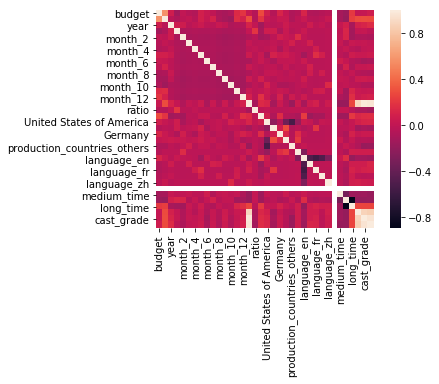

Genre :  Crime


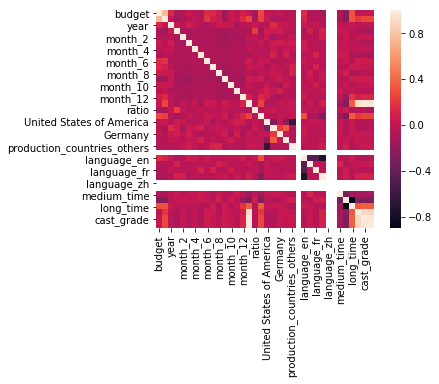

Genre :  Science Fiction


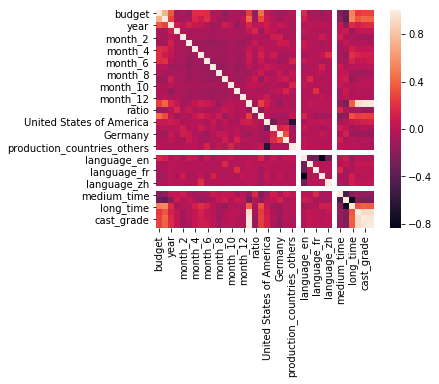

In [235]:
# List of all the genre used
liste_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance','Crime',\
               'Science Fiction']

# List of the values of the correlation matrix by genre
liste_corr_genre = [dataset_genre.pre_process.train[i].corr() for i in range(len(liste_genres))] 
# We plot the different matrix correlation
for index, x in enumerate(liste_corr_genre) :
    print("Genre : ",liste_genres[index])
    sns.heatmap(x, vmax=1, square=True)
    plt.show()
    
        
        

In [236]:
def compare_genre_regression(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_regressors = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_grade_data(i)
        print(liste_genres[i])
        regressor = Regressors(X_train, y_train, X_test, y_test)
        regressor.set_regressors(liste_regressor)
        regressor.set_functions(liste_function)
        param_lr = {
            'normalize':False
        }
        regressor.set_param(0, param_lr)
        param_svr = {
            'kernel':'linear'
        }
        regressor.set_param(5,param_svr)
        for j in range(len(liste_regressor)) :
            if not(j == 0 or  j == 5) :
                regressor.function(j)
                regressor.print_classifier_scores(j)
        print("For regressor : ", liste_genres[i])
        regressor.print_all_score()
        liste_regressors.append(regressor)
        answer.append(regressor.print_best_regressor())
    return answer , liste_regressors


Drama


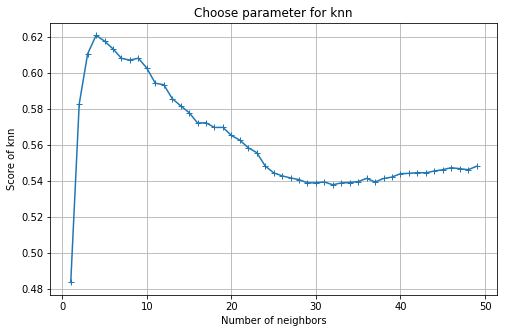

Parameters :  {'n_neighbors': 4, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.620938590867
Score for generalization with KNeighborsRegressor 0.582212499362
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.869921  0.870225  0.869865
huber                         -0.436110 -0.423332 -0.438528
epsilon_insensitive            0.874052  0.874384  0.874099
squared_epsilon_insensitive    0.868274  0.868527  0.868228
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.87438365578
Score for generalization with Stochastic Gradient Descent Regressor  0.885517043558


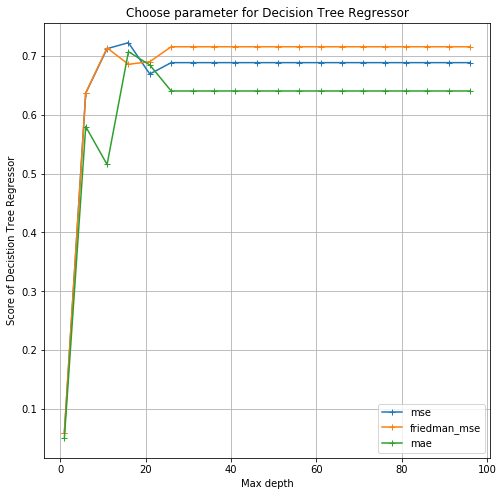

Parameters :  {'max_depth': 16, 'max_features': 'log2', 'criterion': 'mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.722539403882
Score for generalization with Descision Tree Regression 0.663018306206
Max depth : 7
Number of estimators : 19


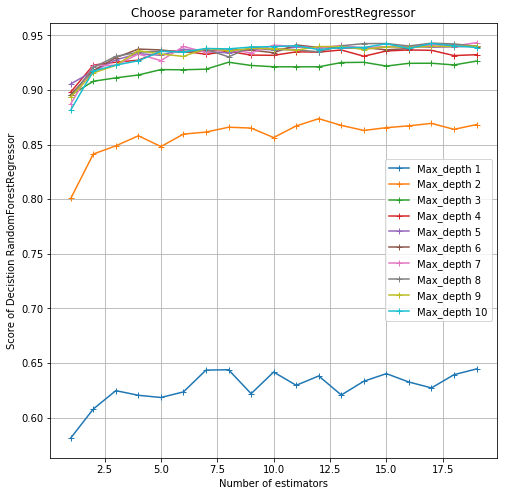

Parameters :  {'max_depth': 7, 'n_estimators': 19, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.940324328739
Score for generalization with Random Forest Regressor 0.87531094603
For regressor :  Drama
Score for the different regressors 
                                           Score
Linear Regression                       0.887187
KNeighborsRegressor                     0.582212
Stochastic Gradient Descent Regressor   0.885517
Descision Tree Regression               0.663018
Random Forest Regressor                 0.875311
Support Vector Regressor                0.889981


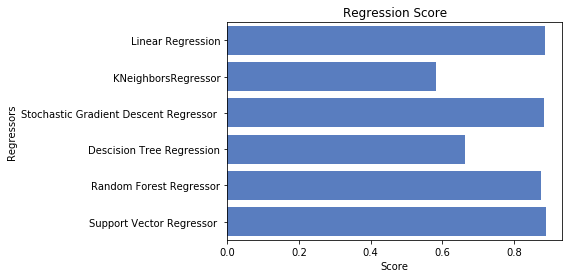

Comedy


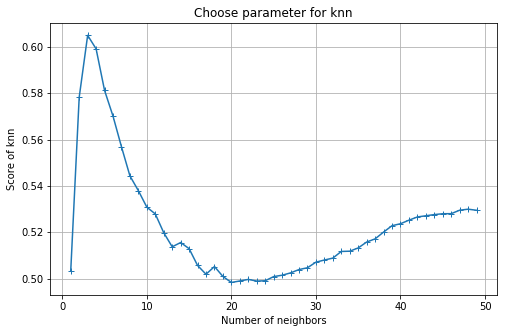

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.604904507203
Score for generalization with KNeighborsRegressor 0.617218728048
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.625834  0.627015  0.625625
huber                         -1.475825 -1.447774 -1.484548
epsilon_insensitive            0.623831  0.625685  0.623054
squared_epsilon_insensitive    0.627329  0.628304  0.627156
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.628303891785
Score for generalization with Stochastic Gradient Descent Regressor  0.802134985459


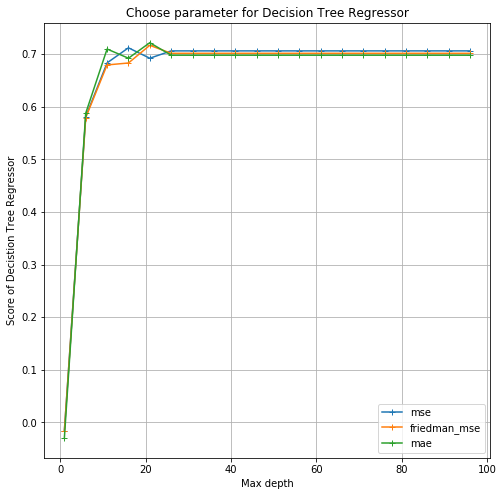

Parameters :  {'max_depth': 21, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.721408085644
Score for generalization with Descision Tree Regression 0.193675035356
Max depth : 6
Number of estimators : 16


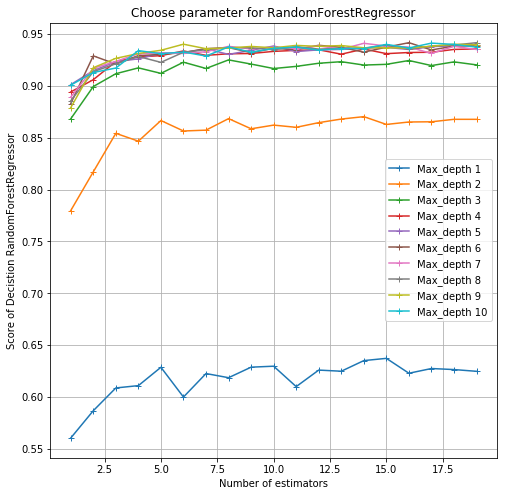

Parameters :  {'max_depth': 6, 'n_estimators': 16, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.937824283501
Score for generalization with Random Forest Regressor 0.761186035364
For regressor :  Comedy
Score for the different regressors 
                                           Score
Linear Regression                       0.791287
KNeighborsRegressor                     0.617219
Stochastic Gradient Descent Regressor   0.802135
Descision Tree Regression               0.193675
Random Forest Regressor                 0.761186
Support Vector Regressor                0.787074


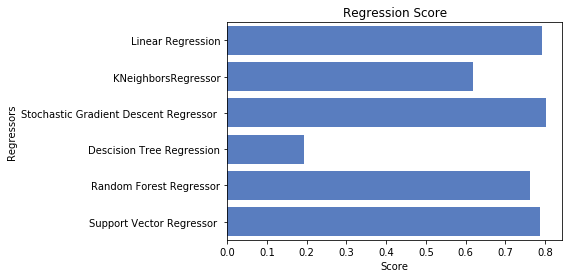

Thriller


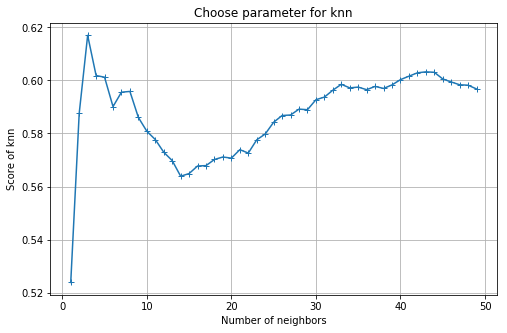

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.616968272487
Score for generalization with KNeighborsRegressor 0.609955428178
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.752459  0.753257  0.752319
huber                         -2.669916 -2.632099 -2.674477
epsilon_insensitive            0.757692  0.758816  0.757763
squared_epsilon_insensitive    0.756671  0.757274  0.756565
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.758816380008
Score for generalization with Stochastic Gradient Descent Regressor  0.483955573186


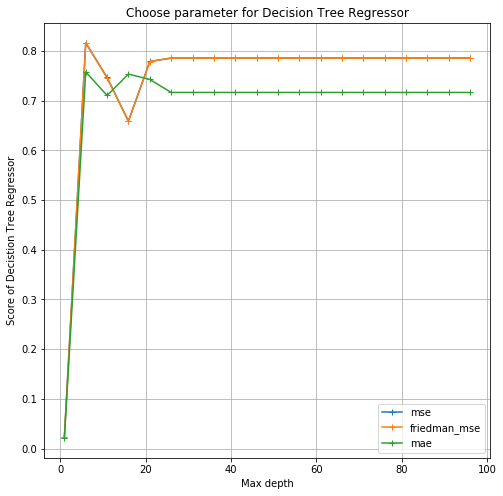

Parameters :  {'max_depth': 6, 'max_features': 'log2', 'criterion': 'friedman_mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.816525639286
Score for generalization with Descision Tree Regression 0.646939715892
Max depth : 6
Number of estimators : 13


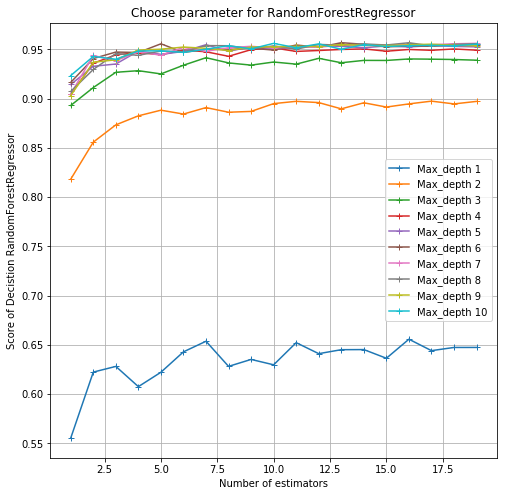

Parameters :  {'max_depth': 6, 'n_estimators': 13, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.953009170856
Score for generalization with Random Forest Regressor 0.893356079555
For regressor :  Thriller
Score for the different regressors 
                                               Score
Linear Regression                      -8.460318e+22
KNeighborsRegressor                     6.099554e-01
Stochastic Gradient Descent Regressor   4.839556e-01
Descision Tree Regression               6.469397e-01
Random Forest Regressor                 8.933561e-01
Support Vector Regressor                8.760943e-01


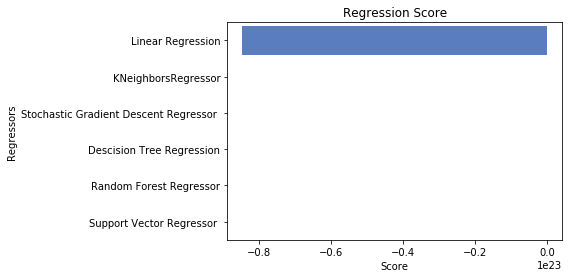

Action


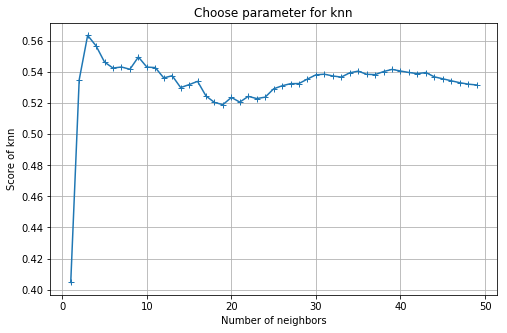

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.563577946796
Score for generalization with KNeighborsRegressor 0.599016016625
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.338761  0.340410  0.338468
huber                         -3.417275 -3.372612 -3.421174
epsilon_insensitive            0.351544  0.353832  0.351096
squared_epsilon_insensitive   -0.314710 -0.306921 -0.316088
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.353831522681
Score for generalization with Stochastic Gradient Descent Regressor  0.864991387963


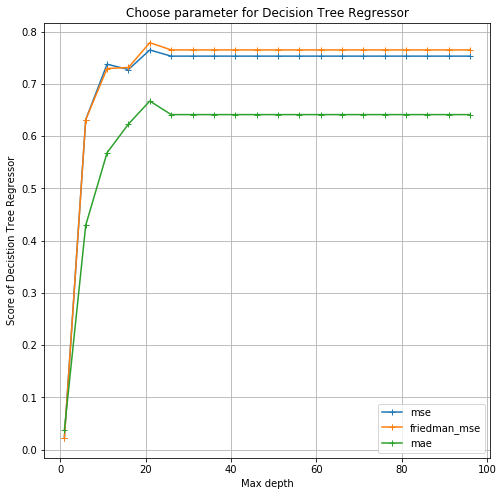

Parameters :  {'max_depth': 21, 'max_features': 'log2', 'criterion': 'friedman_mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.778836641194
Score for generalization with Descision Tree Regression 0.535900286239
Max depth : 10
Number of estimators : 16


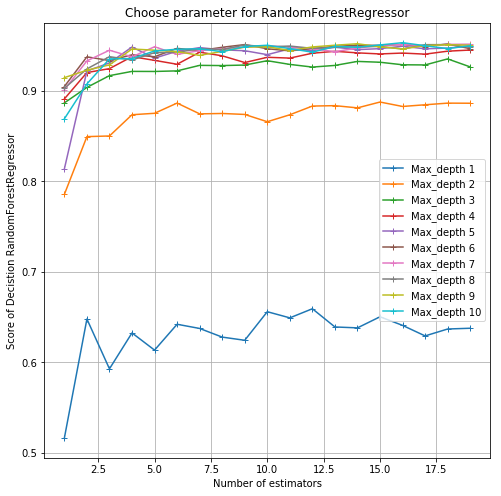

Parameters :  {'max_depth': 10, 'n_estimators': 16, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.944984500295
Score for generalization with Random Forest Regressor 0.872750193134
For regressor :  Action
Score for the different regressors 
                                           Score
Linear Regression                       0.853269
KNeighborsRegressor                     0.599016
Stochastic Gradient Descent Regressor   0.864991
Descision Tree Regression               0.535900
Random Forest Regressor                 0.872750
Support Vector Regressor                0.856394


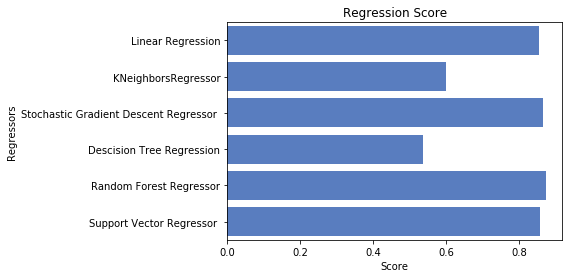

Adventure


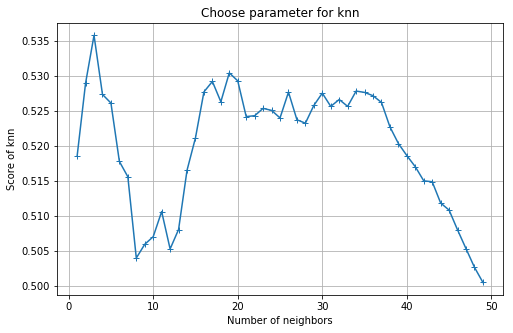

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.535812020848
Score for generalization with KNeighborsRegressor 0.56583452043
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                  -0.432752 -0.431223 -0.433024
huber                         -5.551288 -5.508371 -5.556638
epsilon_insensitive           -0.490146 -0.512433 -0.463462
squared_epsilon_insensitive   -0.440009 -0.439503 -0.440207
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.431223154603
Score for generalization with Stochastic Gradient Descent Regressor  0.593183880475


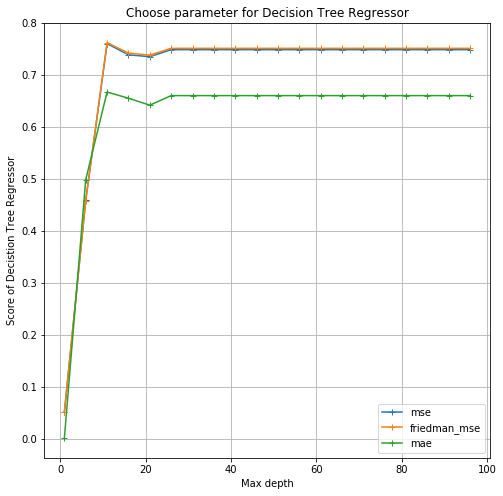

Parameters :  {'max_depth': 11, 'max_features': 'log2', 'criterion': 'friedman_mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.762272571884
Score for generalization with Descision Tree Regression 0.686794039006
Max depth : 8
Number of estimators : 16


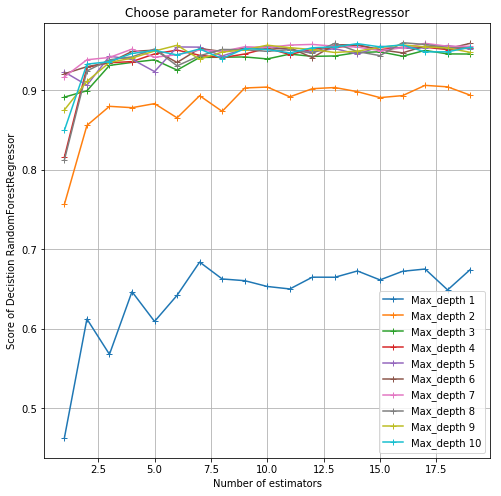

Parameters :  {'max_depth': 8, 'n_estimators': 16, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.950474494095
Score for generalization with Random Forest Regressor 0.852362432249
For regressor :  Adventure
Score for the different regressors 
                                               Score
Linear Regression                      -3.307281e+23
KNeighborsRegressor                     5.658345e-01
Stochastic Gradient Descent Regressor   5.931839e-01
Descision Tree Regression               6.867940e-01
Random Forest Regressor                 8.523624e-01
Support Vector Regressor                8.312580e-01


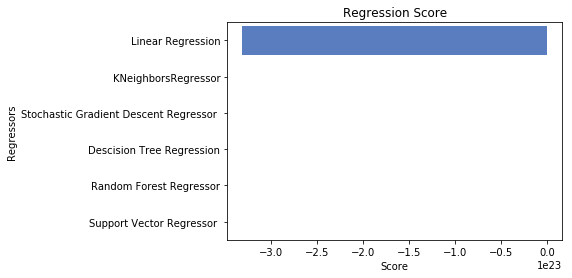

Romance


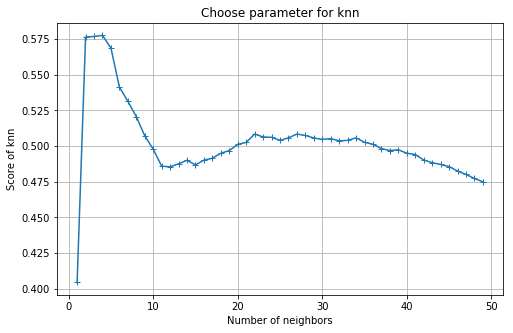

Parameters :  {'n_neighbors': 4, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.577733942599
Score for generalization with KNeighborsRegressor 0.538916267593
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.387896  0.389368  0.387637
huber                         -5.340982 -5.299338 -5.348795
epsilon_insensitive            0.383663  0.387857  0.386266
squared_epsilon_insensitive    0.395277  0.396340  0.395091
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.396339721628
Score for generalization with Stochastic Gradient Descent Regressor  0.841167595834


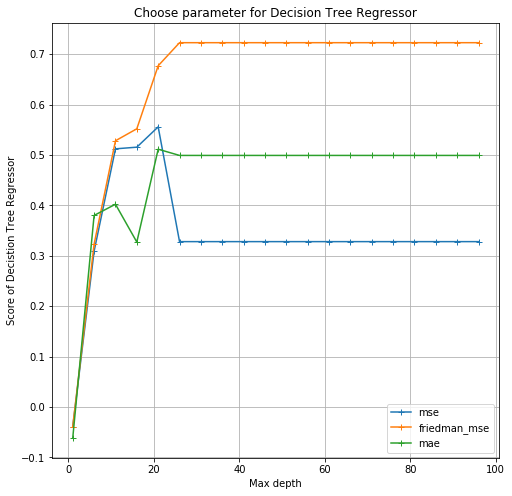

Parameters :  {'max_depth': 26, 'max_features': 'log2', 'criterion': 'friedman_mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.722818252662
Score for generalization with Descision Tree Regression 0.736571843075
Max depth : 9
Number of estimators : 19


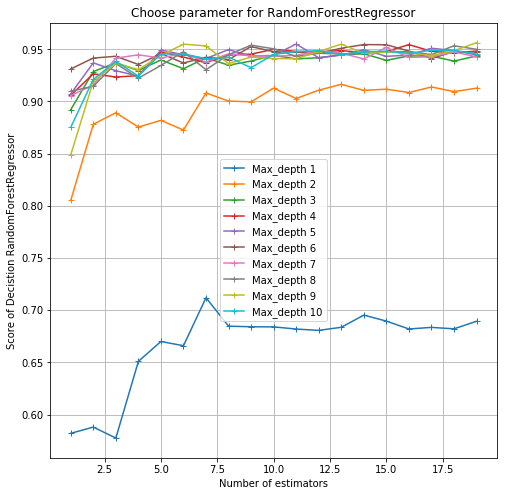

Parameters :  {'max_depth': 9, 'n_estimators': 19, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.945250809328
Score for generalization with Random Forest Regressor 0.835091458052
For regressor :  Romance
Score for the different regressors 
                                           Score
Linear Regression                       0.841449
KNeighborsRegressor                     0.538916
Stochastic Gradient Descent Regressor   0.841168
Descision Tree Regression               0.736572
Random Forest Regressor                 0.835091
Support Vector Regressor                0.830463


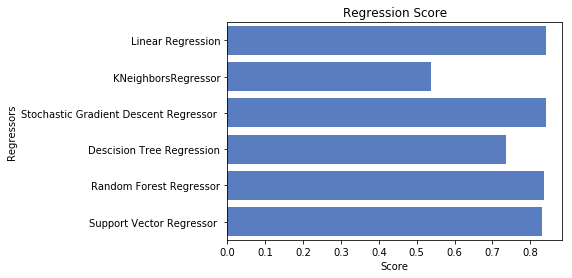

Crime


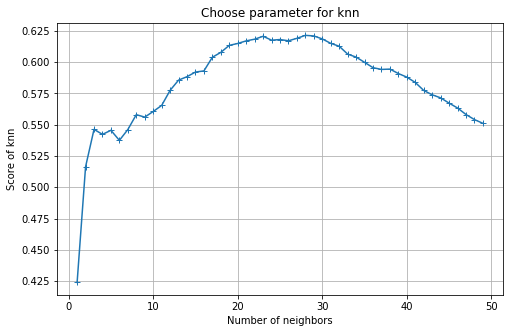

Parameters :  {'n_neighbors': 28, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.621285929024
Score for generalization with KNeighborsRegressor 0.448601717225
Score for different parameters : 
                             elasticnet         l1         l2
squared_loss                   0.453379   0.454524   0.453178
huber                        -14.250505 -14.181918 -14.256169
epsilon_insensitive            0.421755   0.438632   0.438758
squared_epsilon_insensitive    0.451860   0.452686   0.451700
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.454524280355
Score for generalization with Stochastic Gradient Descent Regressor  0.806101287371


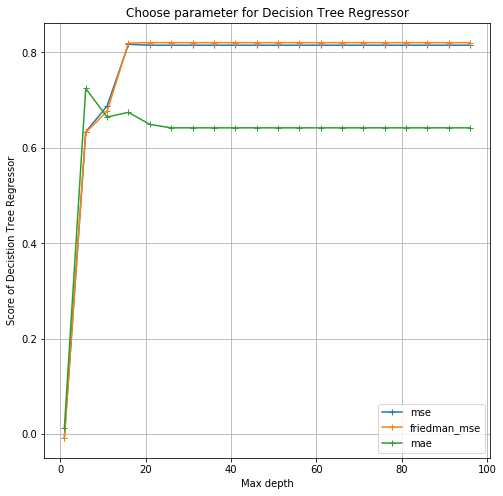

Parameters :  {'max_depth': 21, 'max_features': 'log2', 'criterion': 'friedman_mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.820322269468
Score for generalization with Descision Tree Regression 0.78477764083
Max depth : 8
Number of estimators : 17


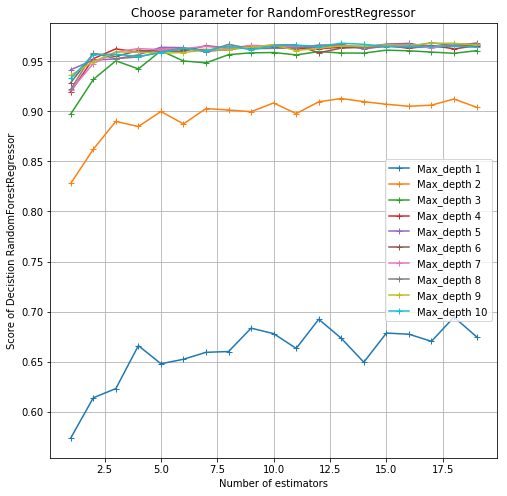

Parameters :  {'max_depth': 8, 'n_estimators': 17, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.962579058725
Score for generalization with Random Forest Regressor 0.793702325981
For regressor :  Crime
Score for the different regressors 
                                           Score
Linear Regression                       0.802587
KNeighborsRegressor                     0.448602
Stochastic Gradient Descent Regressor   0.806101
Descision Tree Regression               0.784778
Random Forest Regressor                 0.793702
Support Vector Regressor                0.797643


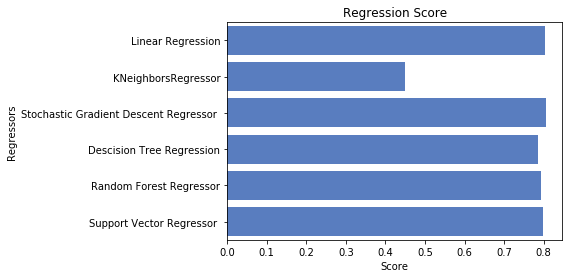

Science Fiction


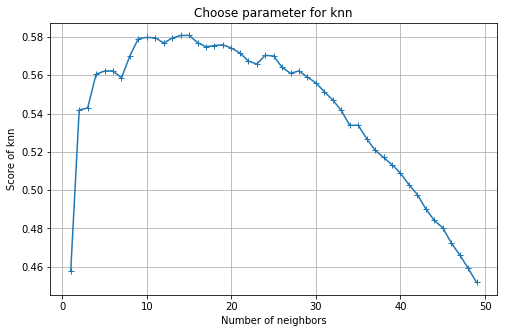

Parameters :  {'n_neighbors': 15, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.580800490604
Score for generalization with KNeighborsRegressor 0.390179387592
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.565382  0.566713  0.565147
huber                         -7.893930 -7.902038 -7.893280
epsilon_insensitive            0.597120  0.608355  0.602543
squared_epsilon_insensitive    0.579234  0.580174  0.579069
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.608354792148
Score for generalization with Stochastic Gradient Descent Regressor  0.856457993529


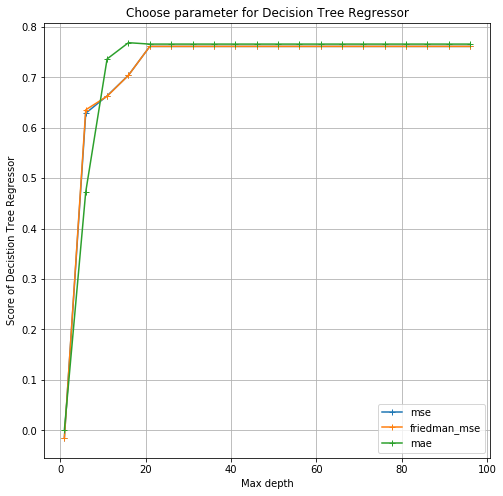

Parameters :  {'max_depth': 16, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.768491374966
Score for generalization with Descision Tree Regression 0.73118675701
Max depth : 8
Number of estimators : 5


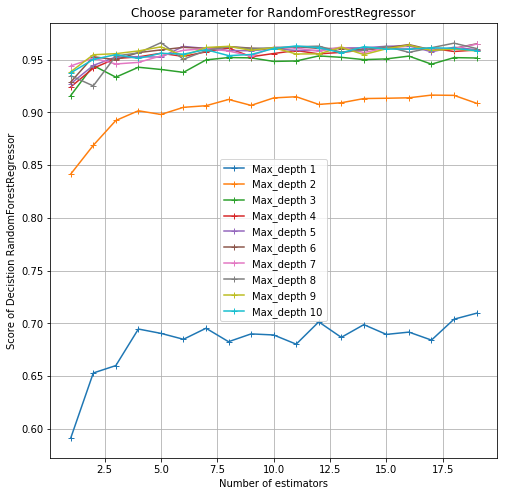

Parameters :  {'max_depth': 8, 'n_estimators': 5, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.959905066956
Score for generalization with Random Forest Regressor 0.857903386861
For regressor :  Science Fiction
Score for the different regressors 
                                           Score
Linear Regression                       0.858051
KNeighborsRegressor                     0.390179
Stochastic Gradient Descent Regressor   0.856458
Descision Tree Regression               0.731187
Random Forest Regressor                 0.857903
Support Vector Regressor                0.857408


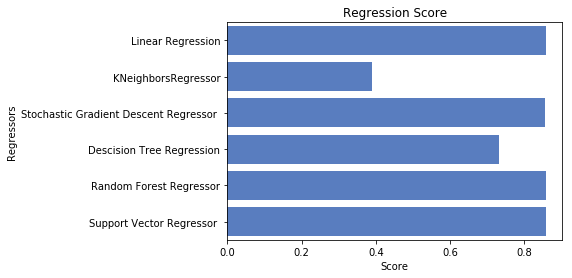

In [237]:
answer_grade, regressors_genre_grade = compare_genre_regression(liste_genres, dataset_genre)

In [238]:
print(answer_grade)

['Best regressor : Support Vector Regressor  for a score : 0.88998094184', 'Best regressor : Support Vector Regressor  for a score : 0.787074470128', 'Best regressor : Random Forest Regressor for a score : 0.893356079555', 'Best regressor : Support Vector Regressor  for a score : 0.856394365311', 'Best regressor : Support Vector Regressor  for a score : 0.831258042615', 'Best regressor : Support Vector Regressor  for a score : 0.830463459872', 'Best regressor : Support Vector Regressor  for a score : 0.797642507722', 'Best regressor : Support Vector Regressor  for a score : 0.857407882333']


In [239]:
# It will plot the regressors, score for each genre
def plot_graph_genre(regressors,liste_genres) :
    liste_max_score = []
    liste_name_reg = []
    for index, regressor in enumerate(regressors) :
        max_score = np.max(regressor.list_score)
        index_max = np.argmax(regressor.list_score)
        name_reg = regressor.regressors_name[index_max]
        liste_max_score.append(max_score)
        liste_name_reg.append(name_reg)
    
    score_regressors = {}
    score_regressors['Score'] = liste_max_score
    score_regressors['Regressor used'] = liste_name_reg
    score_class_df = pd.DataFrame(score_regressors, index =liste_genres)        
    print(score_class_df)            


In [240]:
plot_graph_genre(regressors_genre_grade,liste_genres)

                                         Regressor used     Score
Drama                         Support Vector Regressor   0.889981
Comedy           Stochastic Gradient Descent Regressor   0.802135
Thriller                        Random Forest Regressor  0.893356
Action                          Random Forest Regressor  0.872750
Adventure                       Random Forest Regressor  0.852362
Romance                               Linear Regression  0.841449
Crime            Stochastic Gradient Descent Regressor   0.806101
Science Fiction                       Linear Regression  0.858051


In [242]:
def compare_genre_regression_re(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_regressors = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_revenue_data(i)
        print(liste_genres[i])
        regressor = Regressors(X_train, y_train, X_test, y_test)
        regressor.set_regressors(liste_regressor)
        regressor.set_functions(liste_function)
        param_lr = {
            'normalize':False
        }
        regressor.set_param(0, param_lr)
        param_svr = {
            'kernel':'linear'
        }
        regressor.set_param(5,param_svr)
        for j in range(len(liste_regressor)) :
            if not(j == 0 or  j == 5) :
                regressor.function(j)
                regressor.print_classifier_scores(j)
        print("For regressor : ", liste_genres[i])
        regressor.print_all_score()
        liste_regressors.append(regressor)
        answer.append(regressor.print_best_regressor())
    return answer , liste_regressors


Drama


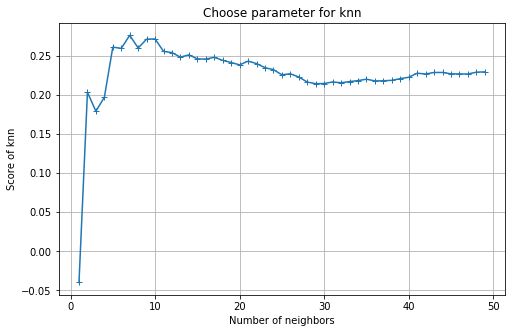

Parameters :  {'n_neighbors': 7, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.276188660794
Score for generalization with KNeighborsRegressor 0.225081515189
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.440491  0.440452  0.440497
huber                         -0.485631 -0.485631 -0.485631
epsilon_insensitive           -0.485628 -0.485628 -0.485628
squared_epsilon_insensitive    0.442051  0.442022  0.442056
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.442056428303
Score for generalization with Stochastic Gradient Descent Regressor  0.355761392875


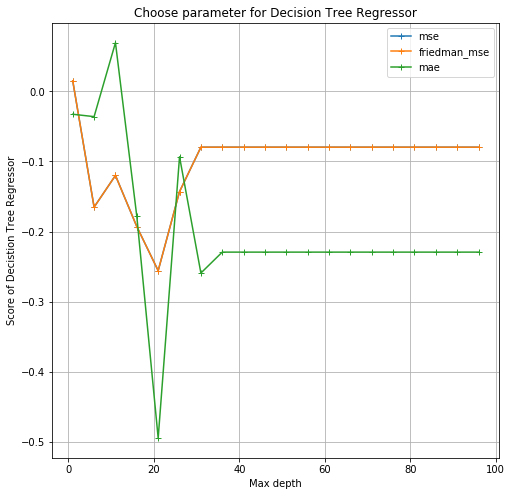

Parameters :  {'max_depth': 11, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.0693126363528
Score for generalization with Descision Tree Regression 0.183670336165
Max depth : 4
Number of estimators : 19


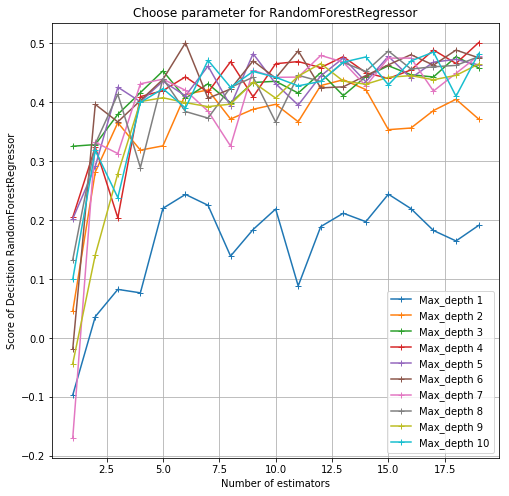

Parameters :  {'max_depth': 4, 'n_estimators': 19, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.464888119649
Score for generalization with Random Forest Regressor 0.387799913812
For regressor :  Drama
Score for the different regressors 
                                           Score
Linear Regression                       0.348268
KNeighborsRegressor                     0.225082
Stochastic Gradient Descent Regressor   0.355761
Descision Tree Regression               0.183670
Random Forest Regressor                 0.387800
Support Vector Regressor               -0.124188


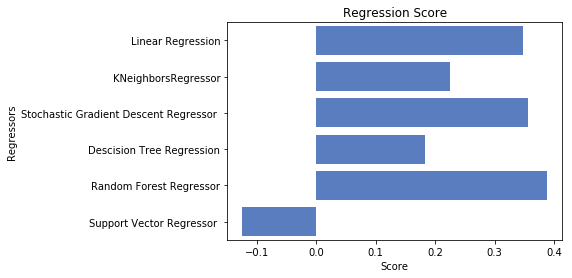

Comedy


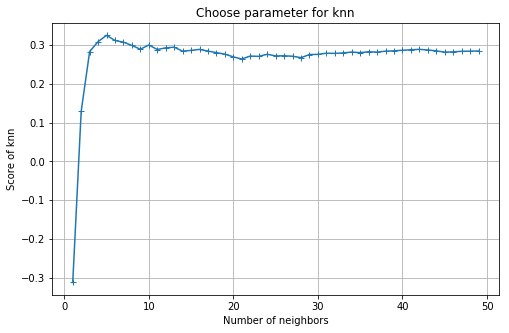

Parameters :  {'n_neighbors': 5, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.325393438035
Score for generalization with KNeighborsRegressor 0.365895467721
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.488948  0.488592  0.489009
huber                         -0.653976 -0.653976 -0.653976
epsilon_insensitive           -0.653974 -0.653974 -0.653974
squared_epsilon_insensitive    0.489360  0.489009  0.489420
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.489419909028
Score for generalization with Stochastic Gradient Descent Regressor  0.404550569101


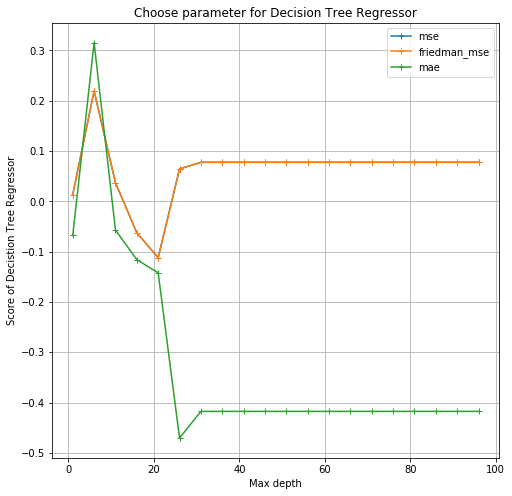

Parameters :  {'max_depth': 6, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.315208234782
Score for generalization with Descision Tree Regression 0.353538556045
Max depth : 5
Number of estimators : 17


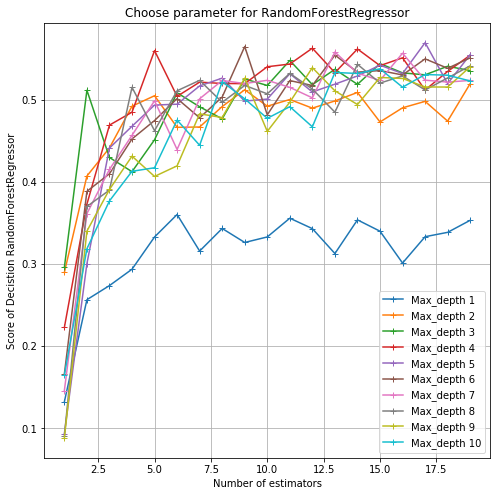

Parameters :  {'max_depth': 5, 'n_estimators': 17, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.54215084443
Score for generalization with Random Forest Regressor 0.430399302724
For regressor :  Comedy
Score for the different regressors 
                                           Score
Linear Regression                       0.404624
KNeighborsRegressor                     0.365895
Stochastic Gradient Descent Regressor   0.404551
Descision Tree Regression               0.353539
Random Forest Regressor                 0.430399
Support Vector Regressor               -0.154795


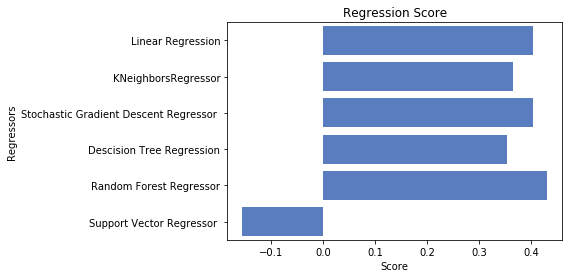

Thriller


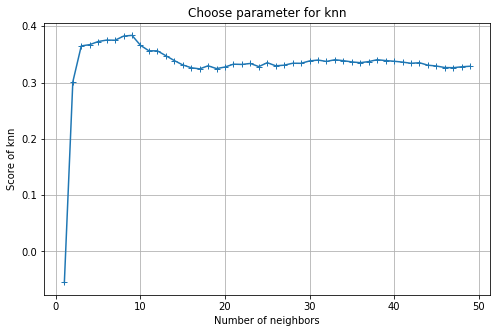

Parameters :  {'n_neighbors': 9, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.383887511563
Score for generalization with KNeighborsRegressor 0.327457480562
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.475090  0.474965  0.475112
huber                         -0.539510 -0.539510 -0.539510
epsilon_insensitive           -0.539508 -0.539508 -0.539508
squared_epsilon_insensitive    0.473623  0.473527  0.473639
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.475111894772
Score for generalization with Stochastic Gradient Descent Regressor  0.387511328137


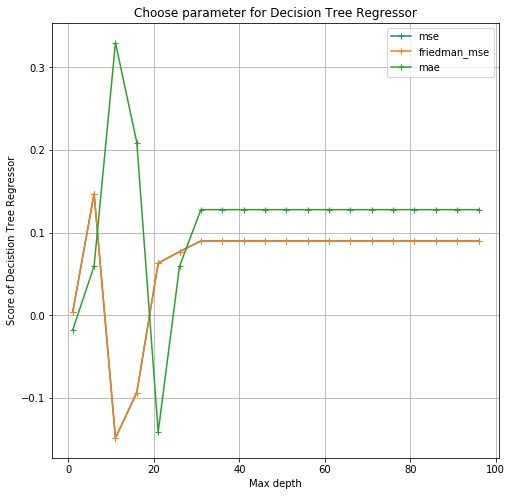

Parameters :  {'max_depth': 11, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.329815885732
Score for generalization with Descision Tree Regression 0.0117331163894
Max depth : 5
Number of estimators : 15


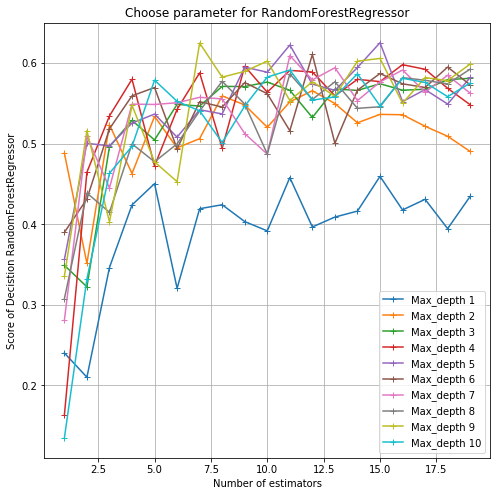

Parameters :  {'max_depth': 5, 'n_estimators': 15, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.586787326124
Score for generalization with Random Forest Regressor 0.403033965669
For regressor :  Thriller
Score for the different regressors 
                                               Score
Linear Regression                      -1.223965e+23
KNeighborsRegressor                     3.274575e-01
Stochastic Gradient Descent Regressor   3.875113e-01
Descision Tree Regression               1.173312e-02
Random Forest Regressor                 4.030340e-01
Support Vector Regressor               -8.529602e-02


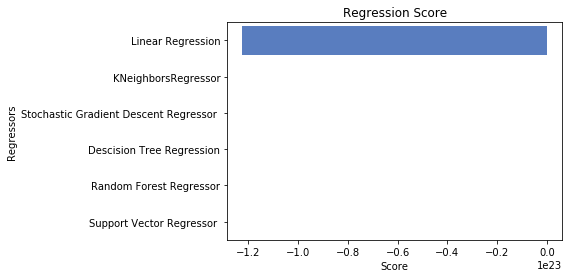

Action


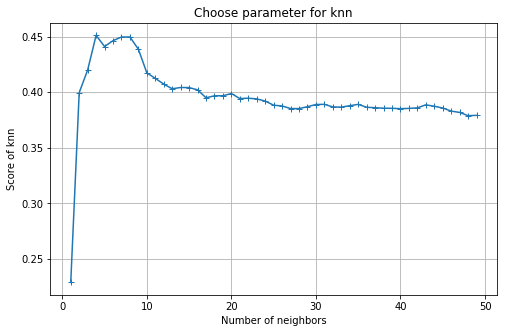

Parameters :  {'n_neighbors': 4, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.451178841896
Score for generalization with KNeighborsRegressor 0.515195688608
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.594239  0.594047  0.594272
huber                         -0.608639 -0.608639 -0.608639
epsilon_insensitive           -0.608638 -0.608638 -0.608638
squared_epsilon_insensitive    0.591658  0.591467  0.591691
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.594272213056
Score for generalization with Stochastic Gradient Descent Regressor  0.506735360667


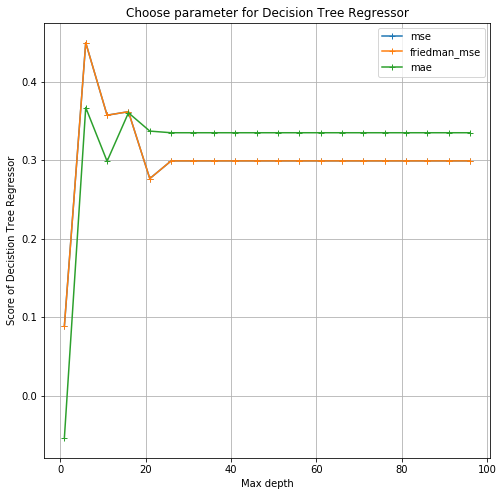

Parameters :  {'max_depth': 6, 'max_features': 'log2', 'criterion': 'mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.449685806194
Score for generalization with Descision Tree Regression 0.15193554607
Max depth : 9
Number of estimators : 10


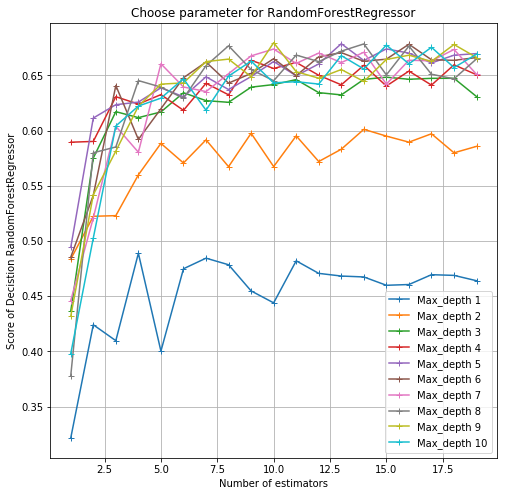

Parameters :  {'max_depth': 9, 'n_estimators': 10, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.629717818952
Score for generalization with Random Forest Regressor 0.530064972487
For regressor :  Action
Score for the different regressors 
                                           Score
Linear Regression                       0.511710
KNeighborsRegressor                     0.515196
Stochastic Gradient Descent Regressor   0.506735
Descision Tree Regression               0.151936
Random Forest Regressor                 0.530065
Support Vector Regressor               -0.077508


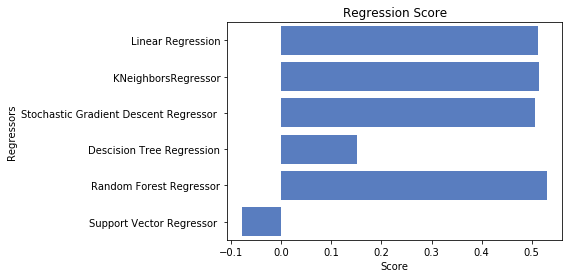

Adventure


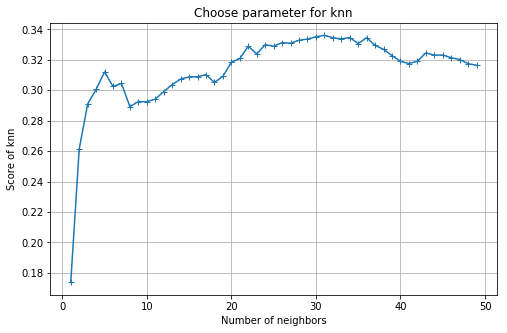

Parameters :  {'n_neighbors': 31, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.336072034441
Score for generalization with KNeighborsRegressor 0.409830505276
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.443180  0.442885  0.443232
huber                         -0.759815 -0.759815 -0.759815
epsilon_insensitive           -0.759814 -0.759814 -0.759814
squared_epsilon_insensitive    0.442750  0.442454  0.442801
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.443231600953
Score for generalization with Stochastic Gradient Descent Regressor  0.601205493767


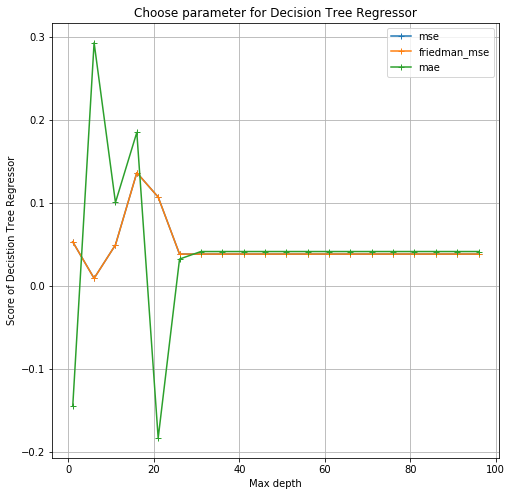

Parameters :  {'max_depth': 6, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.293029180027
Score for generalization with Descision Tree Regression 0.300184087449
Max depth : 8
Number of estimators : 17


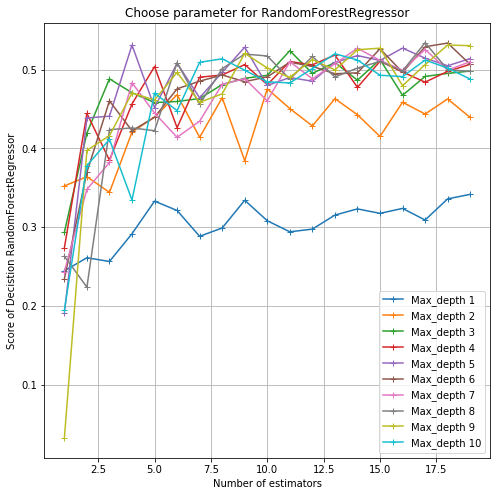

Parameters :  {'max_depth': 8, 'n_estimators': 17, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.510555387085
Score for generalization with Random Forest Regressor 0.654100669814
For regressor :  Adventure
Score for the different regressors 
                                               Score
Linear Regression                      -1.758444e+23
KNeighborsRegressor                     4.098305e-01
Stochastic Gradient Descent Regressor   6.012055e-01
Descision Tree Regression               3.001841e-01
Random Forest Regressor                 6.541007e-01
Support Vector Regressor               -2.700024e-01


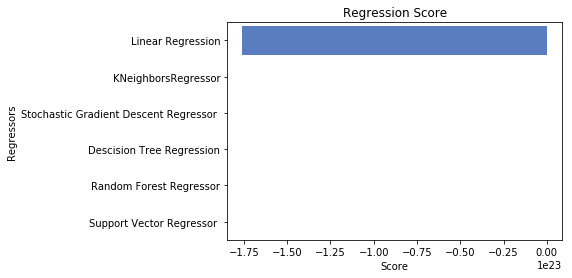

Romance


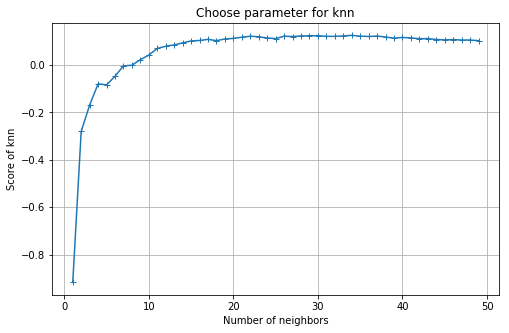

Parameters :  {'n_neighbors': 34, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.124837097
Score for generalization with KNeighborsRegressor 0.104855587489
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                  -0.145832 -0.146364 -0.145739
huber                         -0.646232 -0.646232 -0.646232
epsilon_insensitive           -0.646231 -0.646231 -0.646231
squared_epsilon_insensitive   -0.151065 -0.151434 -0.151001
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.145738565769
Score for generalization with Stochastic Gradient Descent Regressor  0.250337638374


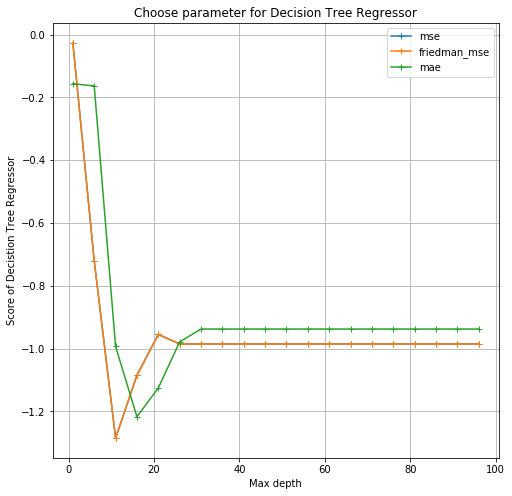

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mse', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0258994144541
Score for generalization with Descision Tree Regression -0.141945355531
Max depth : 3
Number of estimators : 16


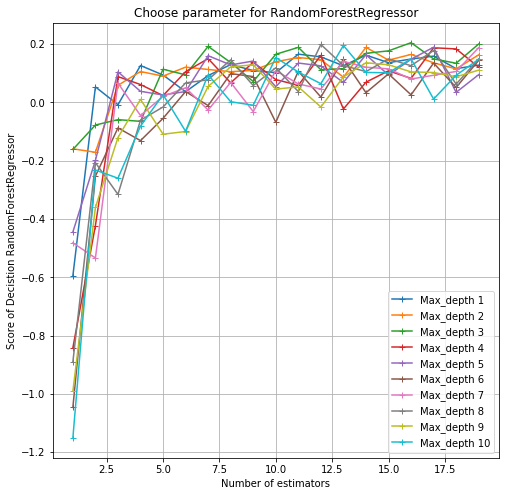

Parameters :  {'max_depth': 3, 'n_estimators': 16, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.112527076378
Score for generalization with Random Forest Regressor 0.397559176988
For regressor :  Romance
Score for the different regressors 
                                           Score
Linear Regression                       0.259309
KNeighborsRegressor                     0.104856
Stochastic Gradient Descent Regressor   0.250338
Descision Tree Regression              -0.141945
Random Forest Regressor                 0.397559
Support Vector Regressor               -0.114618


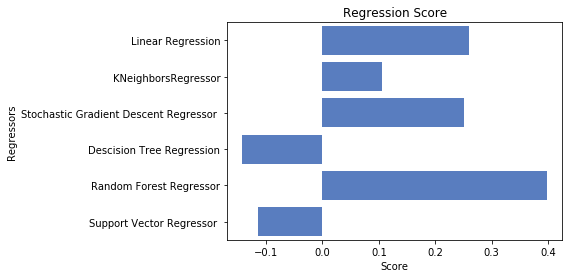

Crime


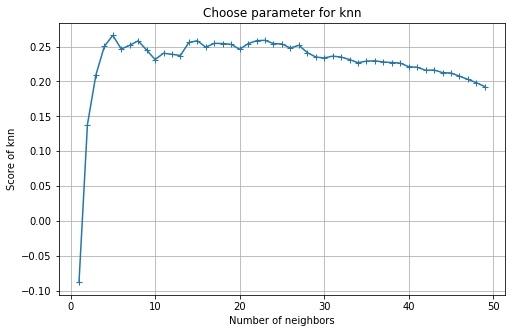

Parameters :  {'n_neighbors': 5, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.266116646992
Score for generalization with KNeighborsRegressor 0.264278432868
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.431253  0.431062  0.431287
huber                         -0.768195 -0.768195 -0.768195
epsilon_insensitive           -0.768193 -0.768193 -0.768193
squared_epsilon_insensitive    0.411895  0.411683  0.411932
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_loss', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.431286968485
Score for generalization with Stochastic Gradient Descent Regressor  0.528502963315


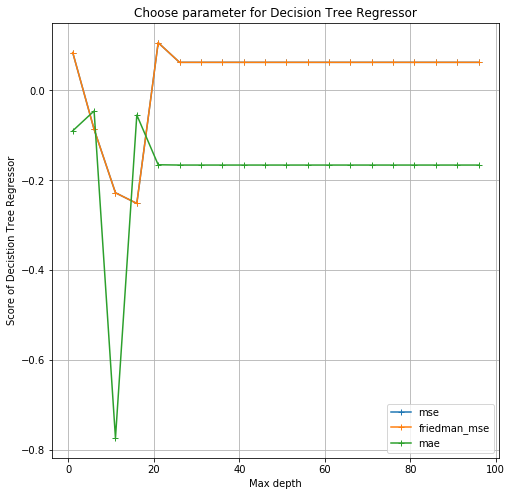

Parameters :  {'max_depth': 21, 'max_features': 'log2', 'criterion': 'mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.106123015121
Score for generalization with Descision Tree Regression 0.479008252708
Max depth : 9
Number of estimators : 13


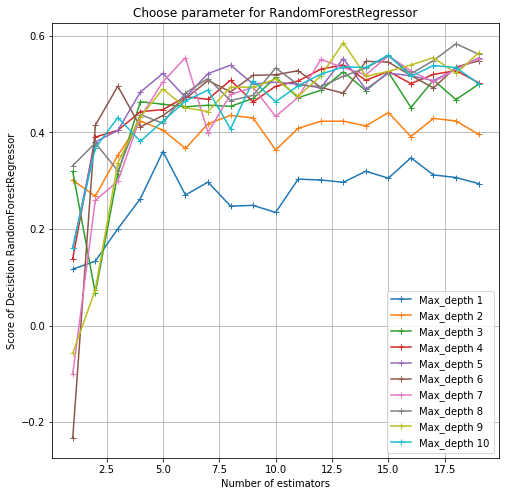

Parameters :  {'max_depth': 9, 'n_estimators': 13, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.477391787484
Score for generalization with Random Forest Regressor 0.668377248025
For regressor :  Crime
Score for the different regressors 
                                           Score
Linear Regression                       0.530857
KNeighborsRegressor                     0.264278
Stochastic Gradient Descent Regressor   0.528503
Descision Tree Regression               0.479008
Random Forest Regressor                 0.668377
Support Vector Regressor               -0.095765


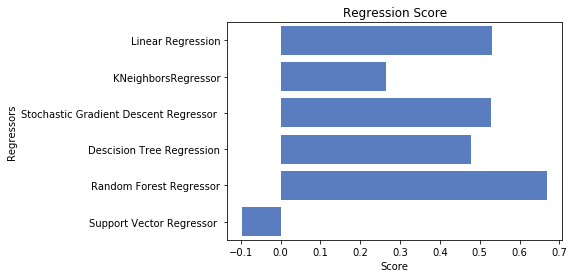

Science Fiction


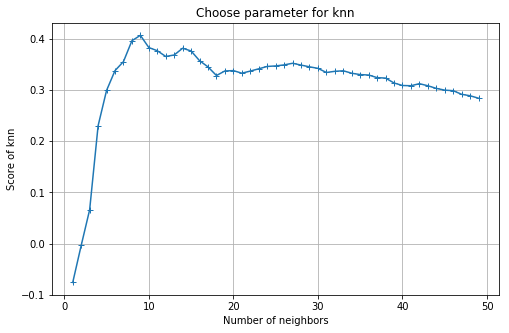

Parameters :  {'n_neighbors': 9, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.406207634648
Score for generalization with KNeighborsRegressor 0.105344392015
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.319014  0.318792  0.319053
huber                         -0.534243 -0.534243 -0.534243
epsilon_insensitive           -0.534242 -0.534242 -0.534242
squared_epsilon_insensitive    0.320628  0.320459  0.320658
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.320657806075
Score for generalization with Stochastic Gradient Descent Regressor  0.0990551183266


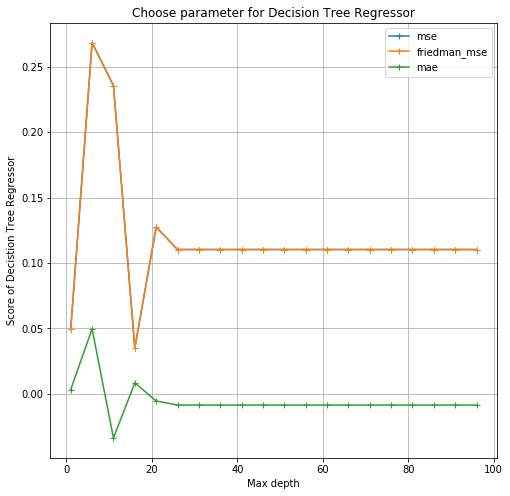

Parameters :  {'max_depth': 6, 'max_features': 'log2', 'criterion': 'mse', 'random_state': 1}
Score cross validation with Descision Tree Regression 0.268441556028
Score for generalization with Descision Tree Regression 0.320861006141
Max depth : 6
Number of estimators : 6


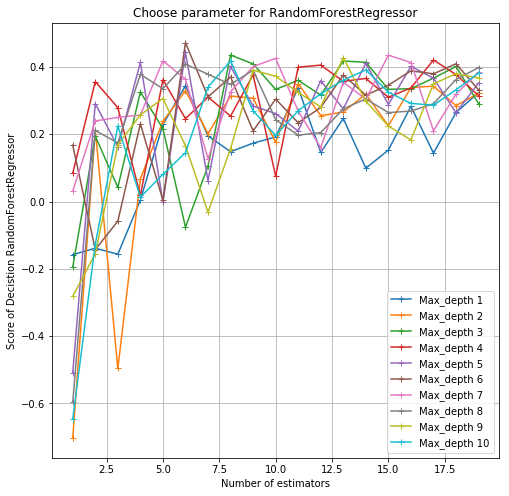

Parameters :  {'max_depth': 6, 'n_estimators': 6, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor 0.271282123795
Score for generalization with Random Forest Regressor -0.126317624339
For regressor :  Science Fiction
Score for the different regressors 
                                           Score
Linear Regression                       0.090343
KNeighborsRegressor                     0.105344
Stochastic Gradient Descent Regressor   0.099055
Descision Tree Regression               0.320861
Random Forest Regressor                -0.126318
Support Vector Regressor               -0.288211


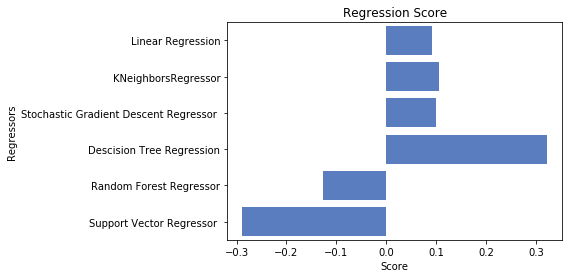

In [243]:
answer_revenue, regressors_revenue_grade = compare_genre_regression_re(liste_genres, dataset_genre)

In [244]:
print(answer_revenue)

['Best regressor : Random Forest Regressor for a score : 0.387799913812', 'Best regressor : Random Forest Regressor for a score : 0.430399302724', 'Best regressor : Random Forest Regressor for a score : 0.403033965669', 'Best regressor : Random Forest Regressor for a score : 0.530064972487', 'Best regressor : Random Forest Regressor for a score : 0.654100669814', 'Best regressor : KNeighborsRegressor for a score : 0.104855587489', 'Best regressor : Random Forest Regressor for a score : 0.668377248025', 'Best regressor : KNeighborsRegressor for a score : 0.105344392015']


In [245]:
plot_graph_genre(regressors_revenue_grade,liste_genres)

                            Regressor used     Score
Drama              Random Forest Regressor  0.387800
Comedy             Random Forest Regressor  0.430399
Thriller           Random Forest Regressor  0.403034
Action             Random Forest Regressor  0.530065
Adventure          Random Forest Regressor  0.654101
Romance            Random Forest Regressor  0.397559
Crime              Random Forest Regressor  0.668377
Science Fiction  Descision Tree Regression  0.320861


In [247]:
def compare_genre_regression_ratio(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_regressors = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_ratio_data(i)
        print(liste_genres[i])
        regressor = Regressors(X_train, y_train, X_test, y_test)
        regressor.set_regressors(liste_regressor)
        regressor.set_functions(liste_function)
        param_lr = {
            'normalize':False
        }
        regressor.set_param(0, param_lr)
        param_svr = {
            'kernel':'linear'
        }
        regressor.set_param(5,param_svr)
        for j in range(len(liste_regressor)) :
            if not(j == 0 or  j == 5) :
                regressor.function(j)
                regressor.print_classifier_scores(j)
        print("For regressor : ", liste_genres[i])
        regressor.print_all_score()
        liste_regressors.append(regressor)
        answer.append(regressor.print_best_regressor())
    return answer , liste_regressors


Drama


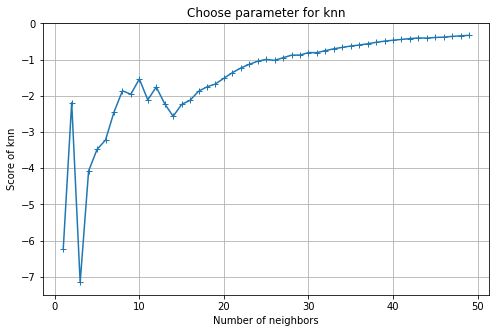

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -0.331312616673
Score for generalization with KNeighborsRegressor -0.0429518942406
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                  -3.008515 -3.009418 -3.008359
huber                         -0.027874 -0.027871 -0.027875
epsilon_insensitive           -0.007451 -0.007716 -0.007585
squared_epsilon_insensitive   -3.005411 -3.005597 -3.005447
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.00745070886592
Score for generalization with Stochastic Gradient Descent Regressor  -0.00412050834752


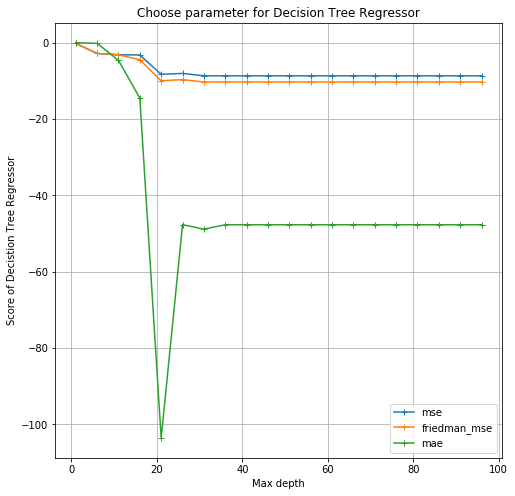

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0305229914623
Score for generalization with Descision Tree Regression -0.00411986748198
Max depth : 1
Number of estimators : 16


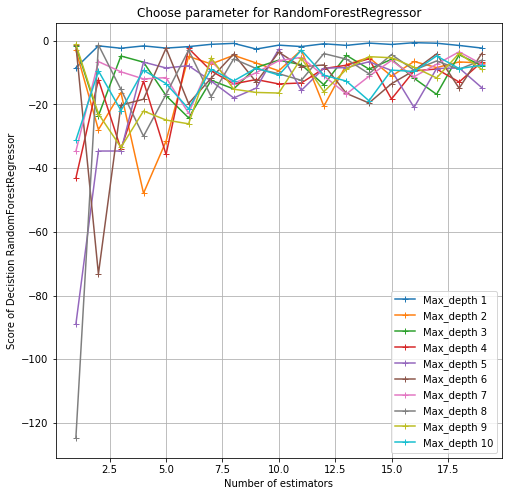

Parameters :  {'max_depth': 1, 'n_estimators': 16, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -1.32932788943
Score for generalization with Random Forest Regressor -0.732809140687
For regressor :  Drama
Score for the different regressors 
                                           Score
Linear Regression                      -1.209953
KNeighborsRegressor                    -0.042952
Stochastic Gradient Descent Regressor  -0.004121
Descision Tree Regression              -0.004120
Random Forest Regressor                -0.732809
Support Vector Regressor               -0.004121


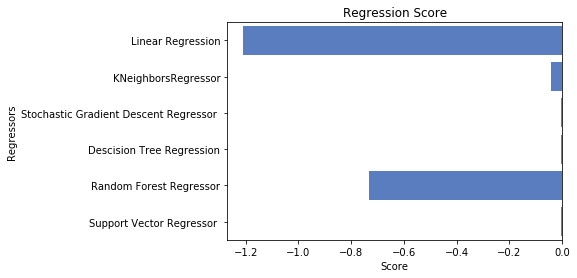

Comedy


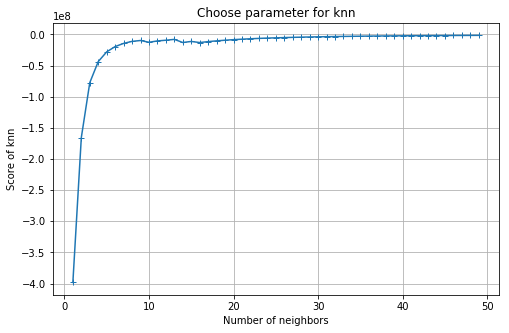

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -1414282.39474
Score for generalization with KNeighborsRegressor -17807.5111403
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -1.074296e+07 -1.075164e+07 -1.074143e+07
huber                       -2.984245e-02 -2.987297e-02 -2.983760e-02
epsilon_insensitive         -2.149727e-02 -2.149278e-02 -2.163509e-02
squared_epsilon_insensitive -1.076920e+07 -1.077391e+07 -1.076837e+07
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0214927801272
Score for generalization with Stochastic Gradient Descent Regressor  -0.00599861763635


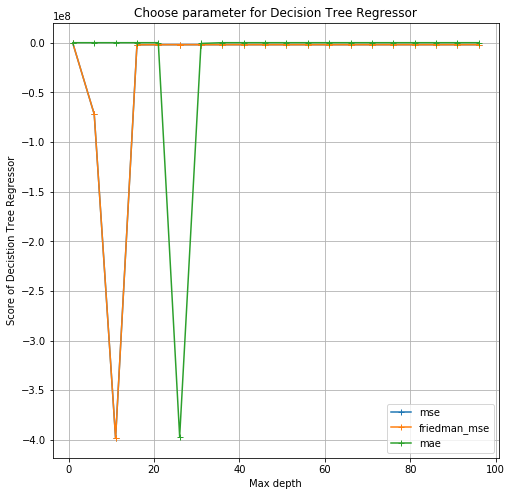

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0307758689865
Score for generalization with Descision Tree Regression -0.00822523047526
Max depth : 6
Number of estimators : 2


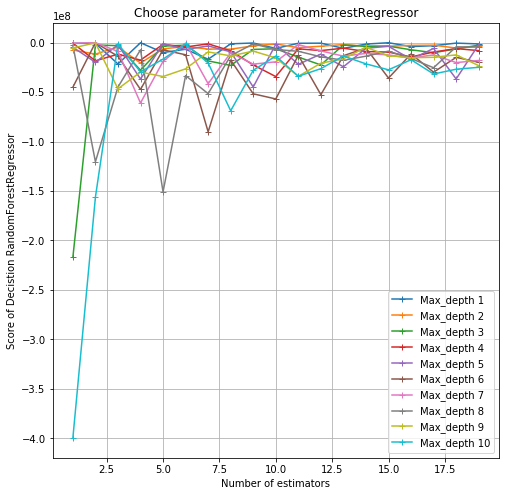

Parameters :  {'max_depth': 6, 'n_estimators': 2, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -9736670.50589
Score for generalization with Random Forest Regressor -2296018.00228
For regressor :  Comedy
Score for the different regressors 
                                               Score
Linear Regression                      -1.581617e+05
KNeighborsRegressor                    -1.780751e+04
Stochastic Gradient Descent Regressor  -5.998618e-03
Descision Tree Regression              -8.225230e-03
Random Forest Regressor                -2.296018e+06
Support Vector Regressor               -6.249390e-03


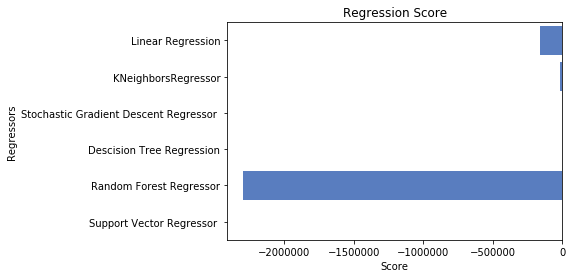

Thriller


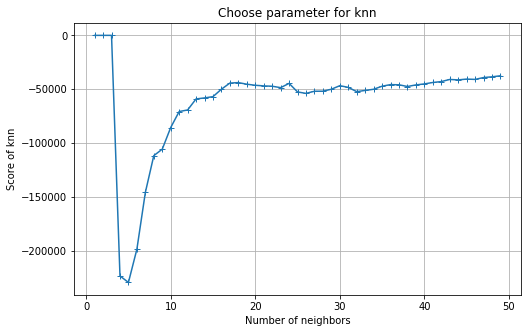

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -7.50562518094
Score for generalization with KNeighborsRegressor -0.139515999199
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -39120.383001 -39188.562029 -39108.393380
huber                           -0.039434     -0.039466     -0.039429
epsilon_insensitive             -0.011741     -0.011711     -0.011963
squared_epsilon_insensitive -42093.444120 -42129.491751 -42087.099181
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0117112901845
Score for generalization with Stochastic Gradient Descent Regressor  -0.0146060496041


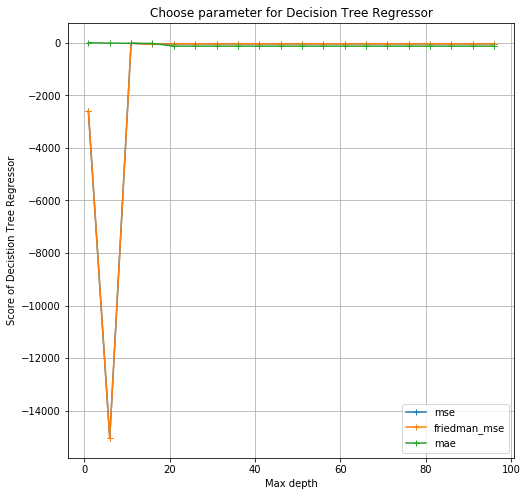

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0324888216688
Score for generalization with Descision Tree Regression -0.0188482145197
Max depth : 9
Number of estimators : 1


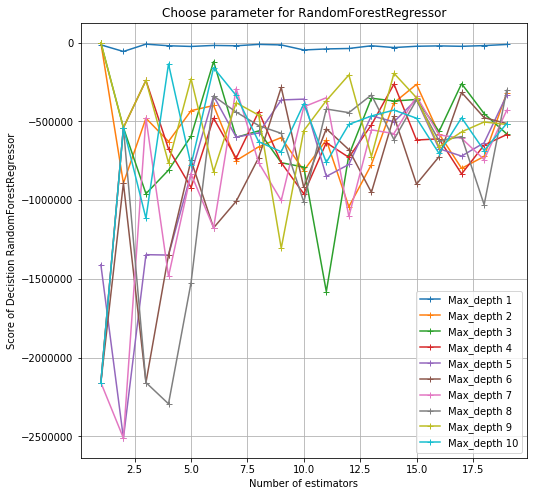

Parameters :  {'max_depth': 9, 'n_estimators': 1, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -2157388.90974
Score for generalization with Random Forest Regressor -1.04208471243
For regressor :  Thriller
Score for the different regressors 
                                               Score
Linear Regression                      -1.119259e+30
KNeighborsRegressor                    -1.395160e-01
Stochastic Gradient Descent Regressor  -1.460605e-02
Descision Tree Regression              -1.884821e-02
Random Forest Regressor                -1.042085e+00
Support Vector Regressor               -1.479806e-02


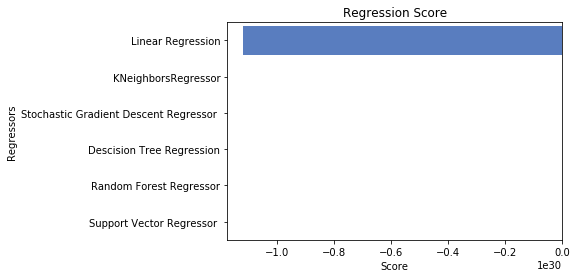

Action


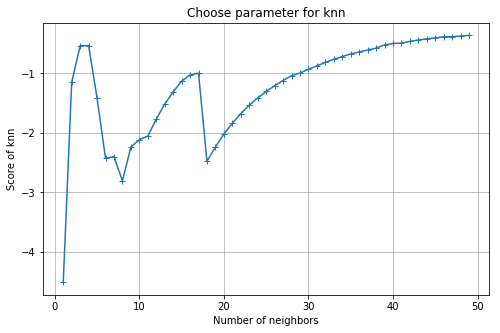

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -0.360599802058
Score for generalization with KNeighborsRegressor -0.00844114839877
Score for different parameters : 
                             elasticnet         l1         l2
squared_loss                 -32.524001 -32.564501 -32.516889
huber                         -0.025656  -0.025782  -0.025633
epsilon_insensitive            0.002109   0.002082   0.002278
squared_epsilon_insensitive  -30.990722 -31.014664 -30.986527
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  0.00227806395597
Score for generalization with Stochastic Gradient Descent Regressor  -0.0294001281927


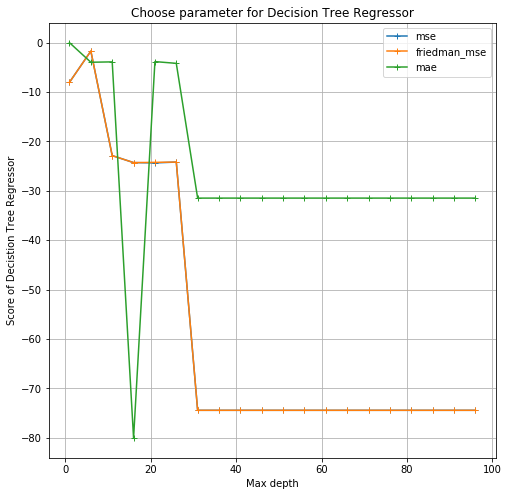

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0333680374215
Score for generalization with Descision Tree Regression -0.0525177349807
Max depth : 2
Number of estimators : 1


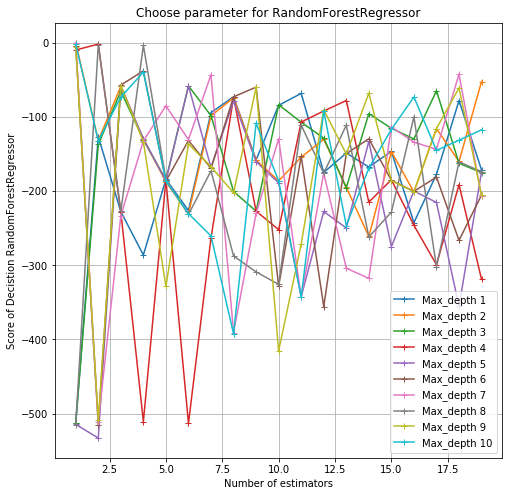

Parameters :  {'max_depth': 2, 'n_estimators': 1, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -0.104731473488
Score for generalization with Random Forest Regressor -25.4590257678
For regressor :  Action
Score for the different regressors 
                                            Score
Linear Regression                       -6.569601
KNeighborsRegressor                     -0.008441
Stochastic Gradient Descent Regressor   -0.029400
Descision Tree Regression               -0.052518
Random Forest Regressor                -25.459026
Support Vector Regressor                -0.029986


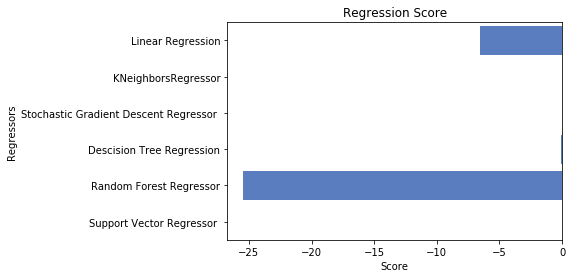

Adventure


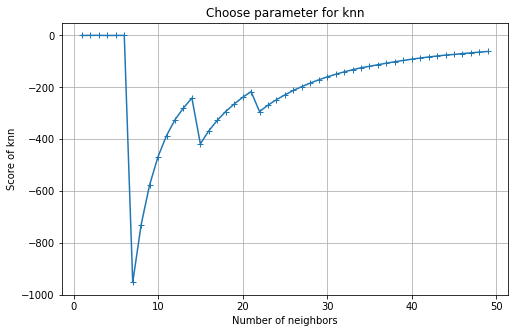

Parameters :  {'n_neighbors': 2, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.00325151820566
Score for generalization with KNeighborsRegressor -0.460353112797
Score for different parameters : 
                             elasticnet          l1          l2
squared_loss                -869.837590 -870.519994 -869.717149
huber                         -0.025952   -0.026016   -0.025948
epsilon_insensitive            0.010616    0.011742    0.011034
squared_epsilon_insensitive -873.380041 -873.785094 -873.306728
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  0.0117421319444
Score for generalization with Stochastic Gradient Descent Regressor  0.0703141845762


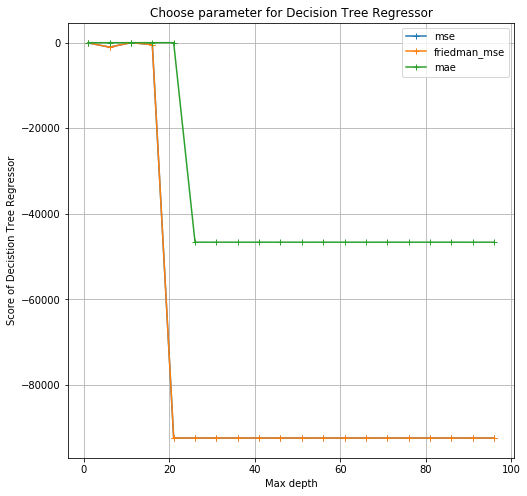

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0401924038531
Score for generalization with Descision Tree Regression -0.0509950183223
Max depth : 5
Number of estimators : 1


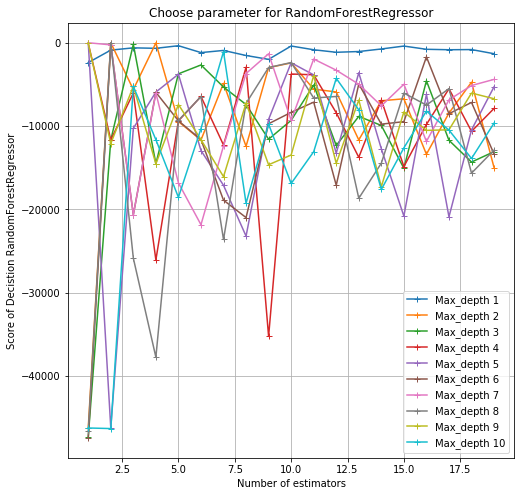

Parameters :  {'max_depth': 5, 'n_estimators': 1, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -1172.5273726
Score for generalization with Random Forest Regressor -39.1639325142
For regressor :  Adventure
Score for the different regressors 
                                               Score
Linear Regression                      -1.084530e+28
KNeighborsRegressor                    -4.603531e-01
Stochastic Gradient Descent Regressor   7.031418e-02
Descision Tree Regression              -5.099502e-02
Random Forest Regressor                -3.916393e+01
Support Vector Regressor                6.923951e-02


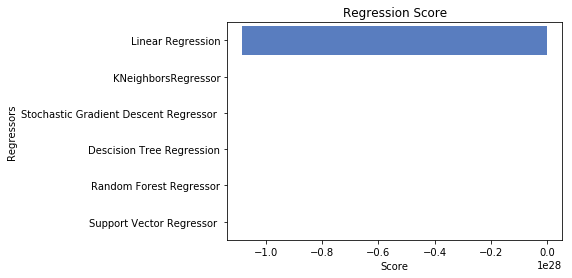

Romance


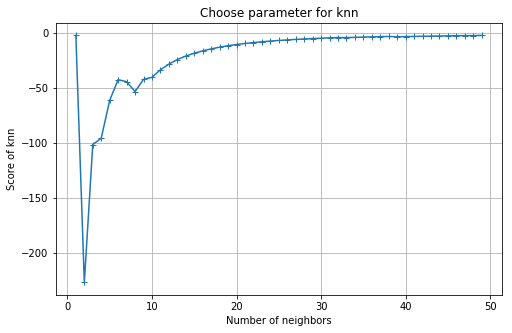

Parameters :  {'n_neighbors': 1, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -2.10140774205
Score for generalization with KNeighborsRegressor -0.0101030013729
Score for different parameters : 
                             elasticnet         l1         l2
squared_loss                 -53.945184 -53.942259 -53.945633
huber                         -0.107878  -0.107876  -0.107878
epsilon_insensitive           -0.014760  -0.014033  -0.014985
squared_epsilon_insensitive  -57.549302 -57.534152 -57.552023
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0140332563887
Score for generalization with Stochastic Gradient Descent Regressor  -0.0101025674655


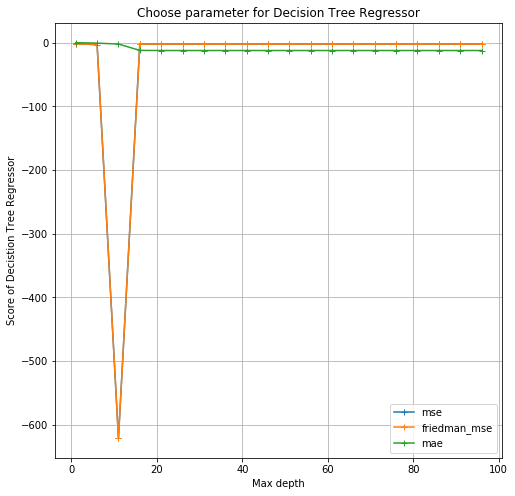

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0652227114843
Score for generalization with Descision Tree Regression -0.0101026481234
Max depth : 3
Number of estimators : 1


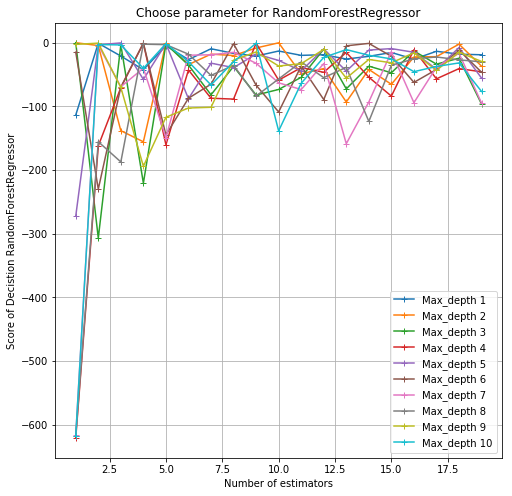

Parameters :  {'max_depth': 3, 'n_estimators': 1, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -0.0374542799262
Score for generalization with Random Forest Regressor -0.0101025568731
For regressor :  Romance
Score for the different regressors 
                                           Score
Linear Regression                      -0.010069
KNeighborsRegressor                    -0.010103
Stochastic Gradient Descent Regressor  -0.010103
Descision Tree Regression              -0.010103
Random Forest Regressor                -0.010103
Support Vector Regressor               -0.010103


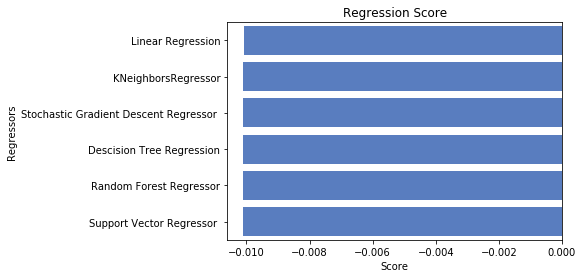

Crime


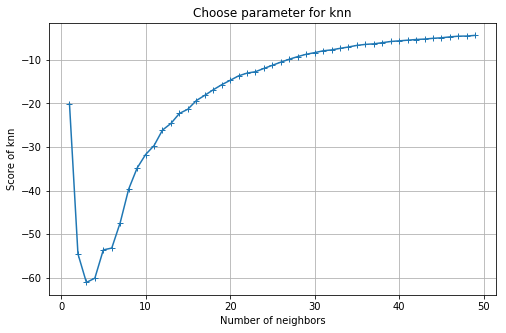

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -4.38324697391
Score for generalization with KNeighborsRegressor -0.0235040536884
Score for different parameters : 
                             elasticnet         l1         l2
squared_loss                 -17.085372 -17.088117 -17.084761
huber                         -0.116710  -0.116744  -0.116697
epsilon_insensitive           -0.149286  -0.149902  -0.153393
squared_epsilon_insensitive  -17.810550 -17.817409 -17.813256
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'huber', 'penalty': 'l2'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.116697217863
Score for generalization with Stochastic Gradient Descent Regressor  -0.0286002791855


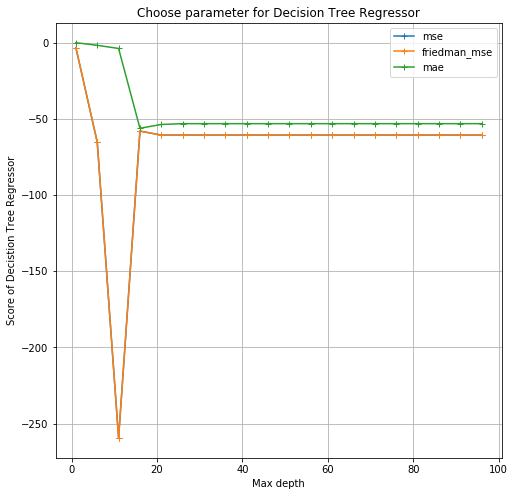

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.049405096411
Score for generalization with Descision Tree Regression -0.0288784593954
Max depth : 1
Number of estimators : 7


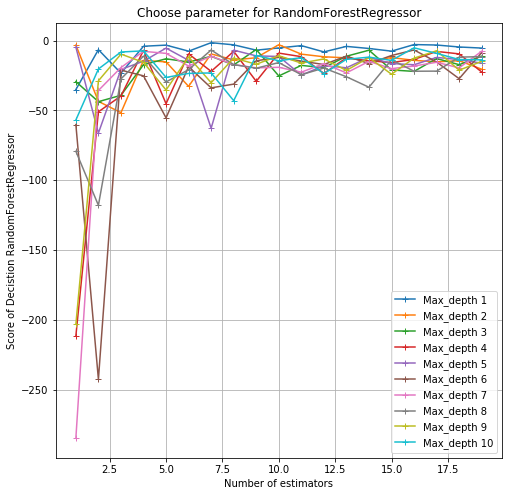

Parameters :  {'max_depth': 1, 'n_estimators': 7, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -5.43281871182
Score for generalization with Random Forest Regressor 0.0150300824108
For regressor :  Crime
Score for the different regressors 
                                           Score
Linear Regression                      -0.053684
KNeighborsRegressor                    -0.023504
Stochastic Gradient Descent Regressor  -0.028600
Descision Tree Regression              -0.028878
Random Forest Regressor                 0.015030
Support Vector Regressor               -0.023987


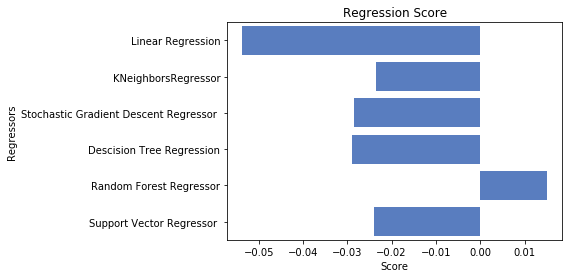

Science Fiction


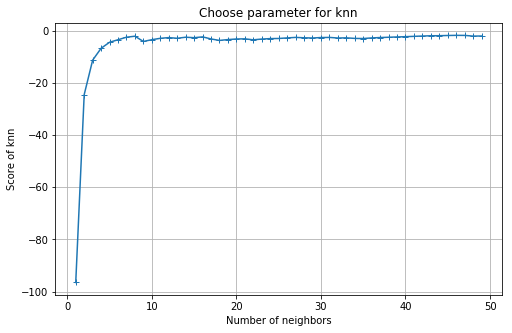

Parameters :  {'n_neighbors': 46, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -1.81861562934
Score for generalization with KNeighborsRegressor -0.0130278110685
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                  -8.984139 -8.985613 -8.983752
huber                         -0.061023 -0.061092 -0.061011
epsilon_insensitive           -0.028610 -0.027021 -0.028820
squared_epsilon_insensitive   -9.115081 -9.112277 -9.115182
Parameters :  {'shuffle': False, 'max_iter': 1000, 'random_state': 1, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0270211692627
Score for generalization with Stochastic Gradient Descent Regressor  -0.0319770577309


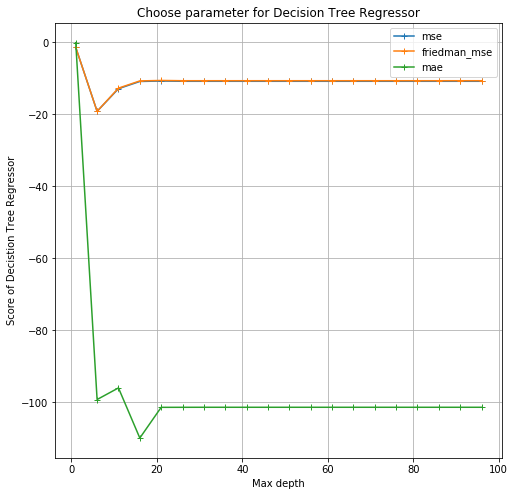

Parameters :  {'max_depth': 1, 'max_features': 'log2', 'criterion': 'mae', 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0673444988993
Score for generalization with Descision Tree Regression -0.051341473111
Max depth : 3
Number of estimators : 12


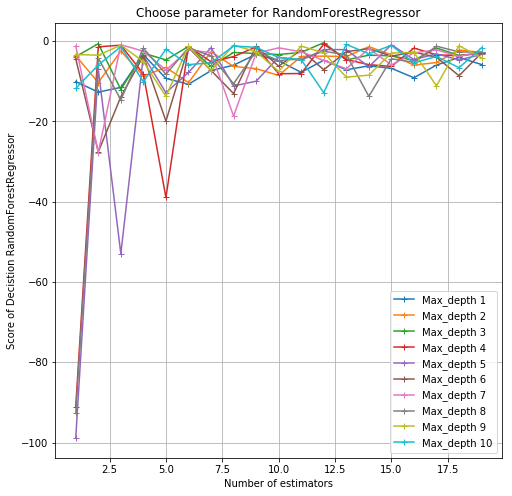

Parameters :  {'max_depth': 3, 'n_estimators': 12, 'max_features': 'auto'}
Score cross validation with Random Forest Regressor -3.78020706541
Score for generalization with Random Forest Regressor -0.127517760914
For regressor :  Science Fiction
Score for the different regressors 
                                           Score
Linear Regression                      -0.117256
KNeighborsRegressor                    -0.013028
Stochastic Gradient Descent Regressor  -0.031977
Descision Tree Regression              -0.051341
Random Forest Regressor                -0.127518
Support Vector Regressor               -0.034808


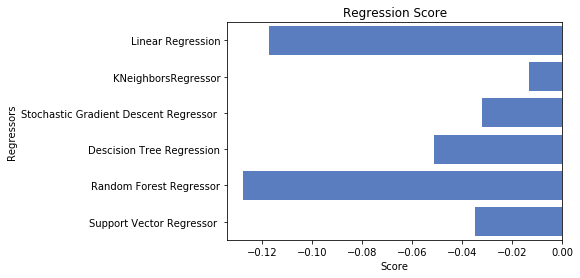

In [248]:
answer_ratio, regressors_ratio_genre = compare_genre_regression_ratio(liste_genres, dataset_genre)

In [249]:
plot_graph_genre(regressors_ratio_genre,liste_genres)

                                         Regressor used     Score
Drama                         Descision Tree Regression -0.004120
Comedy           Stochastic Gradient Descent Regressor  -0.005999
Thriller         Stochastic Gradient Descent Regressor  -0.014606
Action                              KNeighborsRegressor -0.008441
Adventure        Stochastic Gradient Descent Regressor   0.070314
Romance                               Linear Regression -0.010069
Crime                           Random Forest Regressor  0.015030
Science Fiction                     KNeighborsRegressor -0.013028


<div class="alert alert-success">
Classification
</div>



In [250]:
# Create the instance of the Dataset class in order to normalize, split and remove features
dataset_all_c = Dataset(pre_process)
# Discretizes the grade into 100 labels
dataset_all_c.discretize(0)
# Splits the set into training and testing sets
dataset_all_c.set_sets()
# Normalization of the input
dataset_all_c.normalize()


In [251]:
# Gets the train and testing sets
X_train_g_100, X_test_g_100 , y_train_g_100, y_test_g_100 = dataset_all_c.get_grade_data(0)


In [252]:

# Class to do Classification and to vizualise it easily
class Classifications :
    def __init__(self,X_train, y_train, X_test, y_test ) :
        # Name of the classifiers used
        self.classificators_name = ['LDA','LogisticRegression','Perceptron',\
                   'SVC','Decision Trees','RandomForestClassifier','AdaBoostClassifier']
        # Input training set
        self.X_train = X_train
        # Output training set
        self.y_train = y_train
        # Input testing set
        self.X_test = X_test
        # Output testing set
        self.y_test = y_test
        # List of the parameters
        self.list_param = [0 for i in range (len(self.classificators_name)) ]
        # List of the accuracy on the testing set
        self.list_score = np.zeros((1,len(self.classificators_name)))[0]
        # List of the accuracy after cross validation
        self.liste_oof_score = np.zeros((1,len(self.classificators_name)))[0]
        # List of classifiers
        self.classifiers = [0 for i in range (len(self.classificators_name)) ]
        # List of the functions used to get the best parameters for the classifiers
        self.functions = [None for i in range(len(self.classificators_name))]
        
    def get_oof_score(self,index) :
        # Gets the accuracy after cross validation of a given classifier
        # index gives the number of the classifier in the name list
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        oof_score = get_oof_c(clfr, self.X_train,self.y_train)
        self.liste_oof_score[index] = oof_score
        return oof_score
    
    def get_score(self, index) :
        # Gets the accuracy of a given classifier
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        score = get_score_c(clfr,self.X_train,self.y_train,self.X_test,self.y_test) 
        self.list_score[index] = score
        return score
    
    def set_classifier(self, index, clf) :
        # Sets the classifier at a given position
        self.classifiers[index] = clf
    
    def set_param(self, index, param) :
        # Sets the parameters for a given classifier
        self.list_param[index] = param
        if (self.classifiers[index] is not None ):
            self.get_oof_score(index)
            self.get_score(index)
    
    def print_classifier_scores(self, index) :
        # Prints the accuracy on the training and testing set
        if (self.list_score[index] == 0 or self.liste_oof_score[index] == 0) :
            self.get_oof_score(index)
            self.get_score(index)    
        print("Score cross validation with " + self.classificators_name[index], self.liste_oof_score[index])
        print("Score for generalization with "+ self.classificators_name[index], self.list_score[index])
        
    def set_function(self, index, func) :
        # Sets the function to get the best parameters for a given classifier
        self.functions[index] = func
     
    def function(self,index) :
        # Gets the best parameters for a given classifier
        if self.functions[index] is not None :
            param,clf = self.functions[index](self.X_train, self.y_train, True)
            self.set_param(index,param)
            self.set_classifier(index, clf)
            print("Parameters : ",param)
            
    def set_regressors(self, liste_regressor) :
        # Sets the classifier to the given position 
        for index, x in enumerate(liste_regressor) :
            self.set_classifier(index, x)
        
    def set_functions(self,liste_function):
        # Sets the function to a given classifier        
        for index, x in enumerate(liste_function) :
            self.set_function(index, x)
            
    def print_all_score(self) :
        # Prints all the accuracy for all the different classifiers
        print("Score for the different classifiers ")
        score_regressors = {}
        score_regressors['Score'] = self.list_score
        score_class_df = pd.DataFrame(score_regressors, index =self.classificators_name)        
        print(score_class_df)        
        sns.set_color_codes("muted")
        score_class_df['Classifiers'] = self.classificators_name
        sns.barplot(x='Score', y='Classifiers', data=score_class_df, color="b")
        plt.xlabel('Score')
        plt.title('Regression Score')
        plt.show()

    def plot_prediction(self,name) :
        # It takes the model that maximizes the accuracy 
        index = np.argmax(self.list_score)
        clf = self.classifiers[index]
        print("Regressor chosen :",self.classificators_name[index])
        params = self.list_param[index]
        classifier = SKlearnHelper(clf=clf, params = params)
        classifier.fit(self.X_train, self.y_train)
        y_predict = classifier.predict(self.X_test)
        f, ax = plt.subplots(figsize=(8, 8))
        plt.scatter([i for i in range(len(y_predict))] ,y_predict, color='b', label="Prediction",\
                   marker='+')
        plt.scatter([i for i in range(len(y_predict))],self.y_test,color='r',label="Real Value",\
                    marker='+')
        plt.xlabel("Number of instance")
        plt.ylabel(name)
        plt.title("Comparaison of the model with the real values")
        plt.legend()
        plt.show()

    def print_best_classifier(self) :
        # It will prints the best classifiers (for the training set) and 
        # returns its accuracy with the testing set
        index = np.argmax(self.liste_oof_score)
        answer = "Best regressor : " + str(self.classificators_name[index]) +\
        " for a score : " + str(self.list_score[index])
        return answer
        
       
        
            
        
        
            

<div class="alert alert-success">
Grade discretized as 100 labels
</div>



In [253]:
# Classifier instance that will be used to train our model on our data
# We take the grade with 100 label as output
classifier_100 = Classifications(X_train_g_100, y_train_g_100, X_test_g_100 , y_test_g_100)

In [254]:
# Declaration of the functions and classifiers that we'r going to use 
liste_function_classifier = [get_lda , get_lreg, get_perc , get_svm,get_dtc ,\
                            get_rfc, get_ada]
liste_classifiers = [LinearDiscriminantAnalysis, LogisticRegression,Perceptron,\
                    SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]



In [255]:
# Sets the functions and classifier to our instance 
classifier_100.set_functions(liste_function_classifier)
classifier_100.set_regressors(liste_classifiers)

* Linear Discriminant Analysis

In [256]:
# Fits the data with the best parameters and then it retunrs the score for LDA
classifier_100.function(0)
classifier_100.print_classifier_scores(0)

Solver chosen :  lsqr
Score after cross validation for LDA  0.124598930481
Parameters :  {'solver': 'lsqr'}
Score cross validation with LDA 0.124598930481
Score for generalization with LDA 0.130052724077


* Logistic Regression

In [257]:
# Fits the data with the best parameters and then it retunrs the score for Logistic Regression
classifier_100.function(1)
classifier_100.print_classifier_scores(1)

Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0850267379679
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.0850267379679
Score for generalization with LogisticRegression 0.0931458699473


* Perceptron

In [258]:
# Fits the data with the best parameters and then it retunrs the score for Perceptron
classifier_100.function(2)
classifier_100.print_classifier_scores(2)

Penalty chosen :  l1
Score after cross validation for Perceptron 0.0465240641711
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0465240641711
Score for generalization with Perceptron 0.0404217926186


* Support Vector Machine Classifier

In [259]:
# Fits the data with the best parameters and then it retunrs the score for SVMC
classifier_100.function(3)
classifier_100.print_classifier_scores(3)

Kernel used :  sigmoid
Score after cross validation for SVM 0.0689839572193
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0689839572193
Score for generalization with SVC 0.0843585237258


* Decision Trees


In [260]:
# Fits the data with the best parameters and then it retunrs the score for Decision Trees
classifier_100.function(4)
classifier_100.print_classifier_scores(4)

Max depth chosen :  19
Score after cross validation for Decision Tree 0.104278074866
Parameters :  {'max_depth': 19, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision Trees 0.104278074866
Score for generalization with Decision Trees 0.0966608084359


* Random Forest Classifier

Score after cross validation for Random Forest 0.149197860963


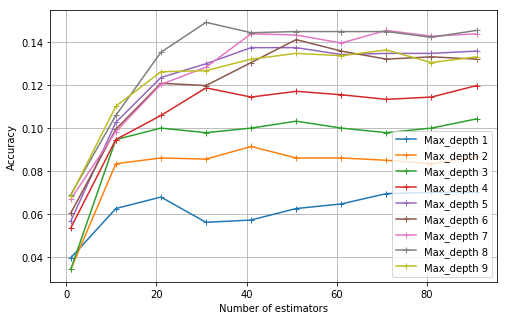

Number of estimators :  31
Max depth :  8
Parameters :  {'max_depth': 8, 'n_estimators': 31, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.149197860963
Score for generalization with RandomForestClassifier 0.140597539543


In [261]:
# Fits the data with the best parameters and then it retunrs the score for Random Forest Classifier
classifier_100.function(5)
classifier_100.print_classifier_scores(5)

* AdaBoost Classifier

In [262]:
# Fits the data with the best parameters and then it retunrs the score for Adaboost Classifier
classifier_100.function(6)
classifier_100.print_classifier_scores(6)

Number of estimators :  141
Score after cross validation for Adaboost 0.11550802139
Parameters :  {'learning_rate': 0.5, 'n_estimators': 141, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.11550802139
Score for generalization with AdaBoostClassifier 0.0808435852373


Score for the different classifiers 
                           Score
LDA                     0.130053
LogisticRegression      0.093146
Perceptron              0.040422
SVC                     0.084359
Decision Trees          0.096661
RandomForestClassifier  0.140598
AdaBoostClassifier      0.080844


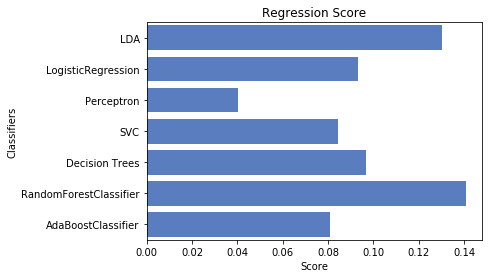

In [263]:
# Prints the result and summarize it 
classifier_100.print_all_score()

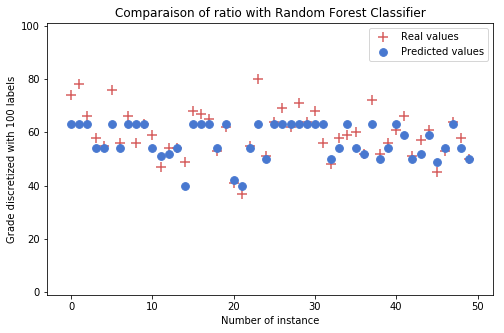

In [264]:
# Plots the 50 first instances of the testing set with the real output and the predicted one 
plot_predict_real(classifier_100, 50, "Grade discretized with 100 labels", \
                  "Random Forest Classifier", [-1,101],6)

<div class="alert alert-success">
Grade discretized as 20 labels
</div>



In [265]:
# Creation of Dataset instance
dataset_all_c_20 = Dataset(pre_process)
# Discretize as 20 labels
dataset_all_c_20.discretize(1)
# Spits it into train and test sets
dataset_all_c_20.set_sets()
# Normalization
dataset_all_c_20.normalize()


In [266]:
# Splits it into training and testing sets
X_train_g_20, X_test_g_20 , y_train_g_20, y_test_g_20 = dataset_all_c_20.get_grade_data(0)

In [267]:
# Creation of Classifier instance
classifier_20 = Classifications(X_train_g_20, y_train_g_20, X_test_g_20 , y_test_g_20)
# Sets the function to get the best parameters
classifier_20.set_functions(liste_function_classifier)
# Sets the classifiers that we're going to use
classifier_20.set_regressors(liste_classifiers)



* Linear Discriminant Analysis


In [268]:
# Fits the data with the best parameters and then it retunrs the score for LDA
classifier_20.function(0)
classifier_20.print_classifier_scores(0)


Solver chosen :  lsqr
Score after cross validation for LDA  0.558823529412
Parameters :  {'solver': 'lsqr'}
Score cross validation with LDA 0.558823529412
Score for generalization with LDA 0.530755711775



* Logistic Regression

In [269]:
# Fits the data with the best parameters and then it retunrs the score for Logistic Regression
classifier_20.function(1)
classifier_20.print_classifier_scores(1)


Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.496256684492
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.496256684492
Score for generalization with LogisticRegression 0.521968365554


* Perceptron

In [271]:
# Fits the data with the best parameters and then it retunrs the score for Perceptron
classifier_20.function(2)
classifier_20.print_classifier_scores(2)


Penalty chosen :  l1
Score after cross validation for Perceptron 0.256684491979
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.256684491979
Score for generalization with Perceptron 0.191564147627


* Support Vector Machine Classifier


In [272]:
# Fits the data with the best parameters and then it retunrs the score for SVMC
classifier_20.function(3)
classifier_20.print_classifier_scores(3)


Kernel used :  sigmoid
Score after cross validation for SVM 0.481818181818
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.481818181818
Score for generalization with SVC 0.516695957821


* Decision Trees

In [273]:
# Fits the data with the best parameters and then it retunrs the score for Decision Trees
classifier_20.function(4)
classifier_20.print_classifier_scores(4)


Max depth chosen :  11
Score after cross validation for Decision Tree 0.423529411765
Parameters :  {'max_depth': 11, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision Trees 0.423529411765
Score for generalization with Decision Trees 0.316344463972


* Random Forest Classifier


Score after cross validation for Random Forest 0.569518716578


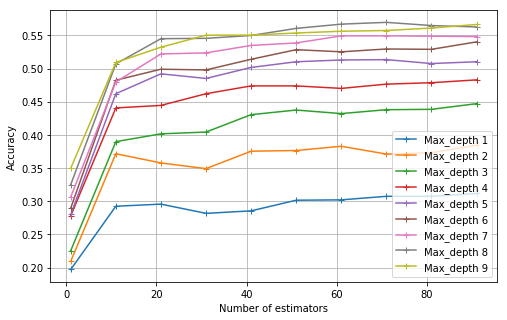

Number of estimators :  40
Max depth :  8
Parameters :  {'max_depth': 8, 'n_estimators': 40, 'random_state': 1}


In [274]:
# Fits the data with the best parameters and then it retunrs the score for Random Forest Classifier
classifier_20.function(5)

In [275]:
# Prints the results
classifier_20.print_classifier_scores(5)

Score cross validation with RandomForestClassifier 0.553475935829
Score for generalization with RandomForestClassifier 0.523725834798



* AdaBoost Classifier

In [276]:
# Fits the data with the best parameters and then it retunrs the score for Adaboost Classifier
classifier_20.function(6)
classifier_20.print_classifier_scores(6)


Number of estimators :  61
Score after cross validation for Adaboost 0.457219251337
Parameters :  {'learning_rate': 0.5, 'n_estimators': 61, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.457219251337
Score for generalization with AdaBoostClassifier 0.435852372583


Score for the different classifiers 
                           Score
LDA                     0.530756
LogisticRegression      0.521968
Perceptron              0.191564
SVC                     0.516696
Decision Trees          0.316344
RandomForestClassifier  0.523726
AdaBoostClassifier      0.435852


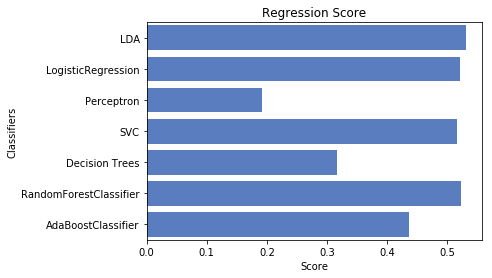

In [277]:
# Prints the result and summarize it 
classifier_20.print_all_score()

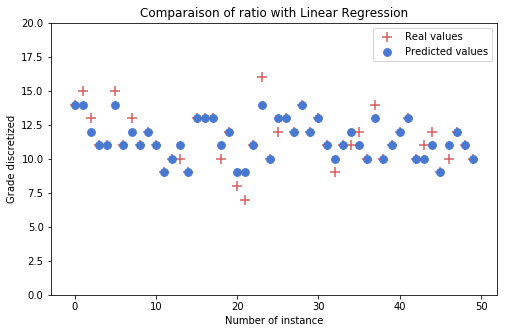

In [278]:
# Plots the 50 first instances of the testing set with the real output and the predicted one
plot_predict_real(classifier_20, 50, "Grade discretized", "Linear Regression", [0,20],-2)

<div class="alert alert-success">
Revenue discretized as 3 labels
</div>



In [279]:
# Creation of Dataset instance
dataset_all_r = Dataset(pre_process)
# Discretizes the revenue as 3 labels : low revenue, medium revenue and high revenue
dataset_all_r.discretize_revenue()
# Splits to train and test sets
dataset_all_r.set_sets()
# Normalization of the inputs
dataset_all_r.normalize()


In [280]:
# Creation of our training and testing subsets
X_train_c_r, X_test_c_r , y_train_c_r, y_test_c_r = dataset_all_r.get_revenue_data(0)

# Creation of a Classification instance
classifier_r = Classifications(X_train_c_r, y_train_c_r, X_test_c_r , y_test_c_r)
# Sets the functions to get the best parameters
classifier_r.set_functions(liste_function_classifier)
# Sets the classifiers
classifier_r.set_regressors(liste_classifiers)



Solver chosen :  lsqr
Score after cross validation for LDA  0.640106951872
Parameters :  {'solver': 'lsqr'}
Score cross validation with LDA 0.640106951872
Score for generalization with LDA 0.653778558875
Solver chosen :  lbfgs
Score after cross validation for Logistic Regression  0.672727272727
Parameters :  {'multi_class': 'multinomial', 'solver': 'lbfgs', 'random_state': 1}
Score cross validation with LogisticRegression 0.672727272727
Score for generalization with LogisticRegression 0.687170474517
Penalty chosen :  l1
Score after cross validation for Perceptron 0.583957219251
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.583957219251
Score for generalization with Perceptron 0.622144112478
Kernel used :  sigmoid
Score after cross validation for SVM 0.649732620321
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.649732620321
Score for generalization with SVC 0.66783831283
Max depth ch

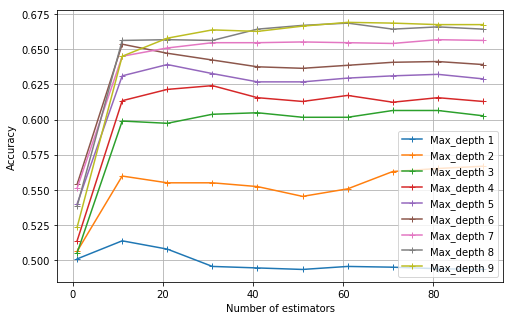

Number of estimators :  40
Max depth :  9
Parameters :  {'max_depth': 9, 'n_estimators': 40, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.657219251337
Score for generalization with RandomForestClassifier 0.662565905097
Number of estimators :  91
Score after cross validation for Adaboost 0.651871657754
Parameters :  {'learning_rate': 0.5, 'n_estimators': 91, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.651871657754
Score for generalization with AdaBoostClassifier 0.674868189807


In [281]:
# Loops through all the classifiers
for i in range(len(classifier_r.classificators_name)) :
    # Gets the best parameters through a cross validation process 
    # to get the scores with the current parameters
    classifier_r.function(i)
    # Pritns the accuracy of the classifiers
    classifier_r.print_classifier_scores(i)

Score for the different classifiers 
                           Score
LDA                     0.653779
LogisticRegression      0.687170
Perceptron              0.622144
SVC                     0.667838
Decision Trees          0.597540
RandomForestClassifier  0.662566
AdaBoostClassifier      0.674868


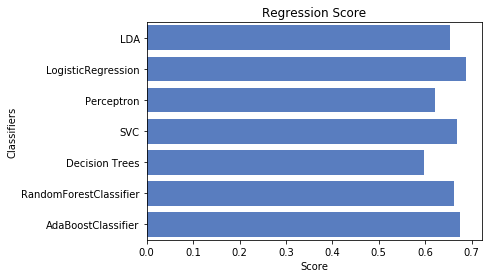

In [282]:
# Plots the results of the previous process with all the accuracy of all the classifiers
classifier_r.print_all_score()

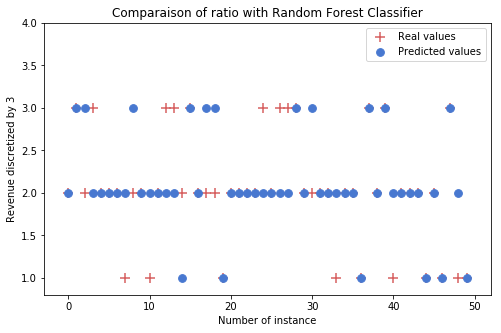

In [283]:
# Plots the 50 first instances of our testing set with the real and the predicted outputs
plot_predict_real(classifier_r, 50, "Revenue discretized by 3", "Random Forest Classifier",\
                  [0.8,4],6)

<div class="alert alert-success">
Splitting our data into genre sets
</div>



In [284]:
# Creation of an instance of Preprocess to deal with the dataset
pre_process_genre = Preprocess(data)
# Splits the dataset into 8 genres subsets
pre_process_genre.split_by_genre(8)
# Splits into train and test 
pre_process_genre.split_train_test()


['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction']


In [285]:
# Computes the keyword_grade, crew_grade and cast_grade
pre_process_genre.compute_grade(liste_all_grade)


In [286]:
# Creation of a Dataset instance
dataset_genre = Dataset(pre_process_genre)
# Discretization into 100 labels
dataset_genre.discretize(0)
# Splits into train and test subsets
dataset_genre.set_sets()
# Normalization of the inputs
dataset_genre.normalize()


Drama


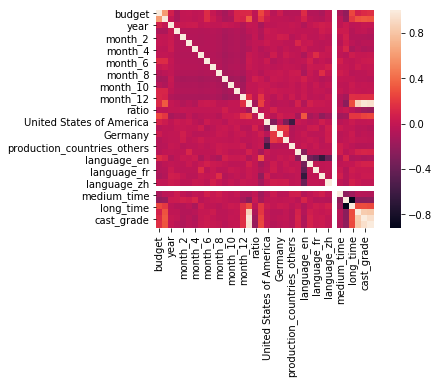

Comedy


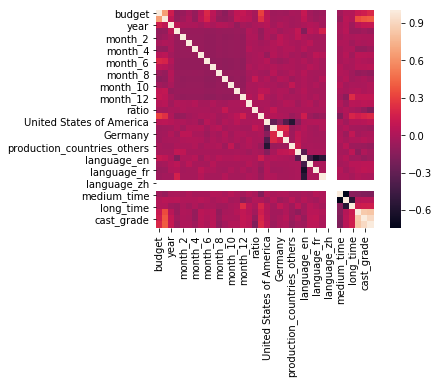

Thriller


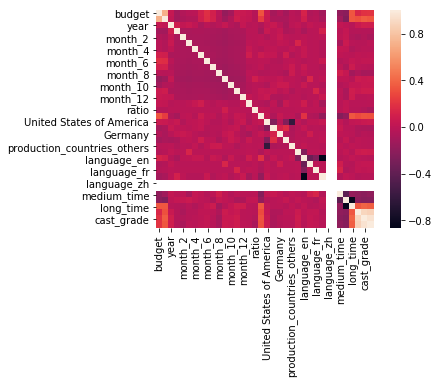

Action


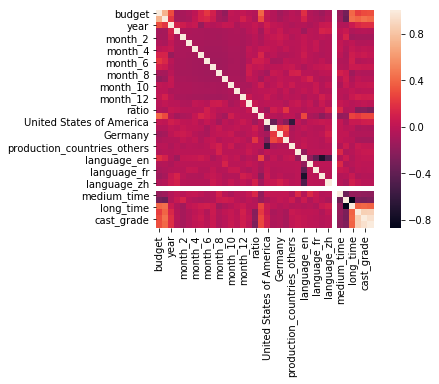

Adventure


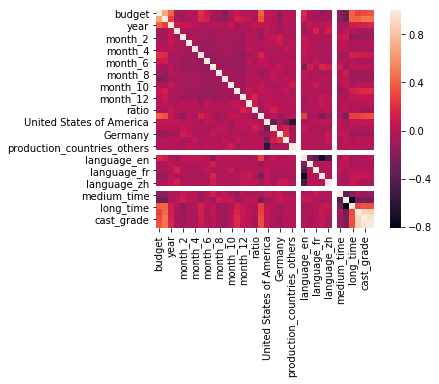

Romance


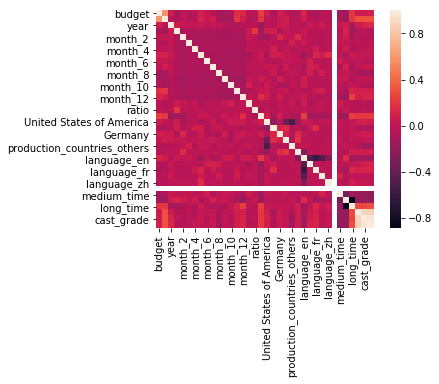

Crime


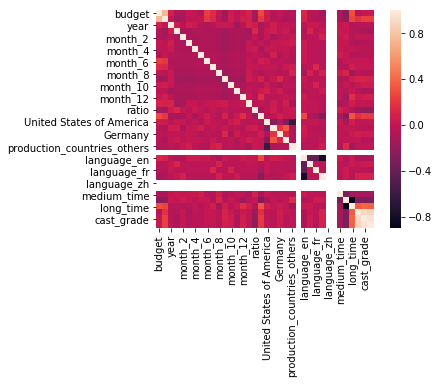

Science Fiction


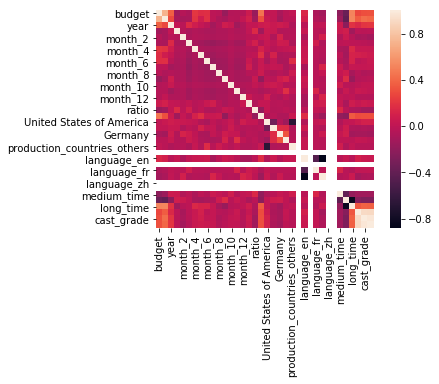

In [287]:
# List with the names of the 8 genres that we'll use
liste_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance','Crime',\
               'Science Fiction']
# List of the correlation matrixes by genre
liste_corr_genre = [dataset_genre.pre_process.train[i].corr() for i in range(len(liste_genres))] 
for index, x in enumerate(liste_corr_genre) :
    print(liste_genres[index])
    sns.heatmap(x, vmax=1, square=True)
    plt.show()

In [332]:
# Functions that we'll returns the classifiers that best fit the data
# It will also give, for each genre, the accuracy and the classifier used to get its accuracy
# It is made for grade as label
def compare_classification_genre(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_function_classifier = [get_lda , get_lreg, get_perc , get_svm,get_dtc ,\
                            get_rfc, get_ada]
    liste_classifiers = [LinearDiscriminantAnalysis, LogisticRegression,Perceptron,\
                    SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]
    liste_class = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_grade_data(i)    
        print(liste_genres[i])
        classifier = Classifications(X_train, y_train, X_test, y_test)
        classifier.set_regressors(liste_classifiers)
        classifier.set_functions(liste_function_classifier)
        for j in range(1,len(liste_function_classifier)) : 
            classifier.function(j)
            classifier.print_classifier_scores(j)
        print("For Classifier : ", liste_genres[i])
        classifier.print_all_score()
        liste_class.append(classifier)
        answer.append(classifier.print_best_classifier())
    return answer , liste_class



<div class="alert alert-success">
Grade as 100 different labels for the genre splits
    
</div>



Drama
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0843373493976
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.0843373493976
Score for generalization with LogisticRegression 0.076
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0433734939759
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0433734939759
Score for generalization with Perceptron 0.06
Kernel used :  sigmoid
Score after cross validation for SVM 0.0614457831325
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0614457831325
Score for generalization with SVC 0.076
Max depth chosen :  16
Score after cross validation for Decision Tree 0.124096385542
Parameters :  {'max_depth': 16, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision Trees 

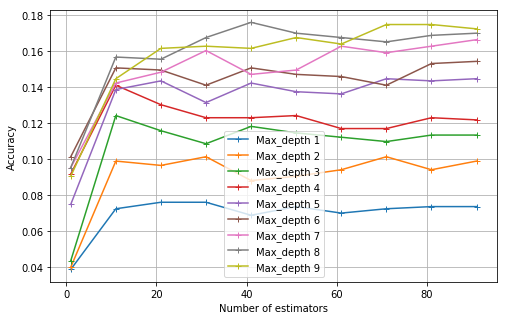

Number of estimators :  40
Max depth :  8
Parameters :  {'max_depth': 8, 'n_estimators': 40, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.177108433735
Score for generalization with RandomForestClassifier 0.144
Number of estimators :  141
Score after cross validation for Adaboost 0.130120481928
Parameters :  {'learning_rate': 0.5, 'n_estimators': 141, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.130120481928
Score for generalization with AdaBoostClassifier 0.096
For Classifier :  Drama
Score for the different classifiers 
                        Score
LDA                     0.000
LogisticRegression      0.076
Perceptron              0.060
SVC                     0.076
Decision Trees          0.124
RandomForestClassifier  0.144
AdaBoostClassifier      0.096


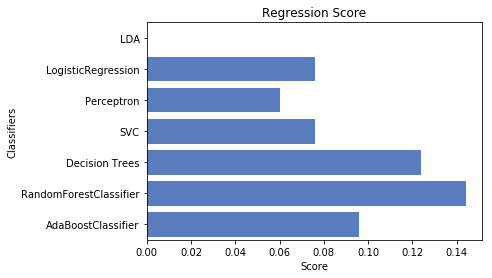

Comedy
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0381679389313
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.0381679389313
Score for generalization with LogisticRegression 0.0199004975124
Penalty chosen :  l2
Score after cross validation for Perceptron 0.0351145038168
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0351145038168
Score for generalization with Perceptron 0.0149253731343
Kernel used :  rbf
Score after cross validation for SVM 0.0320610687023
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0320610687023
Score for generalization with SVC 0.0348258706468
Max depth chosen :  7
Score after cross validation for Decision Tree 0.0488549618321
Parameters :  {'max_depth': 7, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validati

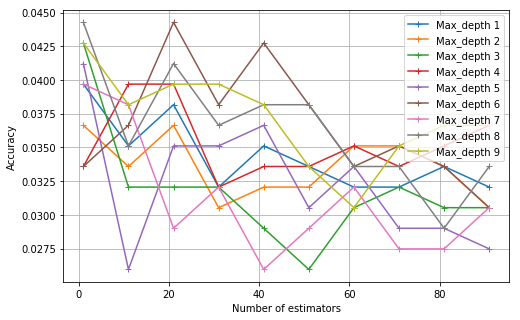

Number of estimators :  1
Max depth :  8
Parameters :  {'max_depth': 8, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0442748091603
Score for generalization with RandomForestClassifier 0.0248756218905
Number of estimators :  11
Score after cross validation for Adaboost 0.0381679389313
Parameters :  {'learning_rate': 0.5, 'n_estimators': 11, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.0381679389313
Score for generalization with AdaBoostClassifier 0.0497512437811
For Classifier :  Comedy
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.019900
Perceptron              0.014925
SVC                     0.034826
Decision Trees          0.054726
RandomForestClassifier  0.024876
AdaBoostClassifier      0.049751


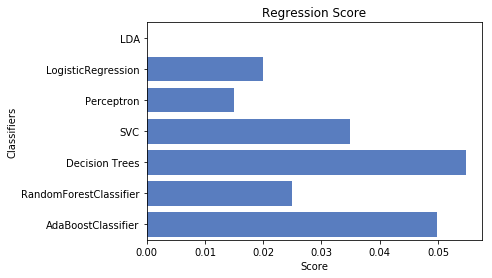

Thriller
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.0442477876106
Parameters :  {'multi_class': 'multinomial', 'solver': 'saga', 'random_state': 1}
Score cross validation with LogisticRegression 0.0442477876106
Score for generalization with LogisticRegression 0.0233918128655
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0407079646018
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0407079646018
Score for generalization with Perceptron 0.0292397660819
Kernel used :  poly
Score after cross validation for SVM 0.0336283185841
Parameters :  {'kernel': 'poly', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0336283185841
Score for generalization with SVC 0.046783625731
Max depth chosen :  17
Score after cross validation for Decision Tree 0.0371681415929
Parameters :  {'max_depth': 17, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation wi

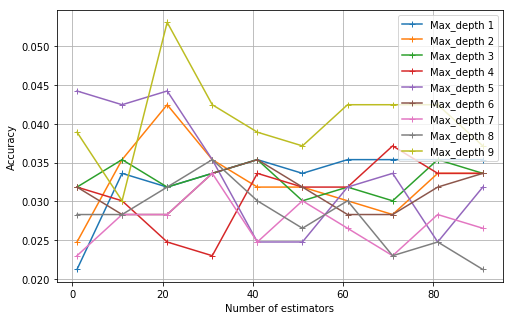

Number of estimators :  21
Max depth :  9
Parameters :  {'max_depth': 9, 'n_estimators': 21, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0530973451327
Score for generalization with RandomForestClassifier 0.0350877192982
Number of estimators :  131
Score after cross validation for Adaboost 0.0336283185841
Parameters :  {'learning_rate': 0.5, 'n_estimators': 131, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.0336283185841
Score for generalization with AdaBoostClassifier 0.0292397660819
For Classifier :  Thriller
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.023392
Perceptron              0.029240
SVC                     0.046784
Decision Trees          0.017544
RandomForestClassifier  0.035088
AdaBoostClassifier      0.029240


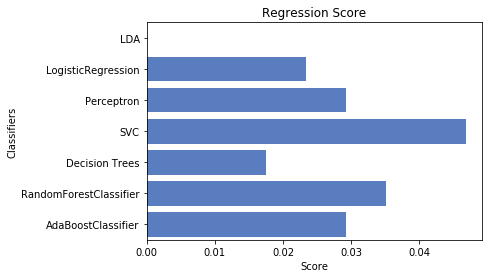

Action
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.0462962962963
Parameters :  {'multi_class': 'multinomial', 'solver': 'saga', 'random_state': 1}
Score cross validation with LogisticRegression 0.0462962962963
Score for generalization with LogisticRegression 0.0245398773006
Penalty chosen :  l2
Score after cross validation for Perceptron 0.0296296296296
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0296296296296
Score for generalization with Perceptron 0.0552147239264
Kernel used :  rbf
Score after cross validation for SVM 0.037037037037
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.037037037037
Score for generalization with SVC 0.0368098159509
Max depth chosen :  12
Score after cross validation for Decision Tree 0.0388888888889
Parameters :  {'max_depth': 12, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with De

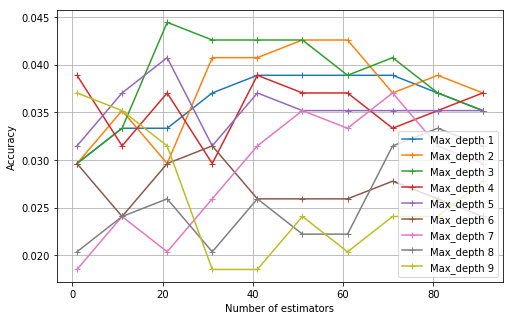

Number of estimators :  21
Max depth :  3
Parameters :  {'max_depth': 3, 'n_estimators': 21, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0444444444444
Score for generalization with RandomForestClassifier 0.0306748466258
Number of estimators :  41
Score after cross validation for Adaboost 0.0407407407407
Parameters :  {'learning_rate': 0.5, 'n_estimators': 41, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.0407407407407
Score for generalization with AdaBoostClassifier 0.0122699386503
For Classifier :  Action
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.024540
Perceptron              0.055215
SVC                     0.036810
Decision Trees          0.036810
RandomForestClassifier  0.030675
AdaBoostClassifier      0.012270


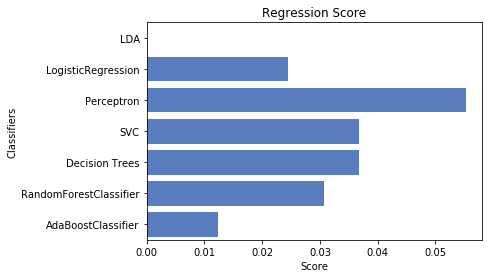

Adventure
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.012987012987
Parameters :  {'multi_class': 'multinomial', 'solver': 'saga', 'random_state': 1}
Score cross validation with LogisticRegression 0.012987012987
Score for generalization with LogisticRegression 0.0504201680672
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0155844155844
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0155844155844
Score for generalization with Perceptron 0.0420168067227
Kernel used :  rbf
Score after cross validation for SVM 0.0467532467532
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0467532467532
Score for generalization with SVC 0.0168067226891
Max depth chosen :  1
Score after cross validation for Decision Tree 0.0493506493506
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with D

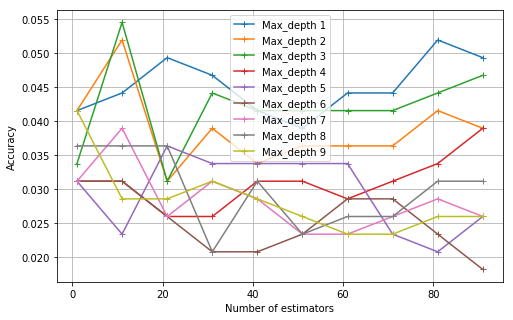

Number of estimators :  11
Max depth :  3
Parameters :  {'max_depth': 3, 'n_estimators': 11, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0545454545455
Score for generalization with RandomForestClassifier 0.0252100840336
Number of estimators :  1
Score after cross validation for Adaboost 0.0467532467532
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.0467532467532
Score for generalization with AdaBoostClassifier 0.0252100840336
For Classifier :  Adventure
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.050420
Perceptron              0.042017
SVC                     0.016807
Decision Trees          0.033613
RandomForestClassifier  0.025210
AdaBoostClassifier      0.025210


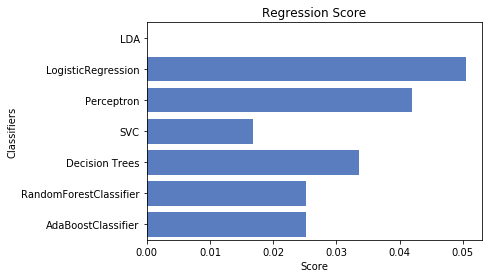

Romance
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0363636363636
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.0363636363636
Score for generalization with LogisticRegression 0.0208333333333
Penalty chosen :  l2
Score after cross validation for Perceptron 0.0242424242424
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0242424242424
Score for generalization with Perceptron 0.0520833333333
Kernel used :  poly
Score after cross validation for SVM 0.0454545454545
Parameters :  {'kernel': 'poly', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0454545454545
Score for generalization with SVC 0.03125
Max depth chosen :  2
Score after cross validation for Decision Tree 0.0515151515152
Parameters :  {'max_depth': 2, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation wi

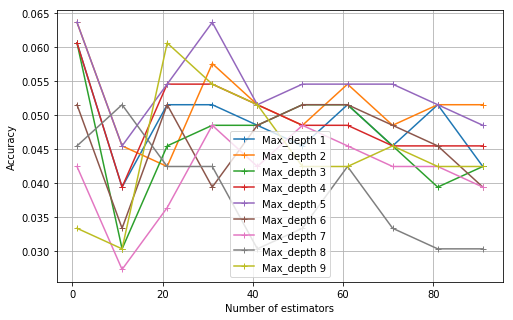

Number of estimators :  1
Max depth :  2
Parameters :  {'max_depth': 2, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0636363636364
Score for generalization with RandomForestClassifier 0.0416666666667
Number of estimators :  1
Score after cross validation for Adaboost 0.0393939393939
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.0393939393939
Score for generalization with AdaBoostClassifier 0.03125
For Classifier :  Romance
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.020833
Perceptron              0.052083
SVC                     0.031250
Decision Trees          0.031250
RandomForestClassifier  0.041667
AdaBoostClassifier      0.031250


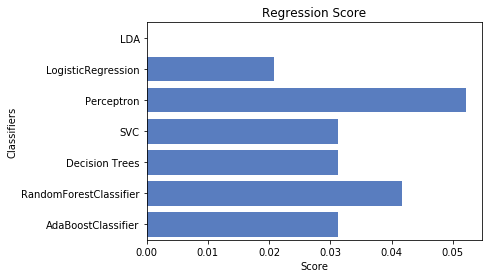

Crime
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.0222222222222
Parameters :  {'multi_class': 'multinomial', 'solver': 'saga', 'random_state': 1}
Score cross validation with LogisticRegression 0.0222222222222
Score for generalization with LogisticRegression 0.0103092783505
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0222222222222
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0222222222222
Score for generalization with Perceptron 0.0515463917526
Kernel used :  sigmoid
Score after cross validation for SVM 0.0539682539683
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.0539682539683
Score for generalization with SVC 0.0309278350515
Max depth chosen :  6
Score after cross validation for Decision Tree 0.0507936507937
Parameters :  {'max_depth': 6, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation 

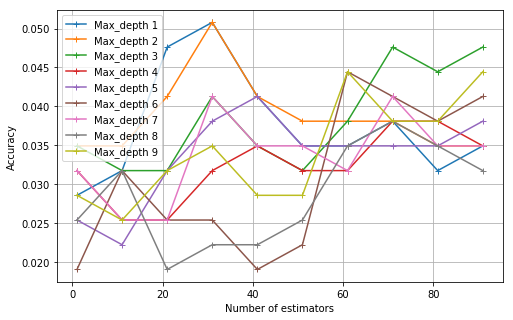

Number of estimators :  31
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 31, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0507936507937
Score for generalization with RandomForestClassifier 0.020618556701
Number of estimators :  61
Score after cross validation for Adaboost 0.047619047619
Parameters :  {'learning_rate': 0.5, 'n_estimators': 61, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.047619047619
Score for generalization with AdaBoostClassifier 0.0412371134021
For Classifier :  Crime
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.010309
Perceptron              0.051546
SVC                     0.030928
Decision Trees          0.000000
RandomForestClassifier  0.020619
AdaBoostClassifier      0.041237


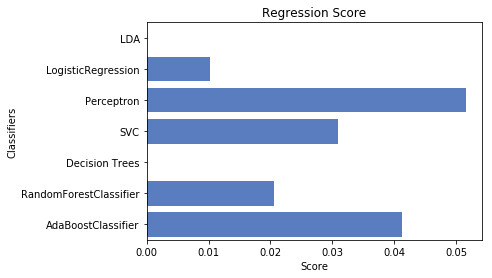

Science Fiction
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0489795918367
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.0489795918367
Score for generalization with LogisticRegression 0.0263157894737
Penalty chosen :  l2
Score after cross validation for Perceptron 0.0285714285714
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0285714285714
Score for generalization with Perceptron 0.0526315789474
Kernel used :  poly
Score after cross validation for SVM 0.065306122449
Parameters :  {'kernel': 'poly', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.065306122449
Score for generalization with SVC 0.0263157894737
Max depth chosen :  1
Score after cross validation for Decision Tree 0.0571428571429
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross

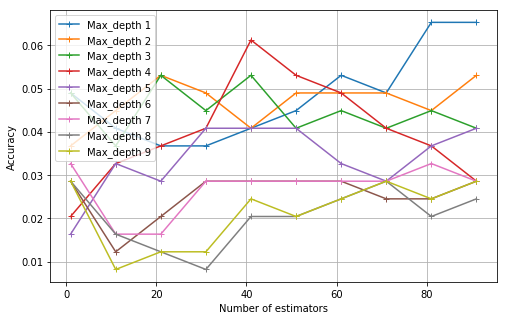

Number of estimators :  40
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 40, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.0408163265306
Score for generalization with RandomForestClassifier 0.0263157894737
Number of estimators :  1
Score after cross validation for Adaboost 0.0734693877551
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.0734693877551
Score for generalization with AdaBoostClassifier 0.0263157894737
For Classifier :  Science Fiction
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.026316
Perceptron              0.052632
SVC                     0.026316
Decision Trees          0.026316
RandomForestClassifier  0.026316
AdaBoostClassifier      0.026316


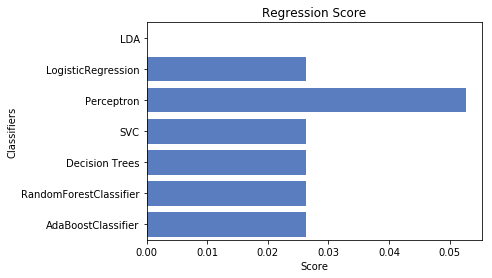

In [333]:
# Gets the results for all the genres
answer_c_100 , liste_classifiers_g_100 =  compare_classification_genre(liste_genres, dataset_genre)

In [336]:
# It will plot the classifiers, accuracy for each genre
def plot_graph_genre_c(classifiers,liste_genres) :
    liste_max_score = []
    liste_name_reg = []
    for i in range(len(liste_genres)) :
        max_score = np.max(classifiers[i].list_score)
        index_max = np.argmax(classifiers[i].list_score)
        name_reg = classifiers[i].classificators_name[index_max]
        liste_max_score.append(max_score)
        liste_name_reg.append(name_reg)
    score_classifiers = {}
    score_classifiers['Accuracy'] = liste_max_score
    score_classifiers['Classifier used'] = liste_name_reg
    score_class_df = pd.DataFrame(score_classifiers, index =liste_genres)        
    print(score_class_df)            


In [335]:
# Prints the results for each genre with 100 labels as grade
plot_graph_genre_c(liste_classifiers_g_100,liste_genres)

8
8
8
                 Accuracy         Classifier used
Drama            0.144000  RandomForestClassifier
Comedy           0.054726          Decision Trees
Thriller         0.046784                     SVC
Action           0.055215              Perceptron
Adventure        0.050420      LogisticRegression
Romance          0.052083              Perceptron
Crime            0.051546              Perceptron
Science Fiction  0.052632              Perceptron


<div class="alert alert-success">
Grade as 20 different labels for the genre splits
    
</div>



In [337]:
# Creation of a Dataset instance
dataset_genre_20 = Dataset(pre_process_genre)
# Discretization into 20 labels
dataset_genre_20.discretize(1)
# Splits into train and test subsets
dataset_genre_20.set_sets()
# Normalization of the inputs
dataset_genre_20.normalize()


Drama
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.472289156627
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.472289156627
Score for generalization with LogisticRegression 0.432
Penalty chosen :  l2
Score after cross validation for Perceptron 0.246987951807
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.246987951807
Score for generalization with Perceptron 0.224
Kernel used :  sigmoid
Score after cross validation for SVM 0.475903614458
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.475903614458
Score for generalization with SVC 0.42
Max depth chosen :  13
Score after cross validation for Decision Tree 0.495180722892
Parameters :  {'max_depth': 13, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision Trees 0.4951

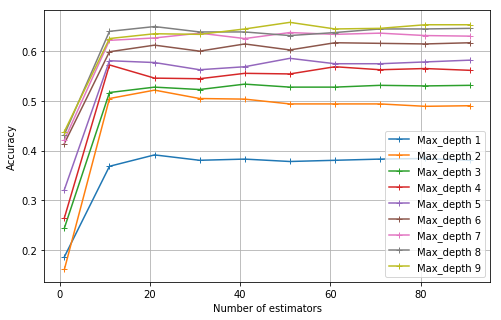

Number of estimators :  40
Max depth :  9
Parameters :  {'max_depth': 9, 'n_estimators': 40, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.648192771084
Score for generalization with RandomForestClassifier 0.52
Number of estimators :  131
Score after cross validation for Adaboost 0.455421686747
Parameters :  {'learning_rate': 0.5, 'n_estimators': 131, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.455421686747
Score for generalization with AdaBoostClassifier 0.388
For Classifier :  Drama
Score for the different classifiers 
                        Score
LDA                     0.000
LogisticRegression      0.432
Perceptron              0.224
SVC                     0.420
Decision Trees          0.420
RandomForestClassifier  0.520
AdaBoostClassifier      0.388


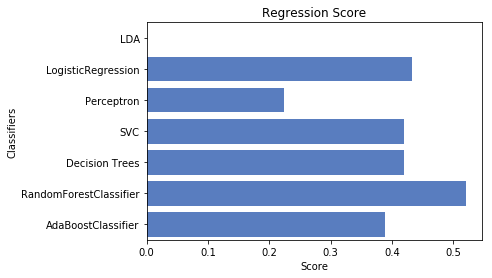

Comedy
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.829007633588
Parameters :  {'multi_class': 'multinomial', 'solver': 'saga', 'random_state': 1}
Score cross validation with LogisticRegression 0.829007633588
Score for generalization with LogisticRegression 0.791044776119
Penalty chosen :  l1
Score after cross validation for Perceptron 0.760305343511
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.760305343511
Score for generalization with Perceptron 0.661691542289
Kernel used :  rbf
Score after cross validation for SVM 0.842748091603
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.842748091603
Score for generalization with SVC 0.791044776119
Max depth chosen :  1
Score after cross validation for Decision Tree 0.842748091603
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision Tre

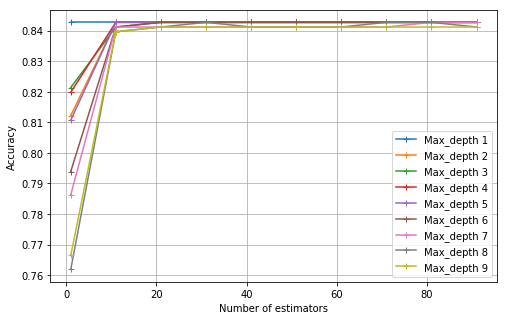

Number of estimators :  1
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.842748091603
Score for generalization with RandomForestClassifier 0.791044776119
Number of estimators :  11
Score after cross validation for Adaboost 0.841221374046
Parameters :  {'learning_rate': 0.5, 'n_estimators': 11, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.841221374046
Score for generalization with AdaBoostClassifier 0.791044776119
For Classifier :  Comedy
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.791045
Perceptron              0.661692
SVC                     0.791045
Decision Trees          0.791045
RandomForestClassifier  0.791045
AdaBoostClassifier      0.791045


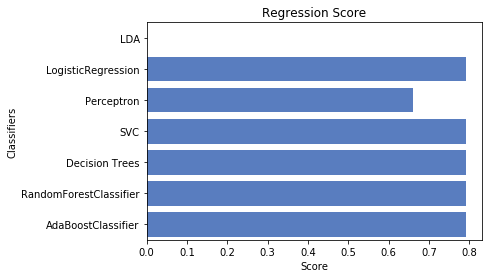

Thriller
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.823008849558
Parameters :  {'multi_class': 'multinomial', 'solver': 'saga', 'random_state': 1}
Score cross validation with LogisticRegression 0.823008849558
Score for generalization with LogisticRegression 0.801169590643
Penalty chosen :  l1
Score after cross validation for Perceptron 0.757522123894
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.757522123894
Score for generalization with Perceptron 0.766081871345
Kernel used :  rbf
Score after cross validation for SVM 0.847787610619
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.847787610619
Score for generalization with SVC 0.801169590643
Max depth chosen :  1
Score after cross validation for Decision Tree 0.847787610619
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision T

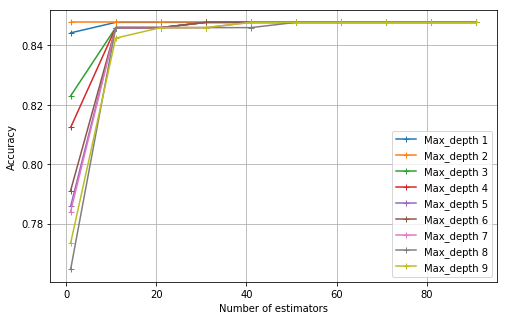

Number of estimators :  1
Max depth :  2
Parameters :  {'max_depth': 2, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.847787610619
Score for generalization with RandomForestClassifier 0.801169590643
Number of estimators :  1
Score after cross validation for Adaboost 0.846017699115
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.846017699115
Score for generalization with AdaBoostClassifier 0.801169590643
For Classifier :  Thriller
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.801170
Perceptron              0.766082
SVC                     0.801170
Decision Trees          0.801170
RandomForestClassifier  0.801170
AdaBoostClassifier      0.801170


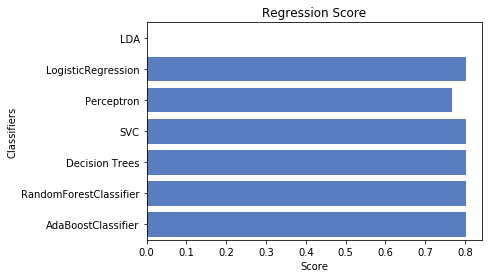

Action
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.824074074074
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.824074074074
Score for generalization with LogisticRegression 0.791411042945
Penalty chosen :  l2
Score after cross validation for Perceptron 0.759259259259
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.759259259259
Score for generalization with Perceptron 0.742331288344
Kernel used :  rbf
Score after cross validation for SVM 0.844444444444
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.844444444444
Score for generalization with SVC 0.79754601227
Max depth chosen :  1
Score after cross validation for Decision Tree 0.844444444444
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Dec

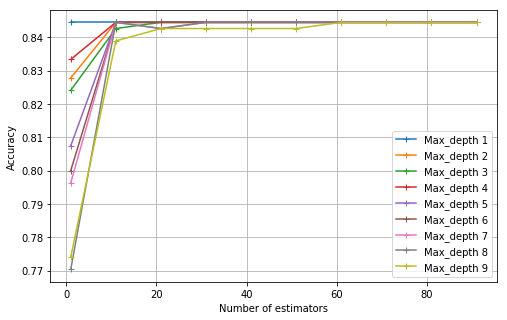

Number of estimators :  1
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.844444444444
Score for generalization with RandomForestClassifier 0.79754601227
Number of estimators :  11
Score after cross validation for Adaboost 0.840740740741
Parameters :  {'learning_rate': 0.5, 'n_estimators': 11, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.840740740741
Score for generalization with AdaBoostClassifier 0.791411042945
For Classifier :  Action
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.791411
Perceptron              0.742331
SVC                     0.797546
Decision Trees          0.797546
RandomForestClassifier  0.797546
AdaBoostClassifier      0.791411


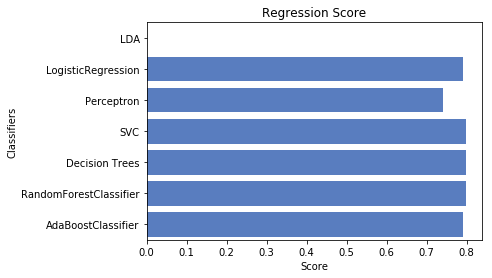

Adventure
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.844155844156
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.844155844156
Score for generalization with LogisticRegression 0.781512605042
Penalty chosen :  l2
Score after cross validation for Perceptron 0.742857142857
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.742857142857
Score for generalization with Perceptron 0.764705882353
Kernel used :  rbf
Score after cross validation for SVM 0.85974025974
Parameters :  {'kernel': 'rbf', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.85974025974
Score for generalization with SVC 0.789915966387
Max depth chosen :  1
Score after cross validation for Decision Tree 0.85974025974
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with De

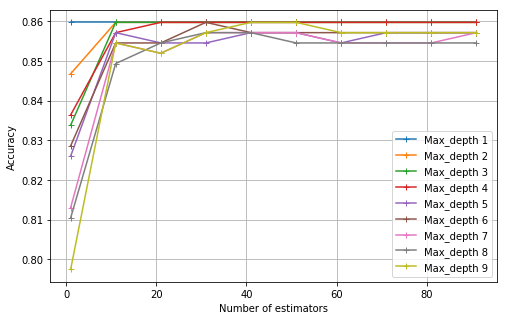

Number of estimators :  1
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.85974025974
Score for generalization with RandomForestClassifier 0.789915966387
Number of estimators :  1
Score after cross validation for Adaboost 0.849350649351
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.849350649351
Score for generalization with AdaBoostClassifier 0.789915966387
For Classifier :  Adventure
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.781513
Perceptron              0.764706
SVC                     0.789916
Decision Trees          0.789916
RandomForestClassifier  0.789916
AdaBoostClassifier      0.789916


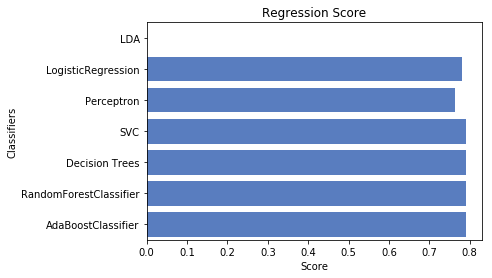

Romance
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.839393939394
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.839393939394
Score for generalization with LogisticRegression 0.802083333333
Penalty chosen :  l2
Score after cross validation for Perceptron 0.784848484848
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.784848484848
Score for generalization with Perceptron 0.739583333333
Kernel used :  poly
Score after cross validation for SVM 0.854545454545
Parameters :  {'kernel': 'poly', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.854545454545
Score for generalization with SVC 0.791666666667
Max depth chosen :  1
Score after cross validation for Decision Tree 0.854545454545
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with

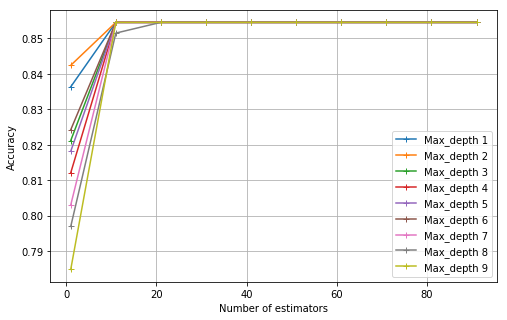

Number of estimators :  11
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 11, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.854545454545
Score for generalization with RandomForestClassifier 0.802083333333
Number of estimators :  11
Score after cross validation for Adaboost 0.851515151515
Parameters :  {'learning_rate': 0.5, 'n_estimators': 11, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.851515151515
Score for generalization with AdaBoostClassifier 0.802083333333
For Classifier :  Romance
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.802083
Perceptron              0.739583
SVC                     0.791667
Decision Trees          0.802083
RandomForestClassifier  0.802083
AdaBoostClassifier      0.802083


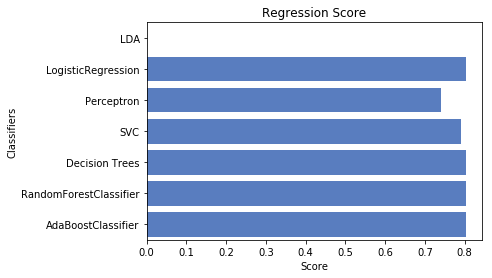

Crime
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.822222222222
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.822222222222
Score for generalization with LogisticRegression 0.773195876289
Penalty chosen :  l1
Score after cross validation for Perceptron 0.765079365079
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.765079365079
Score for generalization with Perceptron 0.742268041237
Kernel used :  poly
Score after cross validation for SVM 0.850793650794
Parameters :  {'kernel': 'poly', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.850793650794
Score for generalization with SVC 0.80412371134
Max depth chosen :  1
Score after cross validation for Decision Tree 0.850793650794
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with De

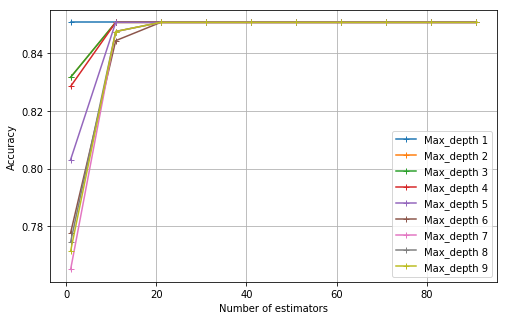

Number of estimators :  1
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.850793650794
Score for generalization with RandomForestClassifier 0.80412371134
Number of estimators :  1
Score after cross validation for Adaboost 0.847619047619
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.847619047619
Score for generalization with AdaBoostClassifier 0.80412371134
For Classifier :  Crime
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.773196
Perceptron              0.742268
SVC                     0.804124
Decision Trees          0.804124
RandomForestClassifier  0.804124
AdaBoostClassifier      0.804124


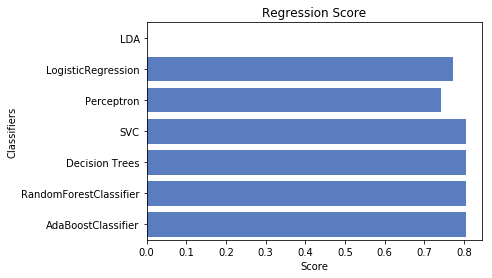

Science Fiction
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.824489795918
Parameters :  {'multi_class': 'multinomial', 'solver': 'newton-cg', 'random_state': 1}
Score cross validation with LogisticRegression 0.824489795918
Score for generalization with LogisticRegression 0.763157894737
Penalty chosen :  l1
Score after cross validation for Perceptron 0.751020408163
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.751020408163
Score for generalization with Perceptron 0.736842105263
Kernel used :  poly
Score after cross validation for SVM 0.844897959184
Parameters :  {'kernel': 'poly', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.844897959184
Score for generalization with SVC 0.763157894737
Max depth chosen :  1
Score after cross validation for Decision Tree 0.844897959184
Parameters :  {'max_depth': 1, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validat

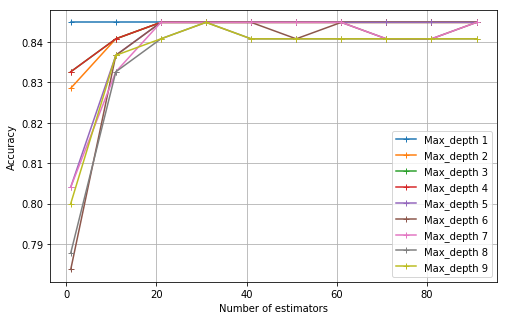

Number of estimators :  1
Max depth :  1
Parameters :  {'max_depth': 1, 'n_estimators': 1, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.844897959184
Score for generalization with RandomForestClassifier 0.763157894737
Number of estimators :  1
Score after cross validation for Adaboost 0.836734693878
Parameters :  {'learning_rate': 0.5, 'n_estimators': 1, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.836734693878
Score for generalization with AdaBoostClassifier 0.763157894737
For Classifier :  Science Fiction
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.763158
Perceptron              0.736842
SVC                     0.763158
Decision Trees          0.763158
RandomForestClassifier  0.763158
AdaBoostClassifier      0.763158


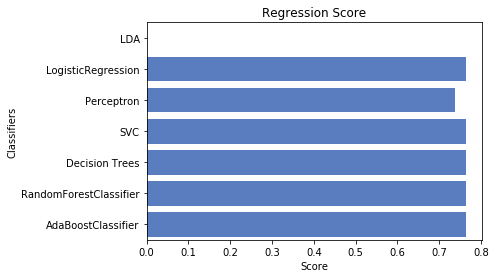

In [338]:
# Gets the results for all the genres
answer_c_20 , liste_classifiers_g_20 =  compare_classification_genre(liste_genres, dataset_genre_20)

In [339]:
# Prints the results for each genre with 20 labels as grade
print(len(liste_classifiers_g_20))
plot_graph_genre_c(liste_classifiers_g_20,liste_genres)

8
                 Accuracy         Classifier used
Drama            0.520000  RandomForestClassifier
Comedy           0.791045      LogisticRegression
Thriller         0.801170      LogisticRegression
Action           0.797546                     SVC
Adventure        0.789916                     SVC
Romance          0.802083      LogisticRegression
Crime            0.804124                     SVC
Science Fiction  0.763158      LogisticRegression


<div class="alert alert-success">
Revenue as 3 different labels for the genre splits
    
</div>



In [299]:
# Creation of a Dataset instance
dataset_genre_r = Dataset(pre_process_genre)
# Discretization revenue into 3 labels
dataset_genre_r.discretize_revenue()
# Splits into train and test subsets
dataset_genre_r.set_sets()
# Normalization of the inputs
dataset_genre_r.normalize()


In [362]:
# Functions that we'll returns the classifiers that best fit the data
# It will also give, for each genre, the accuracy and the classifier used to get its accuracy
# It is made for revenue label
def compare_revenue_genre(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_function_classifier = [get_lda , get_lreg, get_perc , get_svm,get_dtc ,\
                            get_rfc, get_ada]
    liste_classifiers = [LinearDiscriminantAnalysis, LogisticRegression,Perceptron,\
                    SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]
    liste_class = []
    # We make 1 here because for the other genres, there are cases where there is only one output class
    for i in range(1) :
        print(liste_genres[i])
        X_train, X_test, y_train, y_test = dataset_genre.get_revenue_data(i)            
        classifier = Classifications(X_train, y_train, X_test, y_test)
        classifier.set_regressors(liste_classifiers)
        classifier.set_functions(liste_function_classifier)
        for j in range(1,len(liste_function_classifier)) : 
            classifier.function(j)
            classifier.print_classifier_scores(j)
        print("For Classifier : ", liste_genres[i])
        classifier.print_all_score()
        liste_class.append(classifier)
        answer.append(classifier.print_best_classifier())
    return answer , liste_class



Drama
Solver chosen :  sag
Score after cross validation for Logistic Regression  0.657831325301
Parameters :  {'multi_class': 'multinomial', 'solver': 'sag', 'random_state': 1}
Score cross validation with LogisticRegression 0.657831325301
Score for generalization with LogisticRegression 0.656
Penalty chosen :  l2
Score after cross validation for Perceptron 0.550602409639
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.550602409639
Score for generalization with Perceptron 0.528
Kernel used :  sigmoid
Score after cross validation for SVM 0.628915662651
Parameters :  {'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 1}
Score cross validation with SVC 0.628915662651
Score for generalization with SVC 0.624
Max depth chosen :  8
Score after cross validation for Decision Tree 0.609638554217
Parameters :  {'max_depth': 8, 'splitter': 'best', 'max_features': 'auto', 'random_state': 1}
Score cross validation with Decision Trees 0.609638554217
Scor

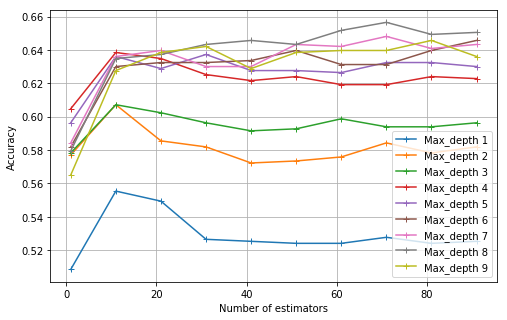

Number of estimators :  40
Max depth :  8
Parameters :  {'max_depth': 8, 'n_estimators': 40, 'random_state': 1}
Score cross validation with RandomForestClassifier 0.64578313253
Score for generalization with RandomForestClassifier 0.68
Number of estimators :  21
Score after cross validation for Adaboost 0.640963855422
Parameters :  {'learning_rate': 0.5, 'n_estimators': 21, 'random_state': 1}
Score cross validation with AdaBoostClassifier 0.640963855422
Score for generalization with AdaBoostClassifier 0.688
For Classifier :  Drama
Score for the different classifiers 
                        Score
LDA                     0.000
LogisticRegression      0.656
Perceptron              0.528
SVC                     0.624
Decision Trees          0.624
RandomForestClassifier  0.680
AdaBoostClassifier      0.688


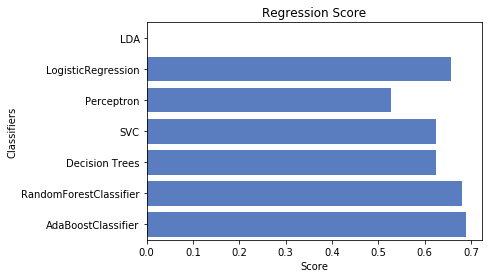

In [363]:
# Gets the results for all the genres
answer_r , liste_classifiers_r =  compare_revenue_genre(liste_genres, dataset_genre_r)

<div class="alert alert-success">
We get back all the data and print the coefficient of the linear regression depending on the features
    
</div>



In [314]:
# Gets the coefficients
coefs = regressor_grade.classifiers[0]().fit(regressor_grade.X_train, regressor_grade.y_train).coef_
# Gets the name of the features
name_features = pre_process.train[0].columns
# Index where the features are the highest
index_max = np.where( coefs >= 1.5e11)[0]

In [315]:
coefs

array([ -2.27852174e-02,  -1.39427746e-02,   2.14829955e+11,
         2.29271446e+11,   2.37580042e+11,   2.23863423e+11,
         2.37072481e+11,   2.46947917e+11,   2.48381341e+11,
         2.54916971e+11,   2.95510794e+11,   2.53537236e+11,
         2.39093724e+11,   2.69826394e+11,  -9.84900447e-03,
         9.11676115e-03,  -4.29454487e-03,  -7.35458800e-03,
         2.49008108e-03,  -6.05155024e-03,   8.08164297e-03,
        -5.92024506e-03,  -1.51295432e-02,   9.46721480e-04,
         1.67061820e-02,  -4.65403365e-03,   7.54861328e-03,
        -4.15570558e-03,  -1.67376062e-02,   2.44006270e-03,
        -5.54628577e-03,  -1.17444247e-03,  -3.41936402e+10,
        -2.95410156e-02,  -3.02124023e-03,  -1.04866028e-02,
         3.89099121e-04,  -1.46484375e-03,  -2.03704834e-03,
         6.35686217e+11,   2.61196751e+12,   9.69642520e+11,
         1.24083048e+12,   1.83841751e+12,   8.59956552e+11,
        -1.75208953e+10,  -2.79582972e+11,  -4.47619205e+11,
        -4.09961495e+11,

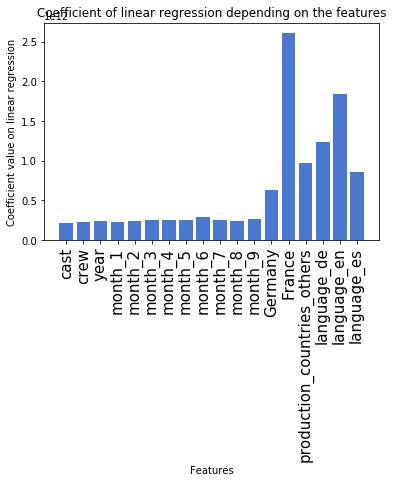

In [316]:
new_column = np.array([x for x in data.columns if (x!='revenue' and x!='ratio' and x!='grade')])[index_max]

# Plots 
plt.xticks(rotation=90, fontsize = 15)
plt.ylabel("Coefficient value on linear regression")
plt.xlabel("Features")
plt.bar(new_column, coefs[index_max], align = 'center', color='b')
plt.title("Coefficient of linear regression depending on the features")
plt.show()

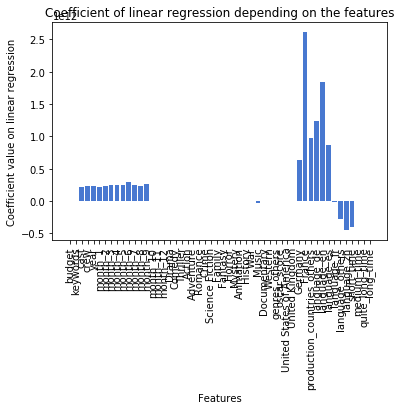

In [309]:
# Plots all
new_column = np.array([x for x in data.columns if (x!='revenue' and x!='ratio' and x!='grade')])
plt.xticks(rotation=90, fontsize = 10)
plt.ylabel("Coefficient value on linear regression")
plt.xlabel("Features")
plt.bar(new_column, coefs, align = 'center', color='b')
plt.title("Coefficient of linear regression depending on the features")
plt.show()

As a conclusion, it seems that for the linear regression, the higher the parameters are the more important the feature is. In this effect, a movie which is produced in France or where the language is english is more likely to have a good impact on the success of a movie.